# 📊 Análisis Exploratorio de Datos (EDA) - EpiForecast-MX

## Proyecto de Predicción de Enfermedades Neurológicas y Salud Mental en México

**Autores:** Equipo IntegradorIMSS2026Team01  
**Institución:** Tecnológico de Monterrey - Maestría en Inteligencia Artificial Aplicada  
**Colaborador:** Instituto Mexicano del Seguro Social (IMSS)  
**Fecha:** Enero 2026  

---

### Objetivo

Este notebook presenta un análisis exploratorio exhaustivo del dataset de boletines epidemiológicos de México, abarcando casos de:
- **Depresión**
- **Enfermedad de Parkinson**
- **Enfermedad de Alzheimer**

El análisis servirá como base para el desarrollo de modelos predictivos que apoyen la planificación estratégica de recursos de salud en las 32 entidades federativas de México.

---
## 1. 🔧 Setup y Configuración

In [1]:
"""
Imports principales del proyecto.
Organizado por categorías: análisis, visualización, utilidades.
"""
# =============================================================================
# IMPORTS
# =============================================================================

# Análisis de datos
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import zscore, shapiro, kruskal, spearmanr, pearsonr

# Visualización
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

# Utilidades
from loguru import logger
import warnings
from pathlib import Path
from typing import Tuple, List, Dict, Optional, Any
from datetime import datetime

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Seed para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

logger.info("✅ Imports completados exitosamente")

2026-01-28 10:17:16.106 | INFO     | __main__:<module>:39 - ✅ Imports completados exitosamente


In [2]:
import plotly.io as pio

# Renderizar como PNG de alta calidad para GitHub
pio.renderers.default = "png"
pio.kaleido.scope.default_scale = 3  
pio.kaleido.scope.default_width = 1000
pio.kaleido.scope.default_height = 600

In [3]:
"""
Constantes y configuración del proyecto.
Centraliza todos los parámetros para facilitar modificaciones.
"""
# =============================================================================
# CONSTANTES Y CONFIGURACIÓN
# =============================================================================

# Rutas
DATA_PATH = Path("../data/processed/dataset_boletin_epidemiologico.csv")
OUTPUT_PATH = Path("../outputs/eda")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Paleta de colores profesional (accesible y consistente)
COLORS = {
    'primary': '#0D47A1',      # Yale Blue
    'secondary': '#1976D2',    # Pacific Blue
    'accent': '#42A5F5',       # Light Blue
    'success': '#4CAF50',      # Green
    'warning': '#FF9800',      # Orange
    'danger': '#F44336',       # Red
    'neutral': '#607D8B',      # Blue Grey
    'background': '#FAFAFA',   # Light Grey
}

# Colores por padecimiento
DISEASE_COLORS = {
    'Depresión': '#1976D2',
    'Parkinson': '#4CAF50', 
    'Alzheimer': '#FF9800',
}

# Configuración de gráficos Plotly
PLOTLY_TEMPLATE = 'plotly_white'
PLOT_CONFIG = {
    'displayModeBar': True,
    'responsive': True,
    'toImageButtonOptions': {
        'format': 'png',
        'filename': 'epiforecast_plot',
        'height': 600,
        'width': 1000,
        'scale': 2
    }
}

# Columnas del dataset
NUMERIC_COLS = ['Casos_semana', 'Acumulado_hombres', 'Acumulado_mujeres', 'Acumulado_anio_anterior']
CATEGORICAL_COLS = ['Entidad', 'Padecimiento', 'Semana']
TEMPORAL_COLS = ['Anio', 'Semana']

# Entidades de México (para validación)
ENTIDADES_MEXICO = [
    'Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche',
    'Coahuila', 'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de México',
    'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'México',
    'Michoacán', 'Morelos', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla',
    'Querétaro', 'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora',
    'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz', 'Yucatán', 'Zacatecas'
]

logger.info(f"📁 Ruta de datos: {DATA_PATH}")
logger.info(f"📁 Ruta de outputs: {OUTPUT_PATH}")

2026-01-28 10:17:16.163 | INFO     | __main__:<module>:62 - 📁 Ruta de datos: ../data/processed/dataset_boletin_epidemiologico.csv
2026-01-28 10:17:16.163 | INFO     | __main__:<module>:63 - 📁 Ruta de outputs: ../outputs/eda


In [4]:
"""
Funciones auxiliares para análisis y visualización.
Diseñadas para ser reutilizables y modulares.
"""
# =============================================================================
# FUNCIONES AUXILIARES - ANÁLISIS
# =============================================================================

def load_data(filepath: Path) -> pd.DataFrame:
    """
    Carga el dataset desde la ruta especificada.
    
    Args:
        filepath: Ruta al archivo CSV
        
    Returns:
        DataFrame con los datos cargados
        
    Raises:
        FileNotFoundError: Si el archivo no existe
    """
    logger.info(f"📂 Cargando datos desde {filepath}")
    
    if not filepath.exists():
        logger.error(f"❌ Archivo no encontrado: {filepath}")
        raise FileNotFoundError(f"No se encontró el archivo: {filepath}")
    
    df = pd.read_csv(filepath)
    logger.success(f"✅ Datos cargados: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    
    return df


def get_missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Genera un resumen detallado de valores faltantes.
    
    Args:
        df: DataFrame a analizar
        
    Returns:
        DataFrame con estadísticas de valores faltantes por columna
    """
    missing_count = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    summary = pd.DataFrame({
        'Columna': df.columns,
        'Tipo': df.dtypes.values,
        'No_Nulos': df.count().values,
        'Nulos': missing_count.values,
        'Pct_Nulos': missing_pct.values
    })
    
    return summary.sort_values('Pct_Nulos', ascending=False)


def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> Tuple[pd.Series, int, float]:
    """
    Detecta outliers usando el método IQR.
    
    Args:
        series: Serie numérica a analizar
        k: Multiplicador del IQR (default 1.5)
        
    Returns:
        Tuple con máscara booleana, conteo de outliers, y porcentaje
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    outliers_mask = (series < lower_bound) | (series > upper_bound)
    outliers_count = outliers_mask.sum()
    outliers_pct = (outliers_count / len(series)) * 100
    
    return outliers_mask, outliers_count, outliers_pct


def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> Tuple[pd.Series, int, float]:
    """
    Detecta outliers usando Z-score.
    
    Args:
        series: Serie numérica a analizar
        threshold: Umbral de Z-score (default 3.0)
        
    Returns:
        Tuple con máscara booleana, conteo de outliers, y porcentaje
    """
    z_scores = np.abs(zscore(series.dropna()))
    outliers_mask = pd.Series(z_scores > threshold, index=series.dropna().index)
    outliers_count = outliers_mask.sum()
    outliers_pct = (outliers_count / len(series.dropna())) * 100
    
    return outliers_mask, outliers_count, outliers_pct


def calculate_extended_stats(series: pd.Series) -> Dict[str, float]:
    """
    Calcula estadísticas descriptivas extendidas.
    
    Args:
        series: Serie numérica a analizar
        
    Returns:
        Diccionario con estadísticas completas
    """
    return {
        'count': series.count(),
        'mean': series.mean(),
        'std': series.std(),
        'min': series.min(),
        'q1': series.quantile(0.25),
        'median': series.median(),
        'q3': series.quantile(0.75),
        'max': series.max(),
        'iqr': series.quantile(0.75) - series.quantile(0.25),
        'range': series.max() - series.min(),
        'skewness': series.skew(),
        'kurtosis': series.kurtosis(),
        'cv': (series.std() / series.mean()) * 100 if series.mean() != 0 else np.nan
    }


def test_normality(series: pd.Series, sample_size: int = 5000) -> Dict[str, Any]:
    """
    Realiza prueba de normalidad Shapiro-Wilk.
    
    Args:
        series: Serie numérica a analizar
        sample_size: Tamaño de muestra para el test (max 5000)
        
    Returns:
        Diccionario con estadístico, p-valor e interpretación
    """
    clean_series = series.dropna()
    
    if len(clean_series) > sample_size:
        clean_series = clean_series.sample(n=sample_size, random_state=RANDOM_SEED)
    
    stat, p_value = shapiro(clean_series)
    
    return {
        'statistic': stat,
        'p_value': p_value,
        'is_normal': p_value > 0.05,
        'interpretation': 'Normal' if p_value > 0.05 else 'No Normal'
    }


logger.info("✅ Funciones de análisis cargadas")

2026-01-28 10:17:16.170 | INFO     | __main__:<module>:155 - ✅ Funciones de análisis cargadas


In [5]:
"""
Funciones auxiliares para visualización.
Utiliza Plotly para gráficos interactivos y profesionales.
"""
# =============================================================================
# FUNCIONES AUXILIARES - VISUALIZACIÓN
# =============================================================================

def style_plotly_figure(fig: go.Figure, title: str, height: int = 500) -> go.Figure:
    """
    Aplica estilo consistente a figuras de Plotly.
    
    Args:
        fig: Figura de Plotly
        title: Título del gráfico
        height: Altura en píxeles
        
    Returns:
        Figura con estilo aplicado
    """
    fig.update_layout(
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 18, 'color': COLORS['primary']}
        },
        template=PLOTLY_TEMPLATE,
        height=height,
        font=dict(family='Arial, sans-serif', size=12),
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        ),
        margin=dict(l=60, r=40, t=80, b=60),
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    
    return fig


def create_distribution_plot(
    df: pd.DataFrame, 
    column: str, 
    title: str,
    color: str = None,
    nbins: int = 50
) -> go.Figure:
    """
    Crea un histograma con curva de densidad.
    
    Args:
        df: DataFrame con los datos
        column: Nombre de la columna a visualizar
        title: Título del gráfico
        color: Color del histograma
        nbins: Número de bins
        
    Returns:
        Figura de Plotly
    """
    if color is None:
        color = COLORS['primary']
    
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=df[column],
        nbinsx=nbins,
        name='Frecuencia',
        marker_color=color,
        opacity=0.7
    ))
    
    return style_plotly_figure(fig, title)


def create_boxplot_by_category(
    df: pd.DataFrame,
    value_col: str,
    category_col: str,
    title: str,
    colors: Dict[str, str] = None
) -> go.Figure:
    """
    Crea boxplots agrupados por categoría.
    
    Args:
        df: DataFrame con los datos
        value_col: Columna con valores numéricos
        category_col: Columna con categorías
        title: Título del gráfico
        colors: Diccionario de colores por categoría
        
    Returns:
        Figura de Plotly
    """
    if colors is None:
        colors = DISEASE_COLORS
    
    fig = px.box(
        df,
        x=category_col,
        y=value_col,
        color=category_col,
        color_discrete_map=colors
    )
    
    return style_plotly_figure(fig, title)


def create_time_series(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    group_col: str = None,
    title: str = '',
    colors: Dict[str, str] = None
) -> go.Figure:
    """
    Crea gráfico de series temporales.
    
    Args:
        df: DataFrame con los datos
        date_col: Columna temporal
        value_col: Columna con valores
        group_col: Columna para agrupar líneas
        title: Título del gráfico
        colors: Diccionario de colores
        
    Returns:
        Figura de Plotly
    """
    if colors is None:
        colors = DISEASE_COLORS
    
    if group_col:
        fig = px.line(
            df,
            x=date_col,
            y=value_col,
            color=group_col,
            color_discrete_map=colors,
            markers=True
        )
    else:
        fig = px.line(
            df,
            x=date_col,
            y=value_col,
            markers=True
        )
        fig.update_traces(line_color=COLORS['primary'])
    
    return style_plotly_figure(fig, title, height=450)


def create_heatmap(
    data: pd.DataFrame,
    title: str,
    x_label: str = '',
    y_label: str = ''
) -> go.Figure:
    """
    Crea un heatmap con Plotly.
    
    Args:
        data: DataFrame o matriz para el heatmap
        title: Título del gráfico
        x_label: Etiqueta eje X
        y_label: Etiqueta eje Y
        
    Returns:
        Figura de Plotly
    """
    fig = go.Figure(data=go.Heatmap(
        z=data.values,
        x=data.columns,
        y=data.index,
        colorscale='Blues',
        text=np.round(data.values, 2),
        texttemplate='%{text}',
        textfont={'size': 10},
        hoverongaps=False
    ))
    
    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label
    )
    
    return style_plotly_figure(fig, title, height=500)


def create_bar_chart(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    title: str,
    color_col: str = None,
    orientation: str = 'v',
    colors: Dict[str, str] = None
) -> go.Figure:
    """
    Crea gráfico de barras.
    
    Args:
        df: DataFrame con los datos
        x_col: Columna para eje X
        y_col: Columna para eje Y
        title: Título del gráfico
        color_col: Columna para color
        orientation: 'v' para vertical, 'h' para horizontal
        colors: Diccionario de colores
        
    Returns:
        Figura de Plotly
    """
    if colors is None:
        colors = DISEASE_COLORS
    
    if orientation == 'h':
        fig = px.bar(
            df,
            x=y_col,
            y=x_col,
            color=color_col,
            orientation='h',
            color_discrete_map=colors if color_col else None
        )
    else:
        fig = px.bar(
            df,
            x=x_col,
            y=y_col,
            color=color_col,
            color_discrete_map=colors if color_col else None
        )
    
    if not color_col:
        fig.update_traces(marker_color=COLORS['primary'])
    
    return style_plotly_figure(fig, title)


def create_violin_plot(
    df: pd.DataFrame,
    value_col: str,
    category_col: str,
    title: str,
    colors: Dict[str, str] = None
) -> go.Figure:
    """
    Crea violin plot.
    
    Args:
        df: DataFrame con los datos
        value_col: Columna con valores numéricos
        category_col: Columna con categorías
        title: Título del gráfico
        colors: Diccionario de colores
        
    Returns:
        Figura de Plotly
    """
    if colors is None:
        colors = DISEASE_COLORS
    
    fig = px.violin(
        df,
        x=category_col,
        y=value_col,
        color=category_col,
        box=True,
        points='outliers',
        color_discrete_map=colors
    )
    
    return style_plotly_figure(fig, title)


logger.info("✅ Funciones de visualización cargadas")

2026-01-28 10:17:16.178 | INFO     | __main__:<module>:286 - ✅ Funciones de visualización cargadas


---
## 2. 📂 Carga de Datos

In [6]:
"""
Carga de datos desde DVC.
Asegúrate de haber ejecutado 'dvc pull' antes de correr esta celda.
"""
# Cargar datos
df = load_data(DATA_PATH)

# Vista inicial
print("\n📊 Primeras 5 filas del dataset:")
display(df.head())

print("\n📊 Últimas 5 filas del dataset:")
display(df.tail())

2026-01-28 10:17:16.181 | INFO     | __main__:load_data:22 - 📂 Cargando datos desde ../data/processed/dataset_boletin_epidemiologico.csv
2026-01-28 10:17:16.198 | SUCCESS  | __main__:load_data:29 - ✅ Datos cargados: 60,288 filas × 8 columnas



📊 Primeras 5 filas del dataset:


Anio  Semana          Entidad Padecimiento  Casos_semana  \
0  2014       2   Aguascalientes    Depresión          1.00   
1  2014       2   Aguascalientes    Parkinson          0.00   
2  2014       2   Aguascalientes    Alzheimer          0.00   
3  2014       2  Baja California    Depresión          2.00   
4  2014       2  Baja California    Parkinson          1.00   

   Acumulado_hombres  Acumulado_mujeres  Acumulado_anio_anterior  
0                  1                  0                      NaN  
1                  0                  0                      NaN  
2                  0                  0                      NaN  
3                  1                  1                      NaN  
4                  1                  0                      NaN


📊 Últimas 5 filas del dataset:


Anio  Semana    Entidad Padecimiento  Casos_semana  Acumulado_hombres  \
60283  2026       2    Yucatán    Parkinson          8.00                  3   
60284  2026       2    Yucatán    Alzheimer          0.00                  0   
60285  2026       2  Zacatecas    Depresión         64.00                 19   
60286  2026       2  Zacatecas    Parkinson          2.00                  1   
60287  2026       2  Zacatecas    Alzheimer          0.00                  0   

       Acumulado_mujeres  Acumulado_anio_anterior  
60283                  5                     2.00  
60284                  0                     0.00  
60285                 45                    38.00  
60286                  1                     0.00  
60287                  0                     0.00

In [7]:
"""
Información general del dataset.
"""
print("\n📋 Información del Dataset:")
print("=" * 50)
print(f"• Filas: {df.shape[0]:,}")
print(f"• Columnas: {df.shape[1]}")
print(f"• Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📋 Tipos de datos:")
print(df.dtypes)


📋 Información del Dataset:
• Filas: 60,288
• Columnas: 8
• Memoria: 9.93 MB

📋 Tipos de datos:
Anio                         int64
Semana                       int64
Entidad                     object
Padecimiento                object
Casos_semana               float64
Acumulado_hombres            int64
Acumulado_mujeres            int64
Acumulado_anio_anterior    float64
dtype: object


In [8]:
"""
Validación inicial de integridad.
"""
print("\n🔍 Validación de Datos:")
print("=" * 50)

# Rango de años
print(f"\n• Rango de años: {df['Anio'].min()} - {df['Anio'].max()}")

# Semanas epidemiológicas
semanas_unicas = sorted(df['Semana'].unique())
print(f"• Semanas epidemiológicas: {len(semanas_unicas)} (desde {semanas_unicas[0]} hasta {semanas_unicas[-1]})")

# Entidades
entidades_unicas = df['Entidad'].nunique()
print(f"• Entidades federativas: {entidades_unicas}")

# Padecimientos
print(f"• Padecimientos: {df['Padecimiento'].unique().tolist()}")

# Validar que tenemos las 32 entidades
entidades_faltantes = set(ENTIDADES_MEXICO) - set(df['Entidad'].unique())
if entidades_faltantes:
    logger.warning(f"⚠️ Entidades faltantes: {entidades_faltantes}")
else:
    logger.success("✅ Todas las 32 entidades presentes")

2026-01-28 10:17:16.224 | SUCCESS  | __main__:<module>:26 - ✅ Todas las 32 entidades presentes



🔍 Validación de Datos:

• Rango de años: 2014 - 2026
• Semanas epidemiológicas: 53 (desde 1 hasta 53)
• Entidades federativas: 33
• Padecimientos: ['Depresión', 'Parkinson', 'Alzheimer']


---
## 3. 🔍 Análisis de Calidad de Datos

### 3.1 Valores Faltantes

In [9]:
"""
Análisis de valores faltantes.
"""
missing_summary = get_missing_summary(df)

print("\n📊 Resumen de Valores Faltantes:")
print("=" * 60)
display(missing_summary)

# Total de valores faltantes
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
print(f"\n• Total de celdas: {total_cells:,}")
print(f"• Total de valores faltantes: {total_missing:,}")
print(f"• Porcentaje de valores faltantes: {(total_missing/total_cells)*100:.4f}%")


📊 Resumen de Valores Faltantes:


Columna     Tipo  No_Nulos  Nulos  Pct_Nulos
7  Acumulado_anio_anterior  float64     55200   5088       8.44
4             Casos_semana  float64     60285      3       0.00
0                     Anio    int64     60288      0       0.00
1                   Semana    int64     60288      0       0.00
2                  Entidad   object     60288      0       0.00
3             Padecimiento   object     60288      0       0.00
5        Acumulado_hombres    int64     60288      0       0.00
6        Acumulado_mujeres    int64     60288      0       0.00


• Total de celdas: 482,304
• Total de valores faltantes: 5,091
• Porcentaje de valores faltantes: 1.0556%


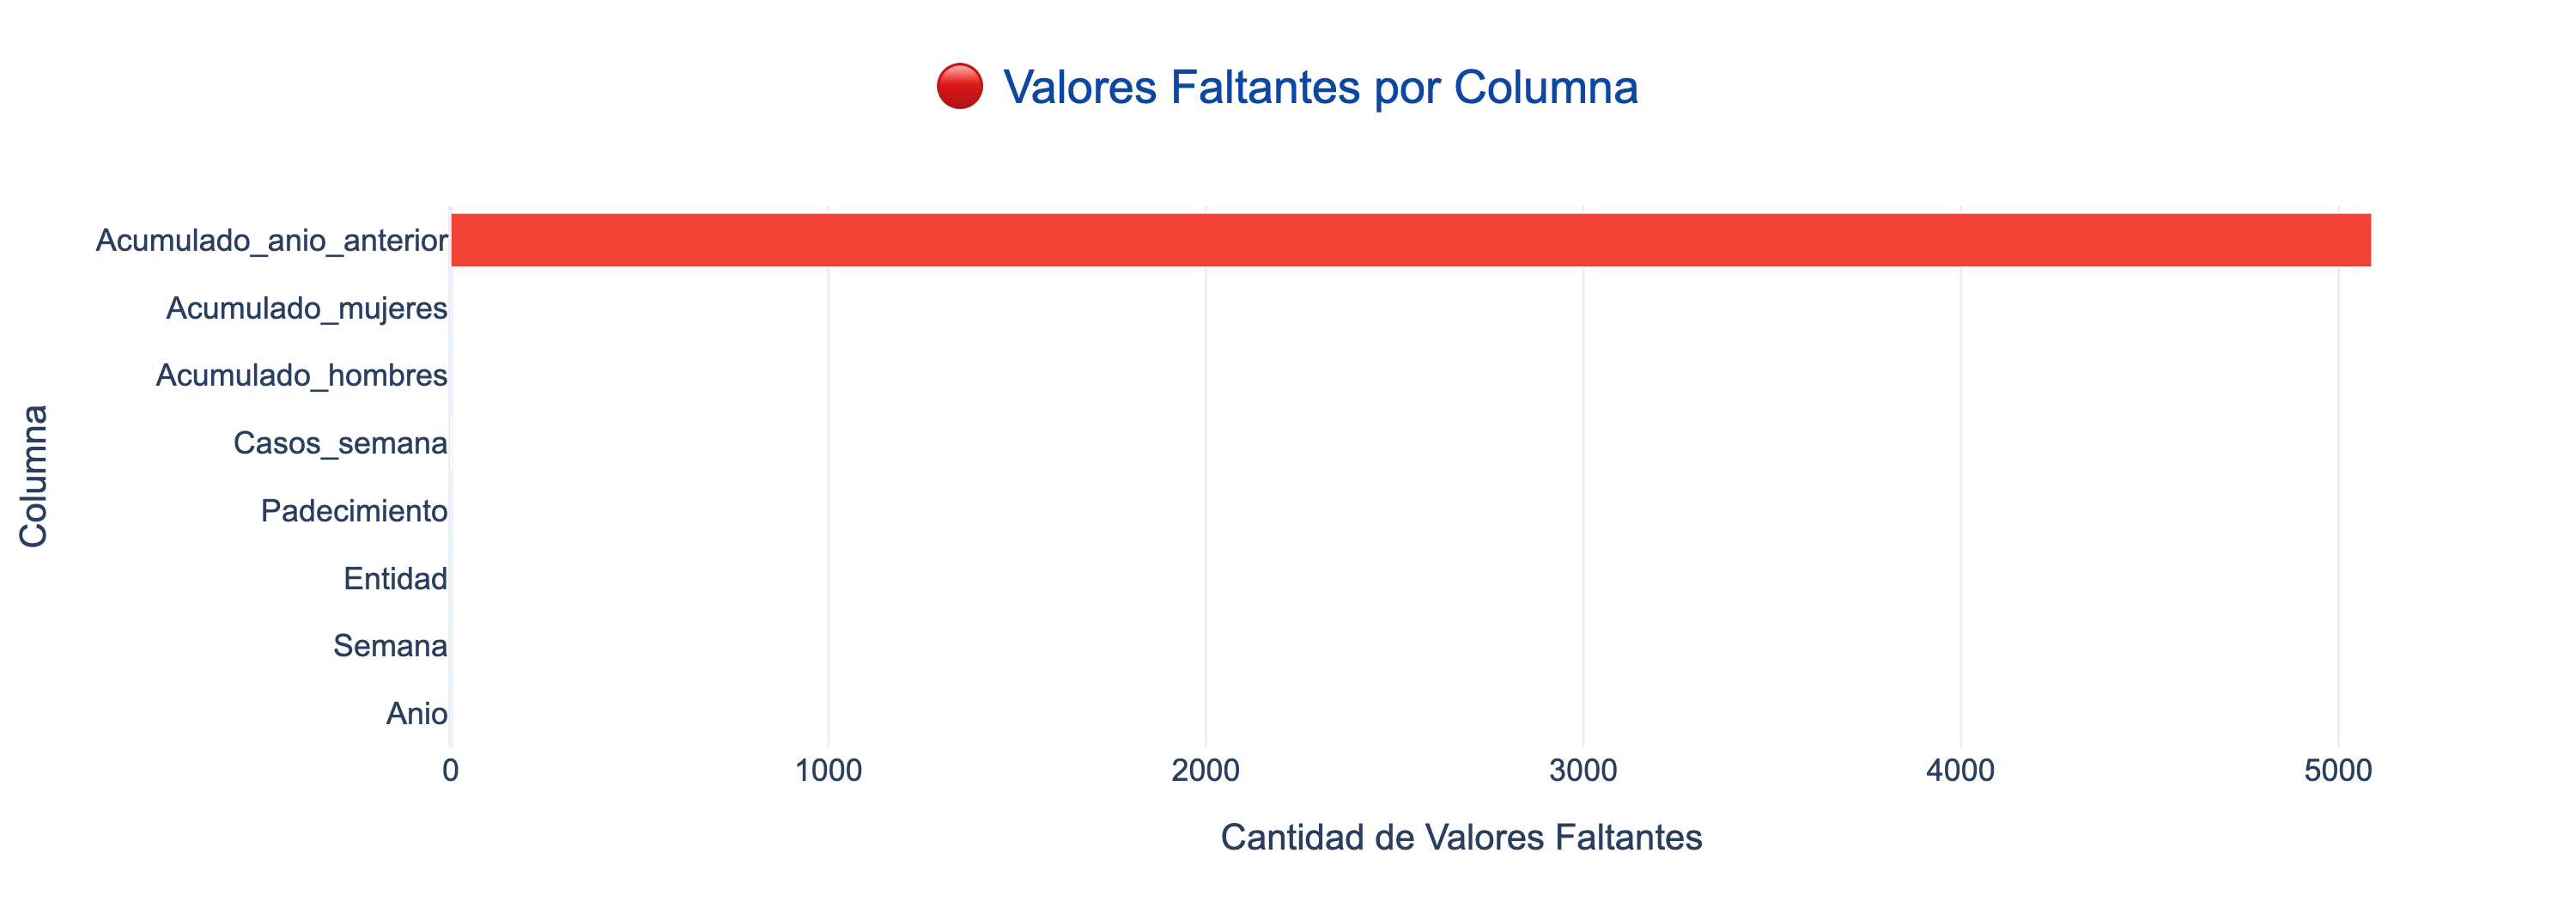

In [10]:
"""
Visualización de valores faltantes.
"""
# Resumen de valores faltantes (más eficiente que heatmap completo)
missing_counts = df.isnull().sum()

if missing_counts.sum() == 0:
    print("✅ No hay valores faltantes - no se requiere visualización")
else:
    # Barplot de valores faltantes por columna
    fig = go.Figure(data=go.Bar(
        x=missing_counts.values,
        y=missing_counts.index,
        orientation='h',
        marker_color=COLORS['danger']
    ))
    
    fig = style_plotly_figure(
        fig, 
        '🔴 Valores Faltantes por Columna',
        height=350
    )
    fig.update_layout(
        xaxis_title='Cantidad de Valores Faltantes',
        yaxis_title='Columna'
    )
    fig.show(config=PLOT_CONFIG)

In [11]:
"""
Análisis del patrón de valores faltantes (MCAR, MAR, MNAR).
"""
print("\n🔍 Análisis de Patrones de Ausencia:")
print("=" * 60)

if total_missing == 0:
    print("\n✅ No hay valores faltantes en el dataset.")
    print("No es necesario aplicar técnicas de imputación.")
else:
    # Analizar si los faltantes están relacionados con otras variables
    for col in df.columns[df.isnull().any()]:
        print(f"\n📌 Análisis para '{col}':")
        
        # Verificar si los faltantes se concentran en ciertos años
        missing_by_year = df[df[col].isnull()]['Anio'].value_counts()
        if not missing_by_year.empty:
            print(f"   Faltantes por año: {missing_by_year.to_dict()}")
        
        # Verificar si se concentran en ciertas entidades
        missing_by_entity = df[df[col].isnull()]['Entidad'].value_counts().head(5)
        if not missing_by_entity.empty:
            print(f"   Top 5 entidades con faltantes: {missing_by_entity.to_dict()}")


🔍 Análisis de Patrones de Ausencia:

📌 Análisis para 'Casos_semana':
   Faltantes por año: {2016: 3}
   Top 5 entidades con faltantes: {'Querétaro': 3}

📌 Análisis para 'Acumulado_anio_anterior':
   Faltantes por año: {2014: 4992, 2015: 96}
   Top 5 entidades con faltantes: {'Aguascalientes': 159, 'Baja California': 159, 'Yucatán': 159, 'Veracruz': 159, 'Tlaxcala': 159}


### 3.2 Valores Duplicados

In [12]:
"""
Detección de registros duplicados.
"""
print("\n🔍 Análisis de Duplicados:")
print("=" * 60)

# Duplicados exactos
duplicados_exactos = df.duplicated().sum()
print(f"\n• Filas duplicadas exactas: {duplicados_exactos:,}")

# Duplicados por clave lógica (Año + Semana + Entidad + Padecimiento)
key_cols = ['Anio', 'Semana', 'Entidad', 'Padecimiento']
duplicados_clave = df.duplicated(subset=key_cols).sum()
print(f"• Duplicados por clave lógica {key_cols}: {duplicados_clave:,}")

if duplicados_clave > 0:
    print("\n⚠️ Se encontraron duplicados. Mostrando ejemplos:")
    duplicados_df = df[df.duplicated(subset=key_cols, keep=False)].sort_values(key_cols)
    display(duplicados_df.head(10))
else:
    logger.success("✅ No se encontraron duplicados por clave lógica")

2026-01-28 10:17:16.782 | SUCCESS  | __main__:<module>:21 - ✅ No se encontraron duplicados por clave lógica



🔍 Análisis de Duplicados:

• Filas duplicadas exactas: 0
• Duplicados por clave lógica ['Anio', 'Semana', 'Entidad', 'Padecimiento']: 0


### 3.3 Detección de Outliers

In [13]:
"""
Detección de outliers usando métodos IQR y Z-score.
"""
print("\n🔍 Análisis de Outliers:")
print("=" * 60)

outliers_summary = []

for col in NUMERIC_COLS:
    if col in df.columns:
        # Método IQR
        _, count_iqr, pct_iqr = detect_outliers_iqr(df[col])
        
        # Método Z-score
        _, count_zscore, pct_zscore = detect_outliers_zscore(df[col])
        
        outliers_summary.append({
            'Variable': col,
            'Outliers_IQR': count_iqr,
            'Pct_IQR': f"{pct_iqr:.2f}%",
            'Outliers_ZScore': count_zscore,
            'Pct_ZScore': f"{pct_zscore:.2f}%"
        })

outliers_df = pd.DataFrame(outliers_summary)
display(outliers_df)


🔍 Análisis de Outliers:


Variable  Outliers_IQR Pct_IQR  Outliers_ZScore Pct_ZScore
0             Casos_semana          7394  12.26%             1292      2.14%
1        Acumulado_hombres          7697  12.77%             1181      1.96%
2        Acumulado_mujeres          9261  15.36%             1216      2.02%
3  Acumulado_anio_anterior          8050  13.35%             1119      2.03%

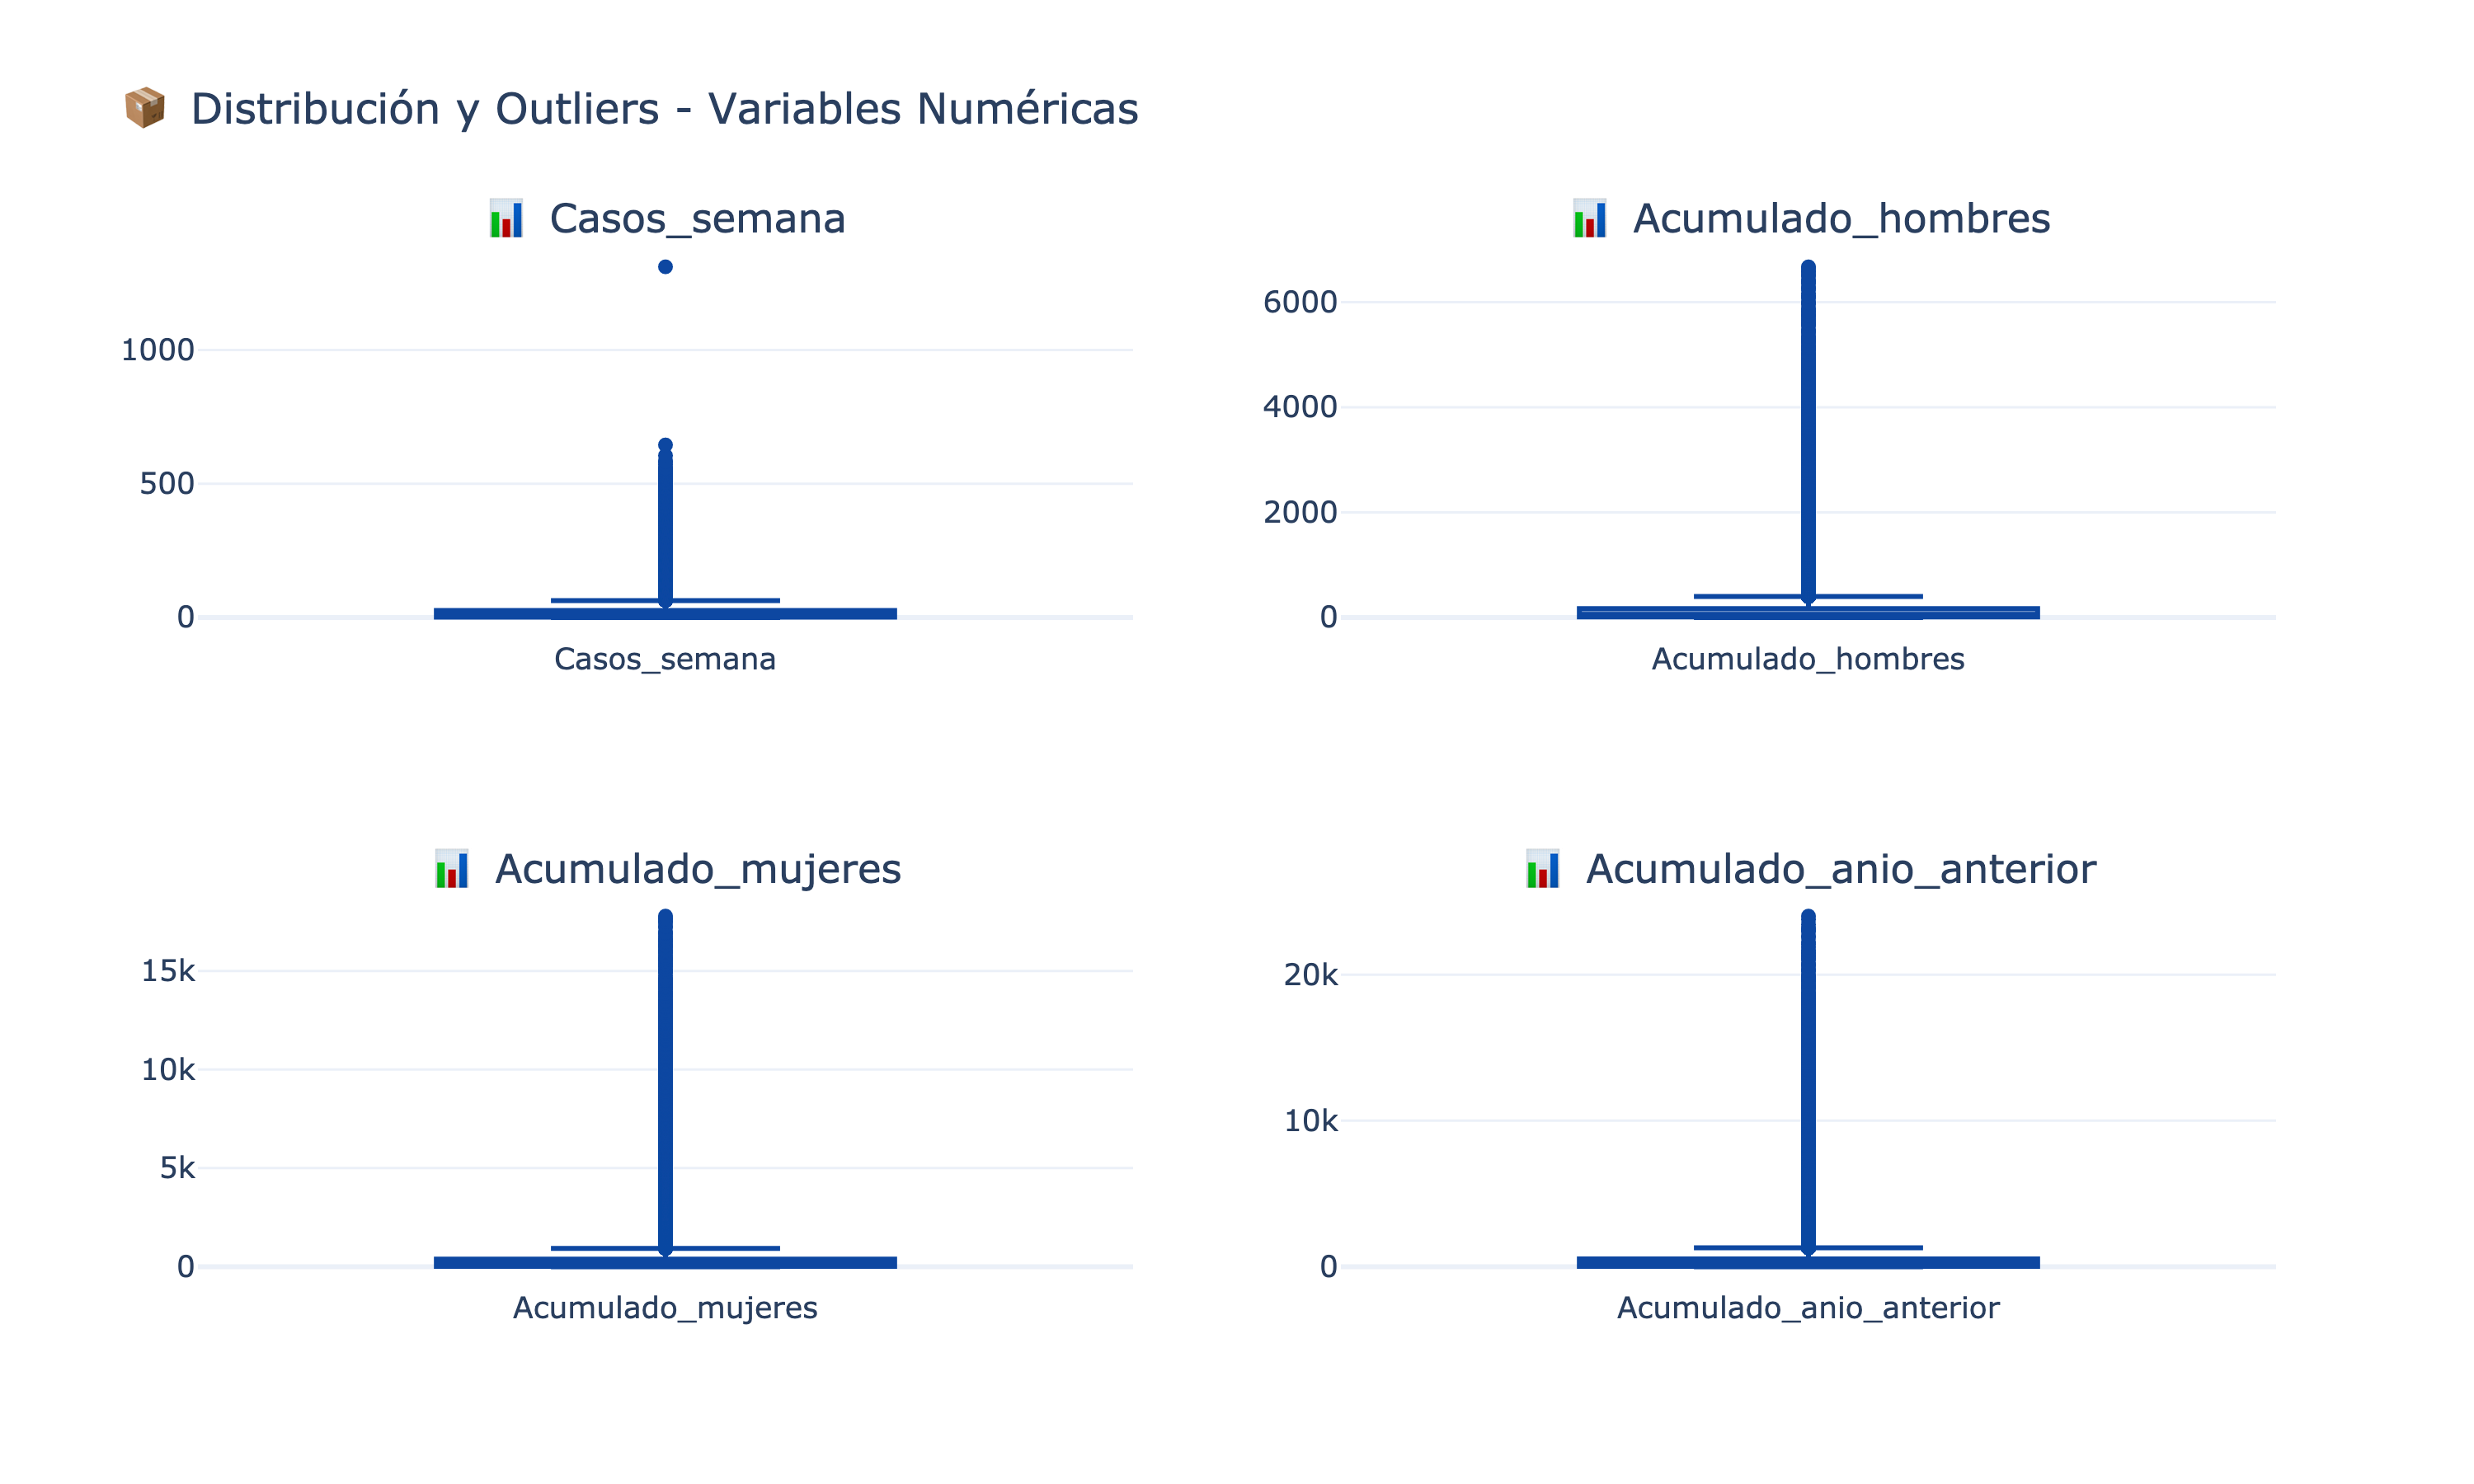

In [14]:
"""
Visualización de outliers con boxplots.
"""
# Crear subplots para todas las variables numéricas
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'📊 {col}' for col in NUMERIC_COLS if col in df.columns]
)

positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for idx, col in enumerate([c for c in NUMERIC_COLS if c in df.columns]):
    row, col_pos = positions[idx]
    fig.add_trace(
        go.Box(
            y=df[col],
            name=col,
            marker_color=COLORS['primary'],
            boxpoints='outliers'
        ),
        row=row, col=col_pos
    )

fig.update_layout(
    height=600,
    title_text='📦 Distribución y Outliers - Variables Numéricas',
    showlegend=False,
    template=PLOTLY_TEMPLATE
)

fig.show(config=PLOT_CONFIG)

In [15]:
"""
Análisis detallado de outliers extremos en Casos_semana.
"""
print("\n🔍 Outliers Extremos en 'Casos_semana':")
print("=" * 60)

# Identificar outliers extremos (> Q3 + 3*IQR)
Q1 = df['Casos_semana'].quantile(0.25)
Q3 = df['Casos_semana'].quantile(0.75)
IQR = Q3 - Q1

extreme_threshold = Q3 + 3 * IQR
extreme_outliers = df[df['Casos_semana'] > extreme_threshold]

print(f"\n• Umbral para outliers extremos: {extreme_threshold:,.0f} casos")
print(f"• Número de outliers extremos: {len(extreme_outliers):,}")

if len(extreme_outliers) > 0:
    print("\n📌 Top 10 valores extremos:")
    display(
        extreme_outliers.nlargest(10, 'Casos_semana')[['Anio', 'Semana', 'Entidad', 'Padecimiento', 'Casos_semana']]
    )


🔍 Outliers Extremos en 'Casos_semana':

• Umbral para outliers extremos: 101 casos
• Número de outliers extremos: 3,612

📌 Top 10 valores extremos:


Anio  Semana           Entidad Padecimiento  Casos_semana
48714  2023      39            México    Depresión       1311.00
52344  2024      25  Ciudad de México    Depresión        645.00
47640  2023      28  Ciudad de México    Depresión        605.00
56472  2025      16  Ciudad de México    Depresión        584.00
47256  2023      24  Ciudad de México    Depresión        582.00
47736  2023      29  Ciudad de México    Depresión        572.00
45432  2023       5  Ciudad de México    Depresión        559.00
51480  2024      16  Ciudad de México    Depresión        558.00
47064  2023      22  Ciudad de México    Depresión        556.00
50808  2024       9  Ciudad de México    Depresión        552.00

### 3.4 Consistencia de Datos

In [16]:
"""
Verificación de consistencia lógica de los datos.
"""
print("\n🔍 Validación de Consistencia:")
print("=" * 60)

# 1. Valores negativos (no deberían existir)
for col in NUMERIC_COLS:
    if col in df.columns:
        negativos = (df[col] < 0).sum()
        if negativos > 0:
            logger.warning(f"⚠️ {col}: {negativos} valores negativos encontrados")
        else:
            print(f"✅ {col}: Sin valores negativos")

# 2. Consistencia Acumulados: hombres + mujeres debería ser coherente
print("\n📌 Verificando coherencia de acumulados por sexo...")
df['Total_acumulado_sexo'] = df['Acumulado_hombres'] + df['Acumulado_mujeres']

# 3. Semanas válidas (01-53)
semanas_invalidas = df[~df['Semana'].astype(str).str.match(r'^(0[1-9]|[1-4][0-9]|5[0-3])$')]
if len(semanas_invalidas) > 0:
    logger.warning(f"⚠️ Semanas inválidas encontradas: {semanas_invalidas['Semana'].unique()}")
else:
    print("✅ Todas las semanas epidemiológicas son válidas")

# 4. Años coherentes
anios_validos = range(2010, 2030)
anios_invalidos = df[~df['Anio'].isin(anios_validos)]
if len(anios_invalidos) > 0:
    logger.warning(f"⚠️ Años inválidos: {anios_invalidos['Anio'].unique()}")
else:
    print("✅ Todos los años están en rango válido")

2026-01-28 10:17:18.020 | WARNING  | __main__:<module>:23 - ⚠️ Semanas inválidas encontradas: [2 3 4 5 6 7 8 9 1]



🔍 Validación de Consistencia:
✅ Casos_semana: Sin valores negativos
✅ Acumulado_hombres: Sin valores negativos
✅ Acumulado_mujeres: Sin valores negativos
✅ Acumulado_anio_anterior: Sin valores negativos

📌 Verificando coherencia de acumulados por sexo...
✅ Todos los años están en rango válido


---
## 4. 📈 Estadísticas Descriptivas

In [17]:
"""
Estadísticas descriptivas extendidas para variables numéricas.
"""
print("\n📊 Estadísticas Descriptivas - Variables Numéricas:")
print("=" * 70)

# Estadísticas básicas con pandas describe
desc_stats = df[NUMERIC_COLS].describe(percentiles=[.05, .25, .5, .75, .95])
display(desc_stats.round(2))


📊 Estadísticas Descriptivas - Variables Numéricas:


Casos_semana  Acumulado_hombres  Acumulado_mujeres  \
count      60285.00           60288.00           60288.00   
mean          24.91             188.93             492.09   
std           52.76             439.73            1223.06   
min            0.00               0.00               0.00   
5%             0.00               1.00               2.00   
25%            1.00              10.00              13.00   
50%            4.00              40.00              47.00   
75%           26.00             165.00             379.00   
95%          113.00             867.00            2430.00   
max         1311.00            6671.00           17782.00   

       Acumulado_anio_anterior  
count                 55200.00  
mean                    668.17  
std                    1625.79  
min                       0.00  
5%                        3.00  
25%                      24.00  
50%                      89.00  
75%                     530.25  
95%                    3207.00  
max                   24017.00

In [18]:
"""
Estadísticas extendidas personalizadas.
"""
extended_stats = []

for col in NUMERIC_COLS:
    if col in df.columns:
        stats_dict = calculate_extended_stats(df[col])
        stats_dict['Variable'] = col
        extended_stats.append(stats_dict)

extended_stats_df = pd.DataFrame(extended_stats)
extended_stats_df = extended_stats_df[['Variable', 'count', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'iqr', 'skewness', 'kurtosis', 'cv']]

print("\n📊 Estadísticas Extendidas:")
display(extended_stats_df.round(2))

# Interpretación de sesgo
print("\n📌 Interpretación del Sesgo (Skewness):")
for _, row in extended_stats_df.iterrows():
    skew = row['skewness']
    if abs(skew) < 0.5:
        interpretacion = "Aproximadamente simétrica"
    elif skew > 0:
        interpretacion = "Sesgada a la derecha (cola derecha más larga)"
    else:
        interpretacion = "Sesgada a la izquierda (cola izquierda más larga)"
    print(f"   • {row['Variable']}: {interpretacion} (skew={skew:.2f})")


📊 Estadísticas Extendidas:


Variable  count   mean     std  min    q1  median     q3  \
0             Casos_semana  60285  24.91   52.76 0.00  1.00    4.00  26.00   
1        Acumulado_hombres  60288 188.93  439.73 0.00 10.00   40.00 165.00   
2        Acumulado_mujeres  60288 492.09 1223.06 0.00 13.00   47.00 379.00   
3  Acumulado_anio_anterior  55200 668.17 1625.79 0.00 24.00   89.00 530.25   

       max    iqr  skewness  kurtosis     cv  
0  1311.00  25.00      4.55     31.48 211.81  
1  6671.00 155.00      5.79     48.11 232.74  
2 17782.00 366.00      5.53     44.37 248.55  
3 24017.00 506.25      5.54     43.89 243.32


📌 Interpretación del Sesgo (Skewness):
   • Casos_semana: Sesgada a la derecha (cola derecha más larga) (skew=4.55)
   • Acumulado_hombres: Sesgada a la derecha (cola derecha más larga) (skew=5.79)
   • Acumulado_mujeres: Sesgada a la derecha (cola derecha más larga) (skew=5.53)
   • Acumulado_anio_anterior: Sesgada a la derecha (cola derecha más larga) (skew=5.54)


In [19]:
"""
Pruebas de normalidad.
"""
print("\n📊 Pruebas de Normalidad (Shapiro-Wilk):")
print("=" * 60)

normality_results = []

for col in NUMERIC_COLS:
    if col in df.columns:
        result = test_normality(df[col])
        normality_results.append({
            'Variable': col,
            'Estadístico': result['statistic'],
            'P-valor': result['p_value'],
            'Es Normal': result['is_normal'],
            'Interpretación': result['interpretation']
        })

normality_df = pd.DataFrame(normality_results)
display(normality_df)

print("\n💡 Nota: p-valor < 0.05 indica que la distribución NO es normal")
print("   Esto sugiere considerar transformaciones (log, Box-Cox) para el modelado.")


📊 Pruebas de Normalidad (Shapiro-Wilk):


Variable  Estadístico  P-valor  Es Normal Interpretación
0             Casos_semana         0.50     0.00      False      No Normal
1        Acumulado_hombres         0.45     0.00      False      No Normal
2        Acumulado_mujeres         0.45     0.00      False      No Normal
3  Acumulado_anio_anterior         0.42     0.00      False      No Normal


💡 Nota: p-valor < 0.05 indica que la distribución NO es normal
   Esto sugiere considerar transformaciones (log, Box-Cox) para el modelado.


In [20]:
"""
Cardinalidad de variables categóricas.
"""
print("\n📊 Cardinalidad de Variables Categóricas:")
print("=" * 60)

for col in CATEGORICAL_COLS:
    if col in df.columns:
        n_unique = df[col].nunique()
        top_values = df[col].value_counts().head(5)
        print(f"\n📌 {col}:")
        print(f"   Valores únicos: {n_unique}")
        print(f"   Top 5 más frecuentes:")
        for val, count in top_values.items():
            pct = (count / len(df)) * 100
            print(f"      - {val}: {count:,} ({pct:.2f}%)")


📊 Cardinalidad de Variables Categóricas:

📌 Entidad:
   Valores únicos: 33
   Top 5 más frecuentes:
      - Aguascalientes: 1,884 (3.12%)
      - Nayarit: 1,884 (3.12%)
      - Zacatecas: 1,884 (3.12%)
      - Yucatán: 1,884 (3.12%)
      - Veracruz: 1,884 (3.12%)

📌 Padecimiento:
   Valores únicos: 3
   Top 5 más frecuentes:
      - Depresión: 20,096 (33.33%)
      - Parkinson: 20,096 (33.33%)
      - Alzheimer: 20,096 (33.33%)

📌 Semana:
   Valores únicos: 53
   Top 5 más frecuentes:
      - 2: 1,248 (2.07%)
      - 3: 1,152 (1.91%)
      - 30: 1,152 (1.91%)
      - 31: 1,152 (1.91%)
      - 32: 1,152 (1.91%)


---
## 5. 📊 Análisis Univariante

### 5.1 Distribución de Casos por Padecimiento

In [21]:
"""
Distribución de casos totales por padecimiento.
"""
casos_por_padecimiento = df.groupby('Padecimiento')['Casos_semana'].sum().reset_index()
casos_por_padecimiento.columns = ['Padecimiento', 'Total_Casos']
casos_por_padecimiento['Porcentaje'] = (casos_por_padecimiento['Total_Casos'] / casos_por_padecimiento['Total_Casos'].sum()) * 100
casos_por_padecimiento = casos_por_padecimiento.sort_values('Total_Casos', ascending=False)

print("\n📊 Total de Casos por Padecimiento:")
display(casos_por_padecimiento)


📊 Total de Casos por Padecimiento:


Padecimiento  Total_Casos  Porcentaje
1    Depresión   1386057.00       92.30
2    Parkinson     87162.00        5.80
0    Alzheimer     28450.00        1.89

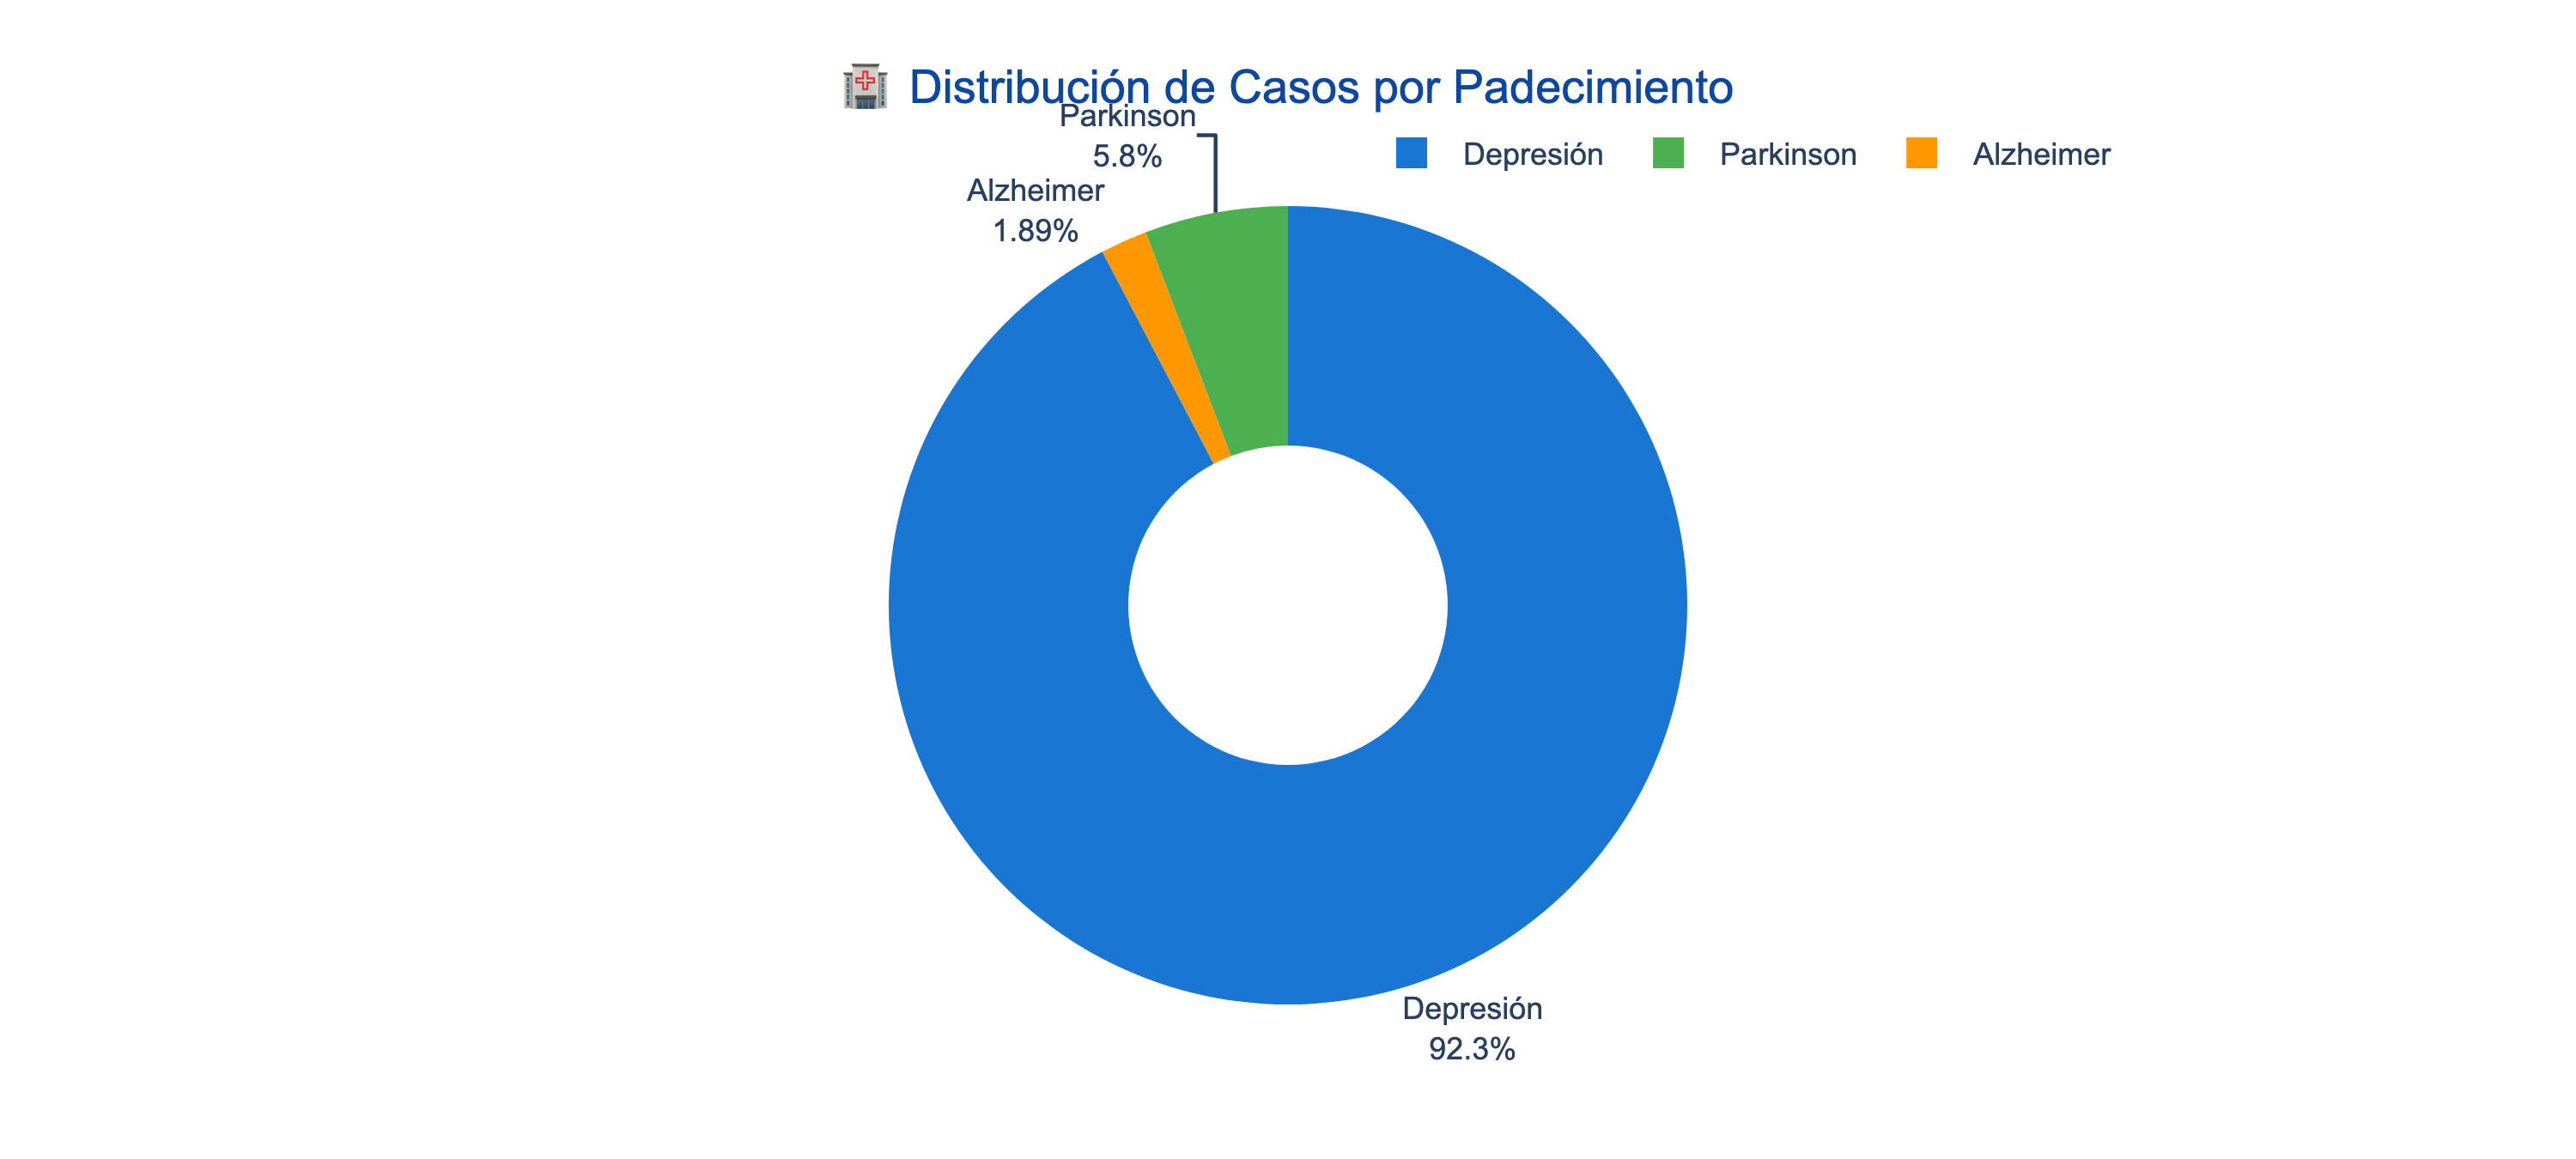

In [22]:
"""
Gráfico de pastel interactivo para distribución por padecimiento.
"""
fig = px.pie(
    casos_por_padecimiento,
    values='Total_Casos',
    names='Padecimiento',
    color='Padecimiento',
    color_discrete_map=DISEASE_COLORS,
    hole=0.4
)

fig.update_traces(
    textposition='outside',
    textinfo='percent+label',
    textfont_size=12
)

fig = style_plotly_figure(fig, '🏥 Distribución de Casos por Padecimiento', height=450)
fig.show(config=PLOT_CONFIG)

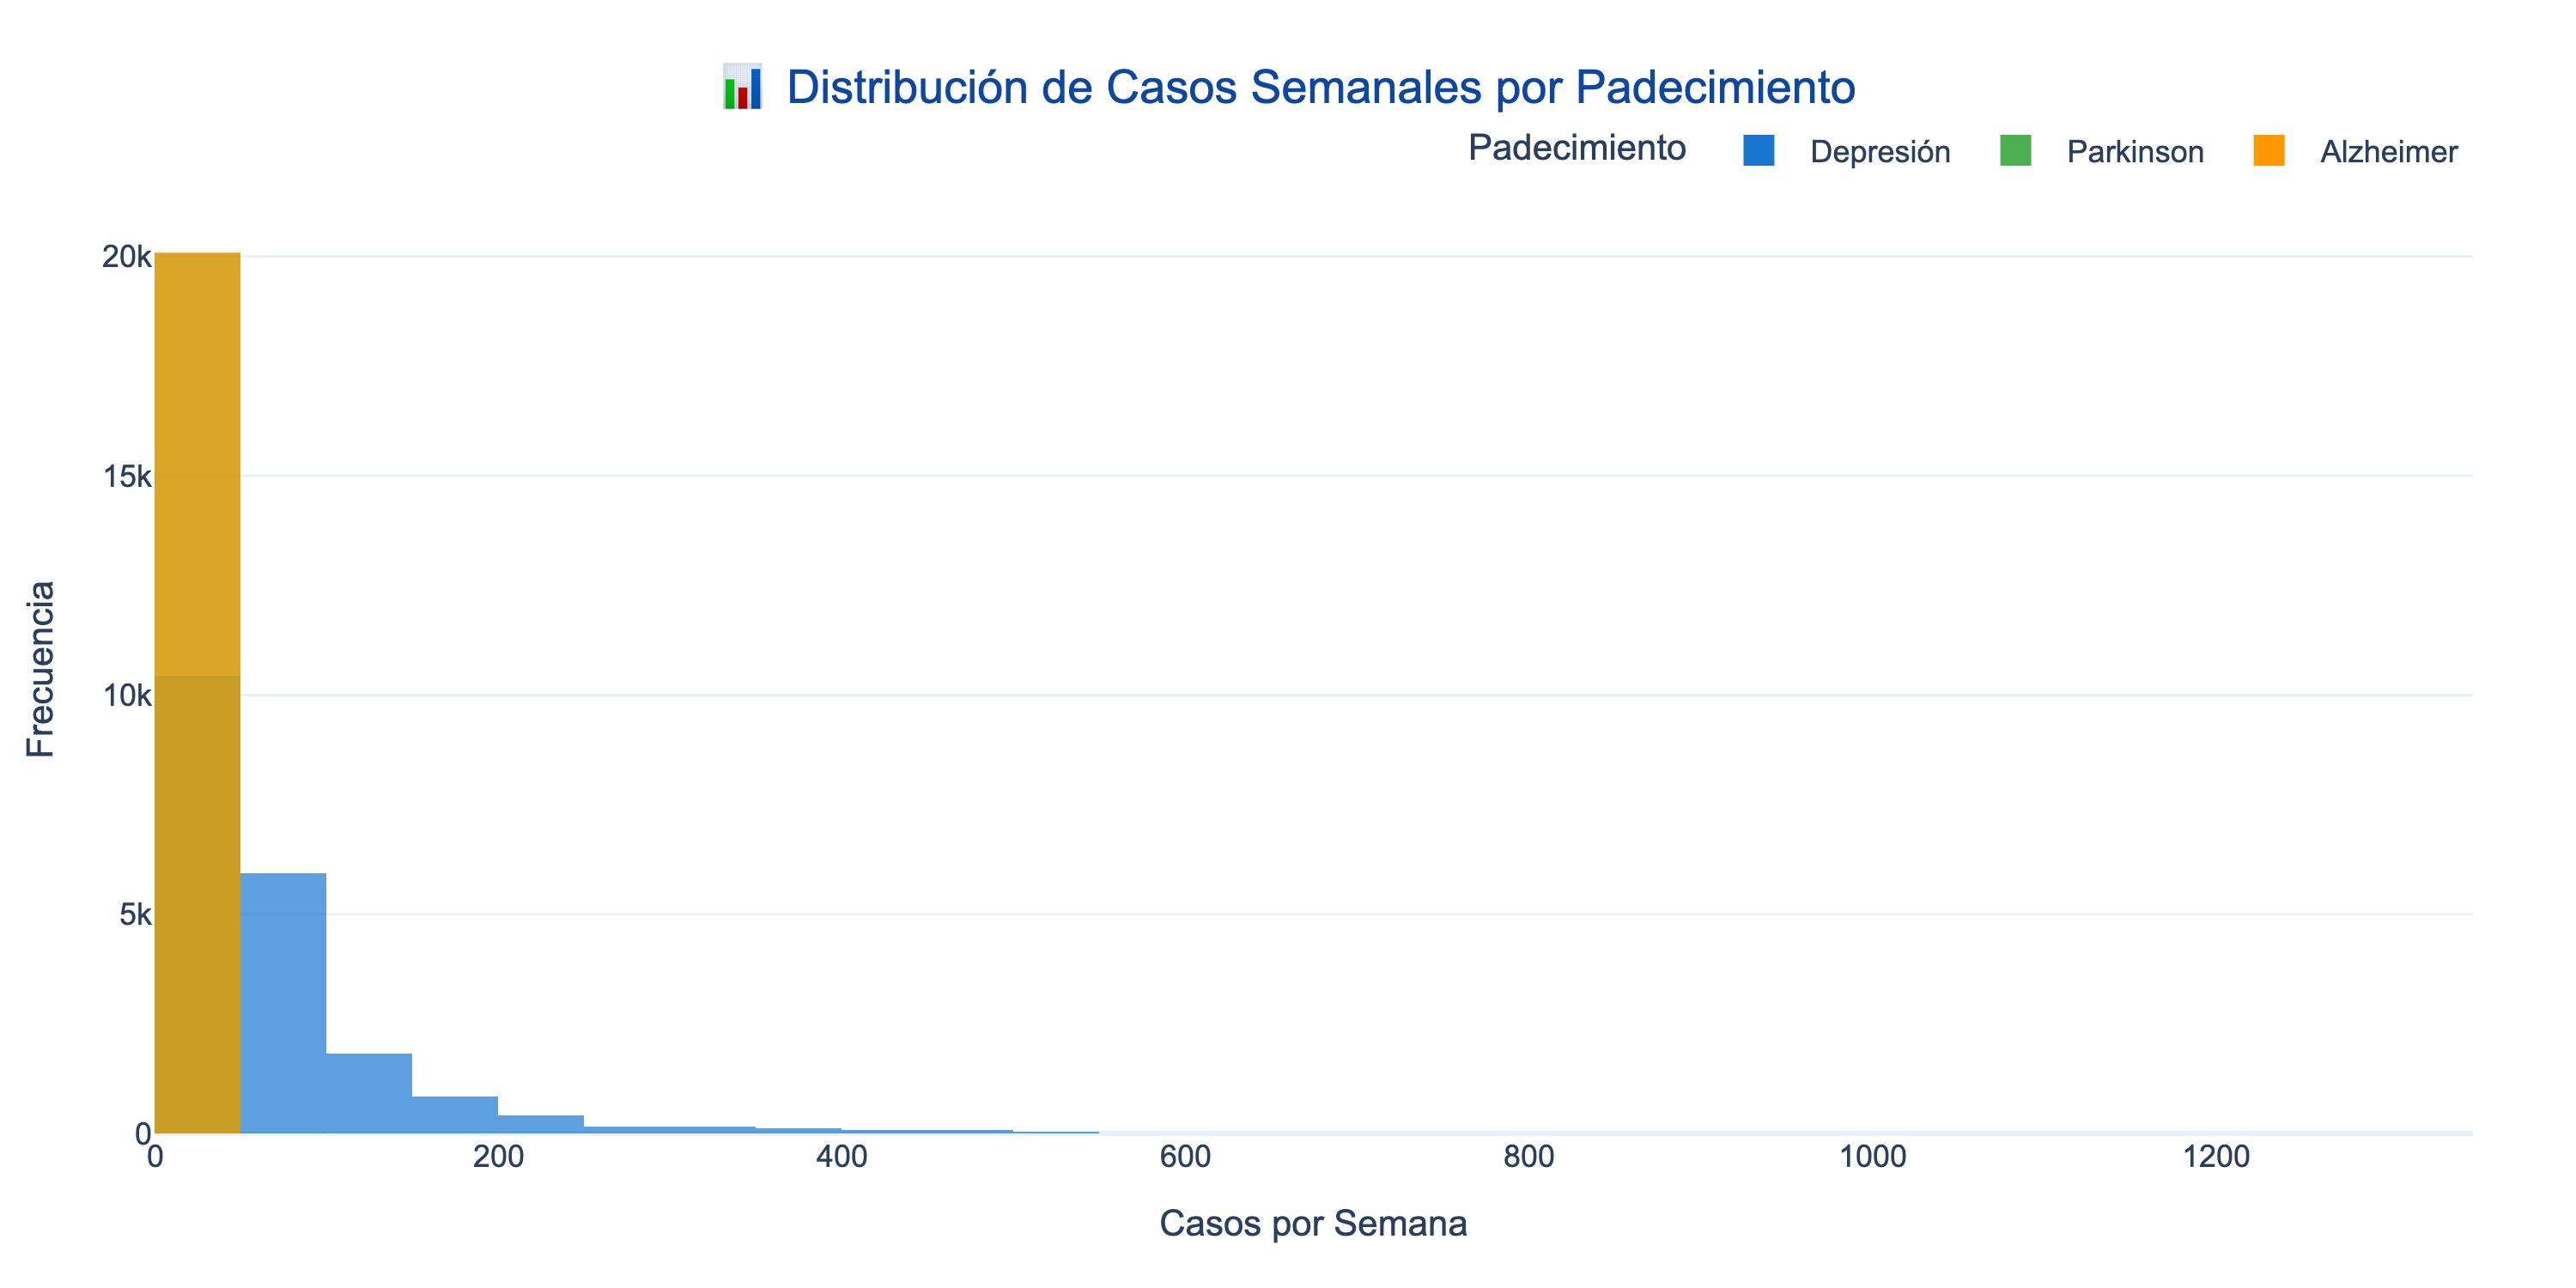

In [23]:
"""
Histograma de Casos_semana por padecimiento.
"""
fig = px.histogram(
    df,
    x='Casos_semana',
    color='Padecimiento',
    color_discrete_map=DISEASE_COLORS,
    nbins=50,
    opacity=0.7,
    barmode='overlay'
)

fig = style_plotly_figure(fig, '📊 Distribución de Casos Semanales por Padecimiento')
fig.update_layout(xaxis_title='Casos por Semana', yaxis_title='Frecuencia')
fig.show(config=PLOT_CONFIG)

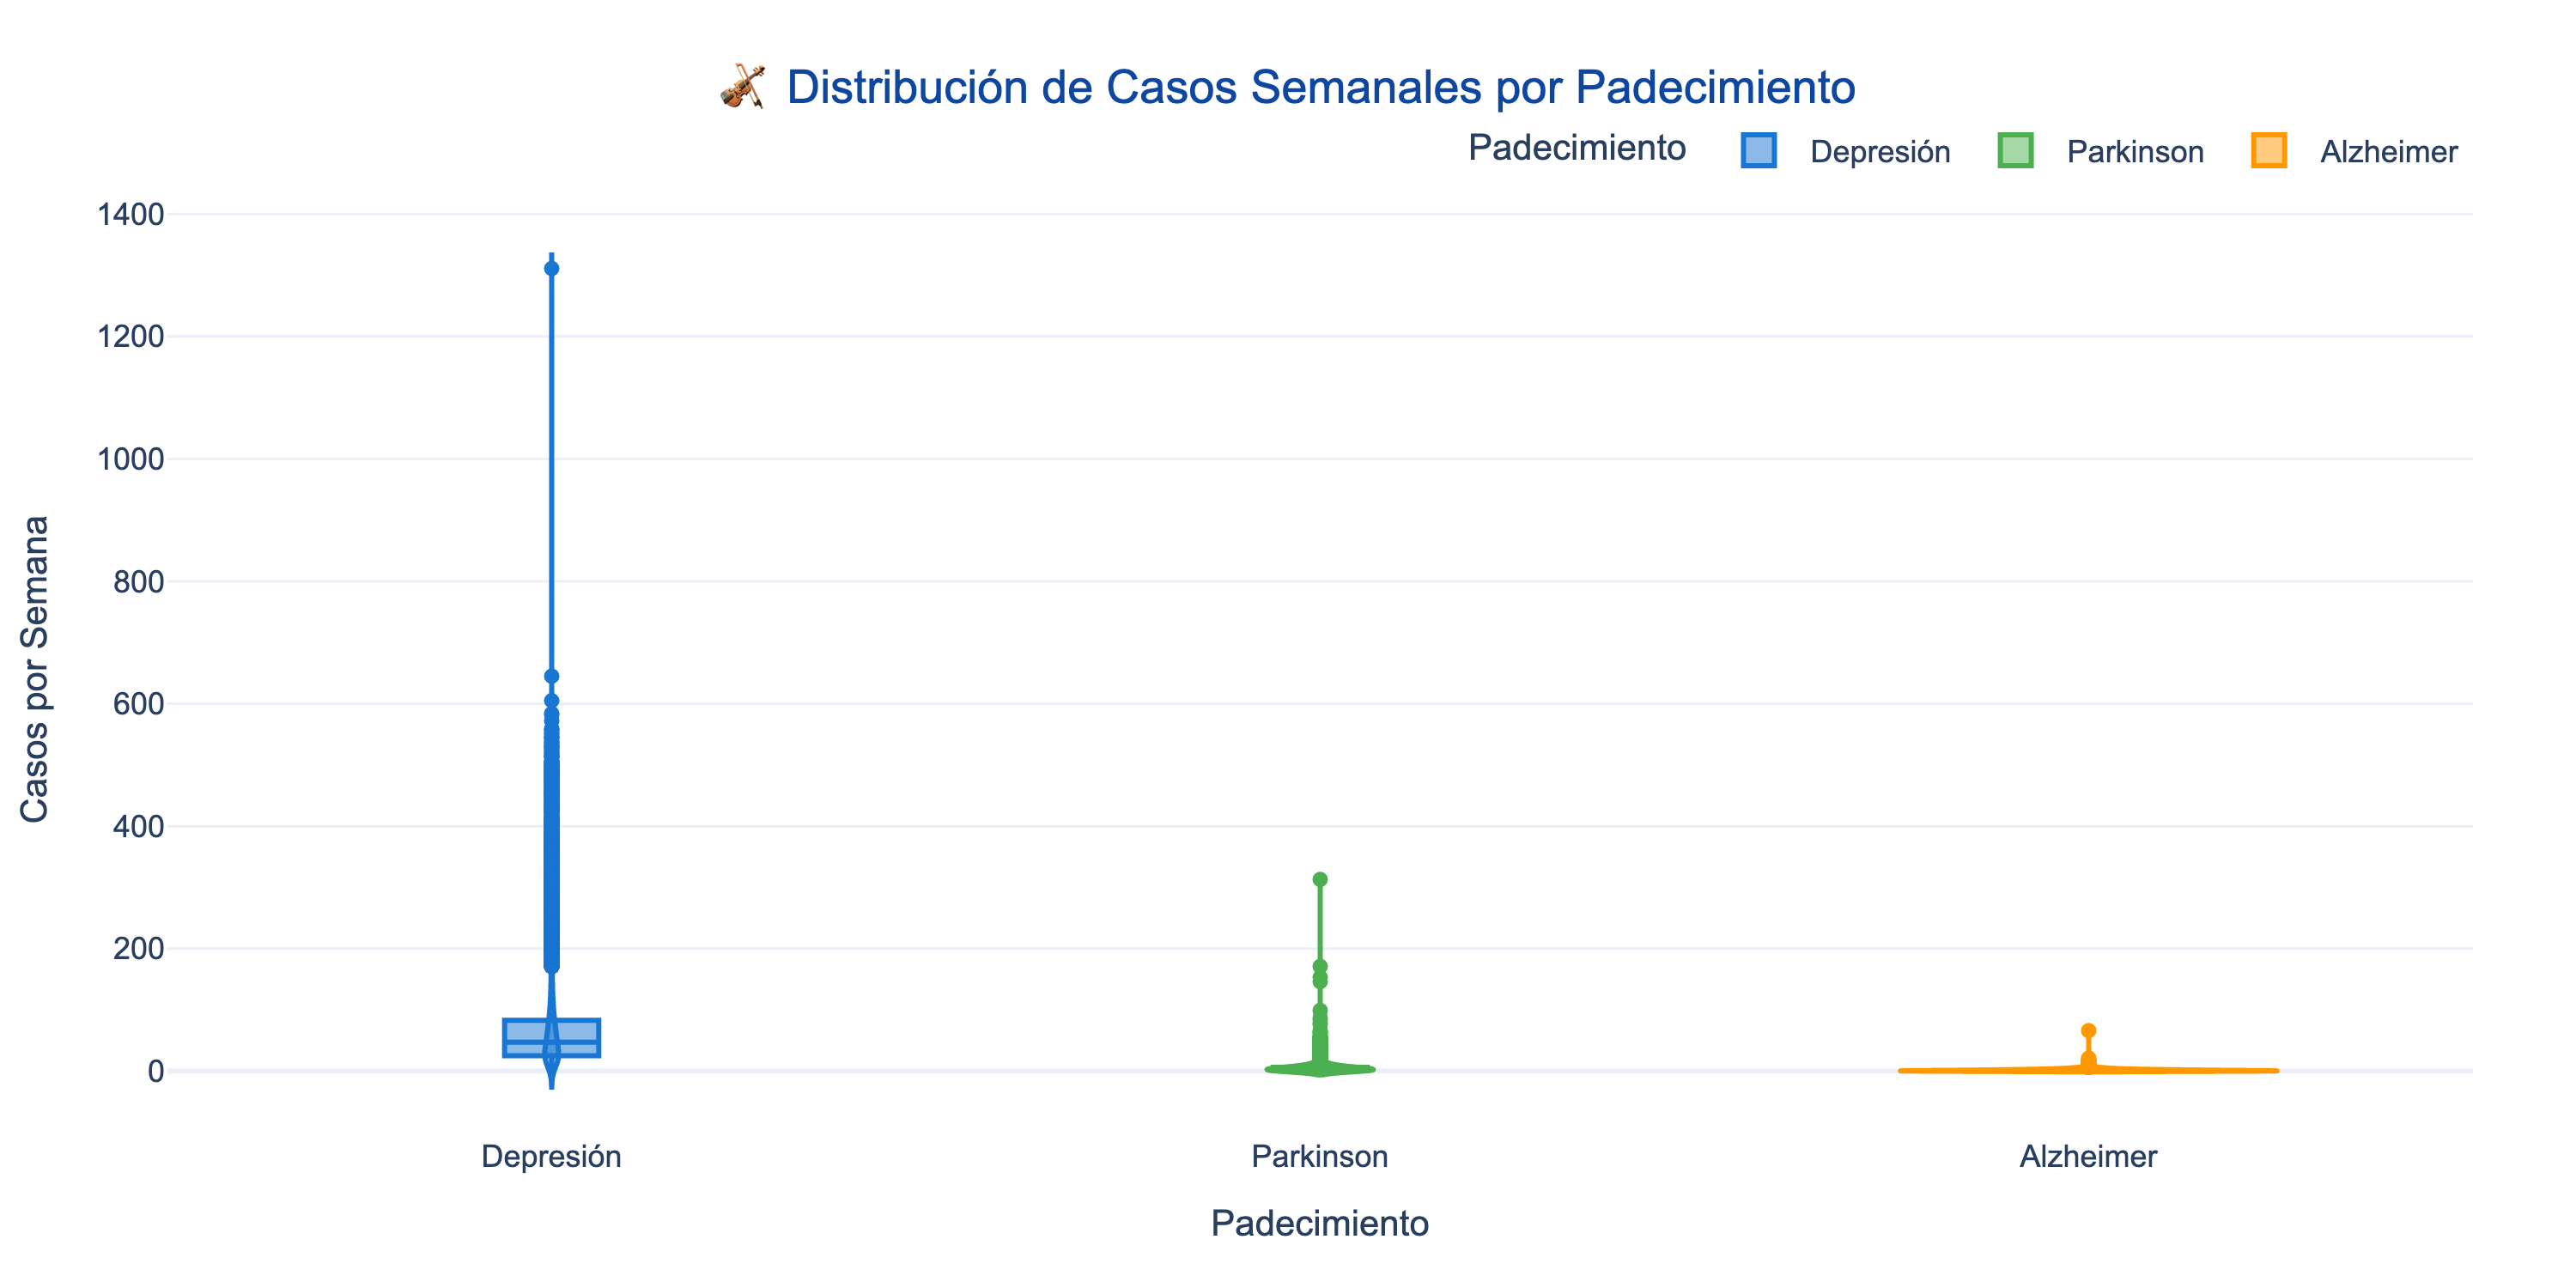

In [24]:
"""
Violin plots para distribución de casos por padecimiento.
"""
fig = create_violin_plot(
    df,
    'Casos_semana',
    'Padecimiento',
    '🎻 Distribución de Casos Semanales por Padecimiento'
)

fig.update_layout(yaxis_title='Casos por Semana')
fig.show(config=PLOT_CONFIG)

### 5.2 Distribución Temporal

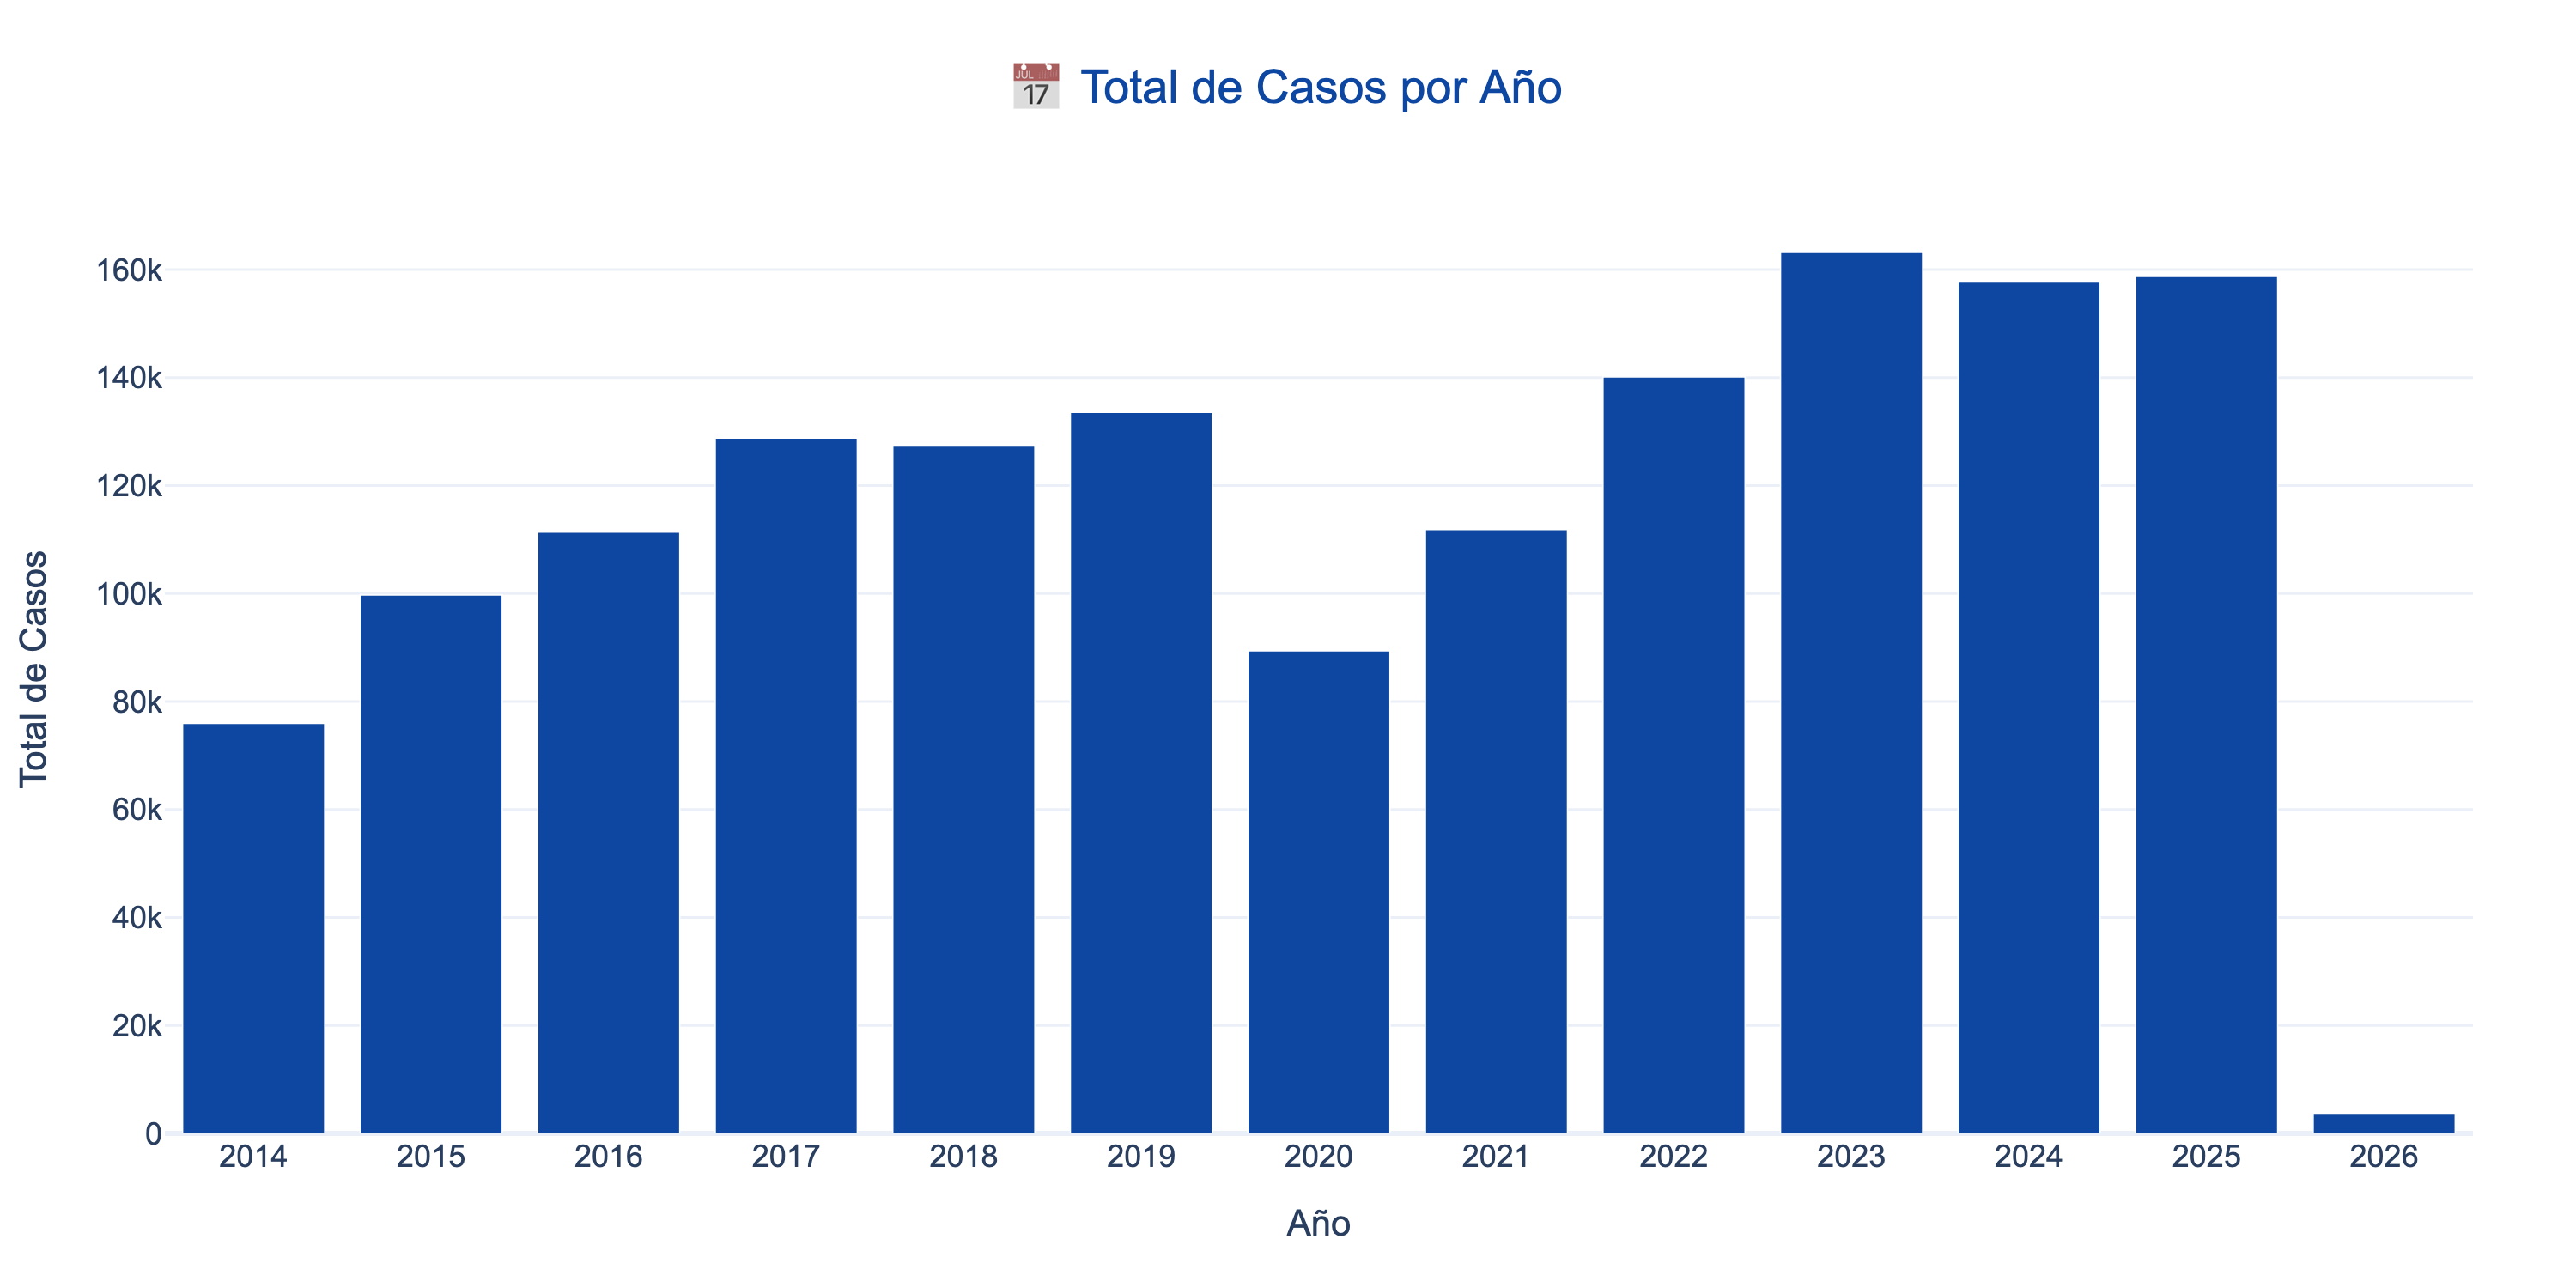

In [25]:
"""
Distribución de casos por año.
"""
casos_por_anio = df.groupby('Anio')['Casos_semana'].sum().reset_index()
casos_por_anio.columns = ['Año', 'Total_Casos']

fig = create_bar_chart(
    casos_por_anio,
    'Año',
    'Total_Casos',
    '📅 Total de Casos por Año'
)

fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Total de Casos',
    xaxis={'type': 'category'}
)
fig.show(config=PLOT_CONFIG)

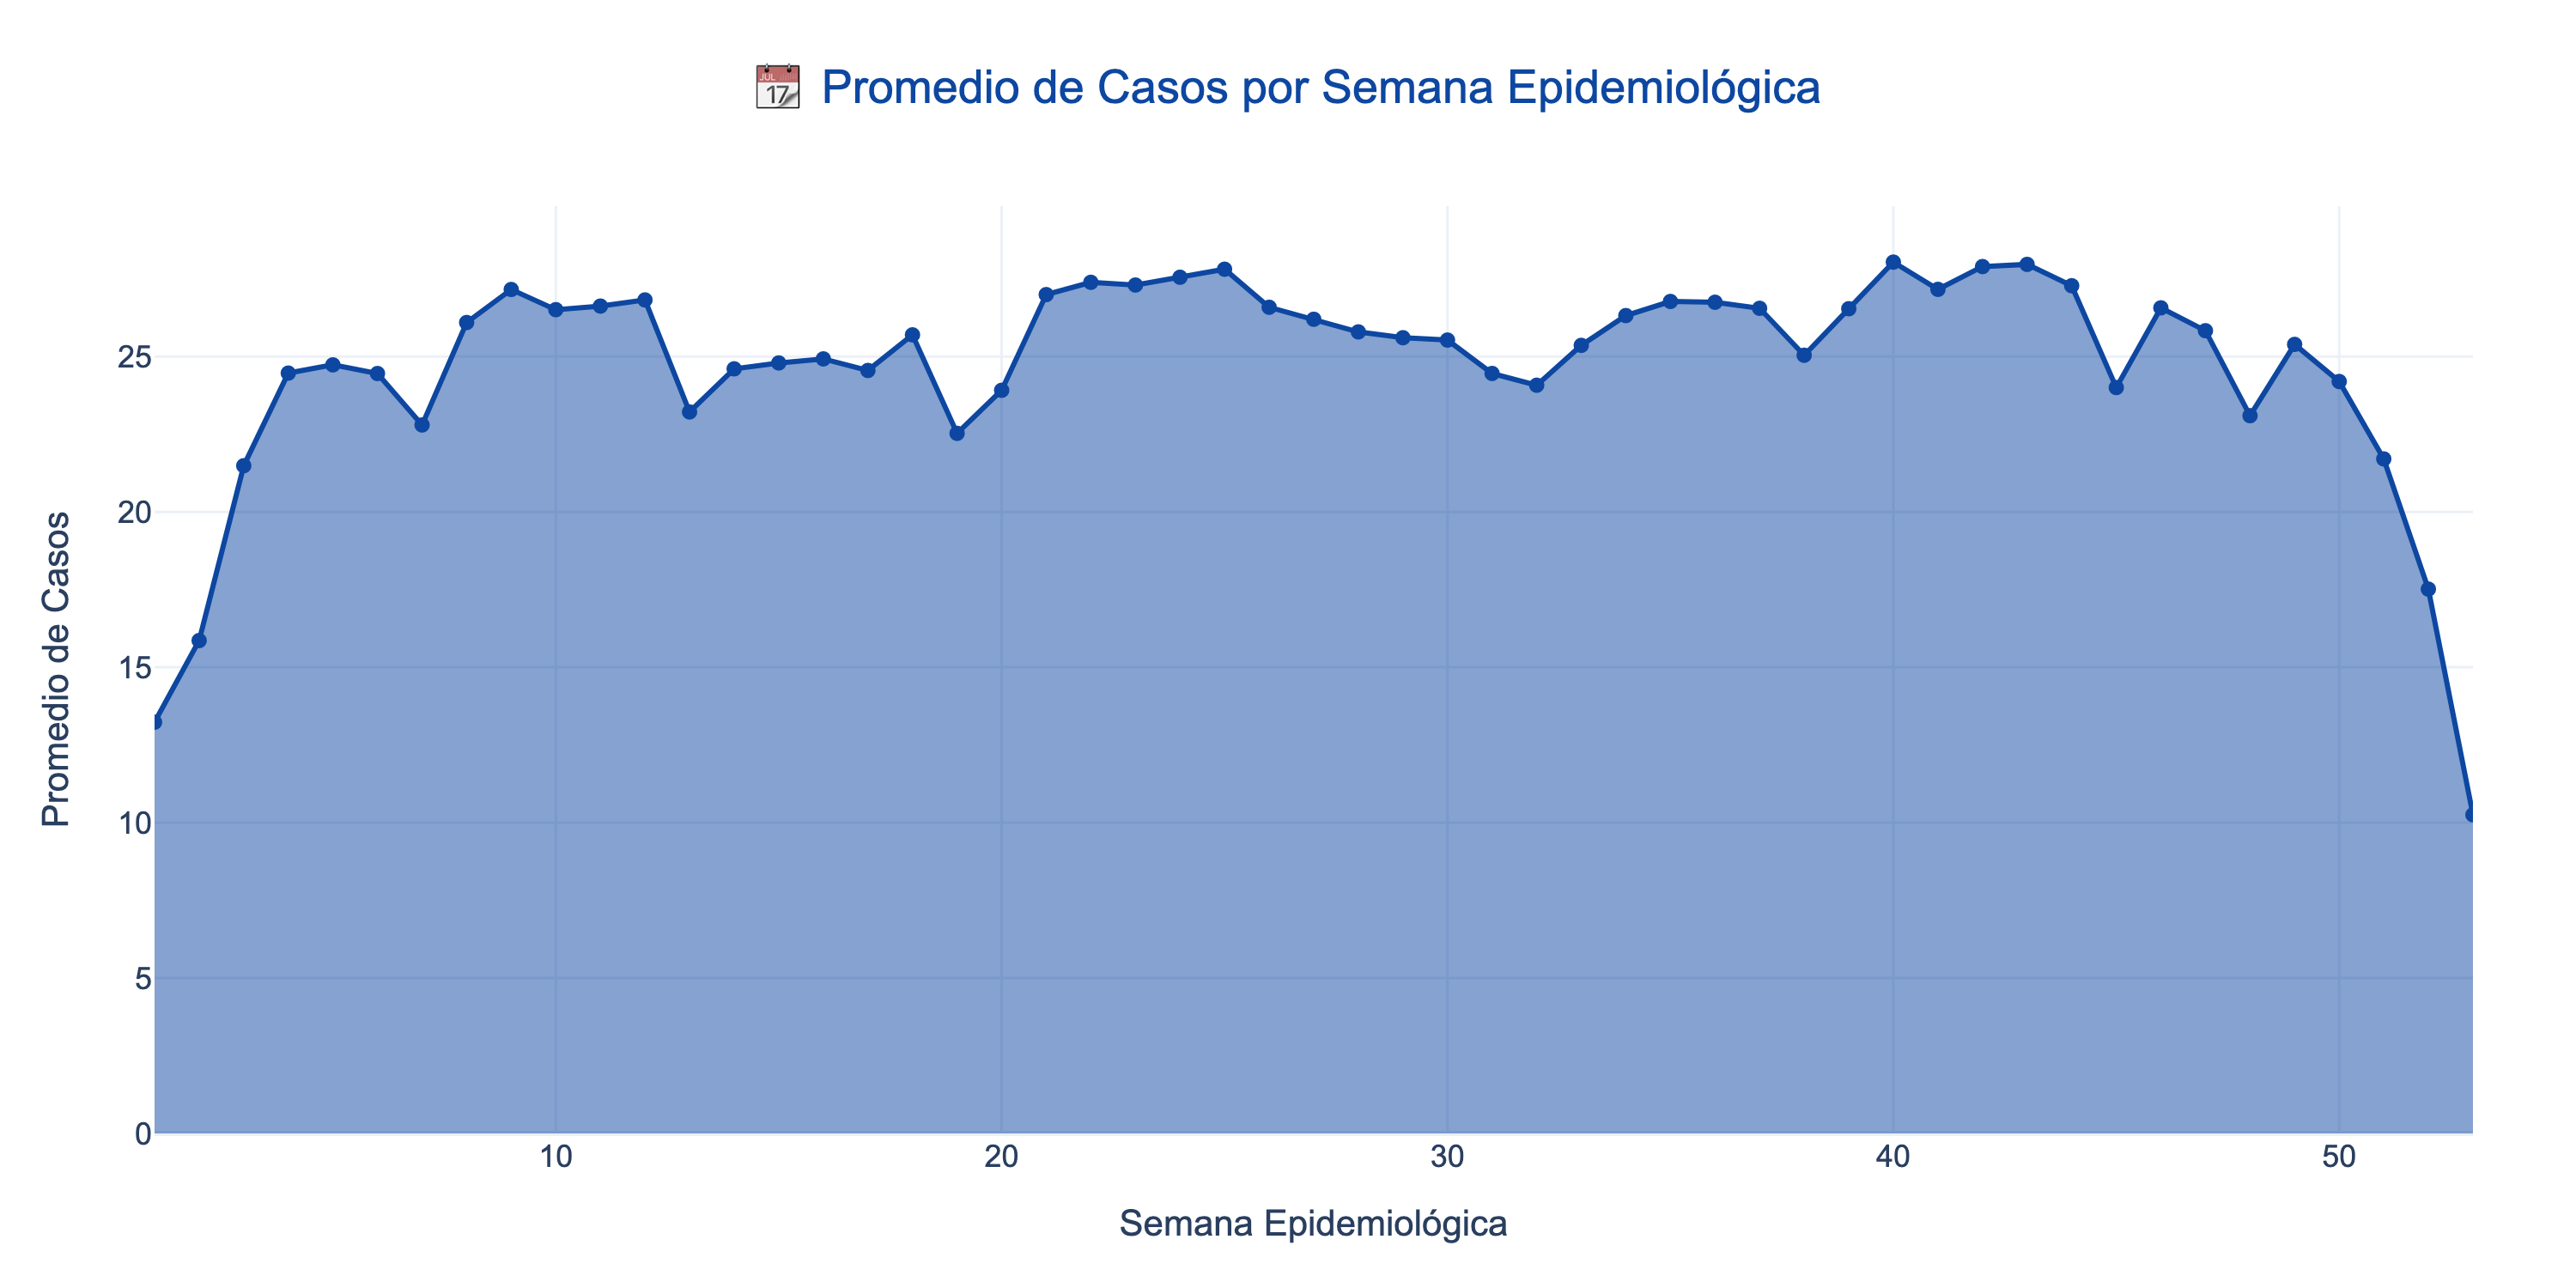

In [26]:
"""
Distribución de casos por semana epidemiológica (promedio anual).
"""
casos_por_semana = df.groupby('Semana')['Casos_semana'].mean().reset_index()
casos_por_semana.columns = ['Semana', 'Promedio_Casos']

fig = px.area(
    casos_por_semana,
    x='Semana',
    y='Promedio_Casos',
    markers=True
)

fig.update_traces(fill='tozeroy', line_color=COLORS['primary'])
fig = style_plotly_figure(fig, '📆 Promedio de Casos por Semana Epidemiológica')
fig.update_layout(
    xaxis_title='Semana Epidemiológica',
    yaxis_title='Promedio de Casos'
)
fig.show(config=PLOT_CONFIG)

### 5.3 Distribución Geográfica

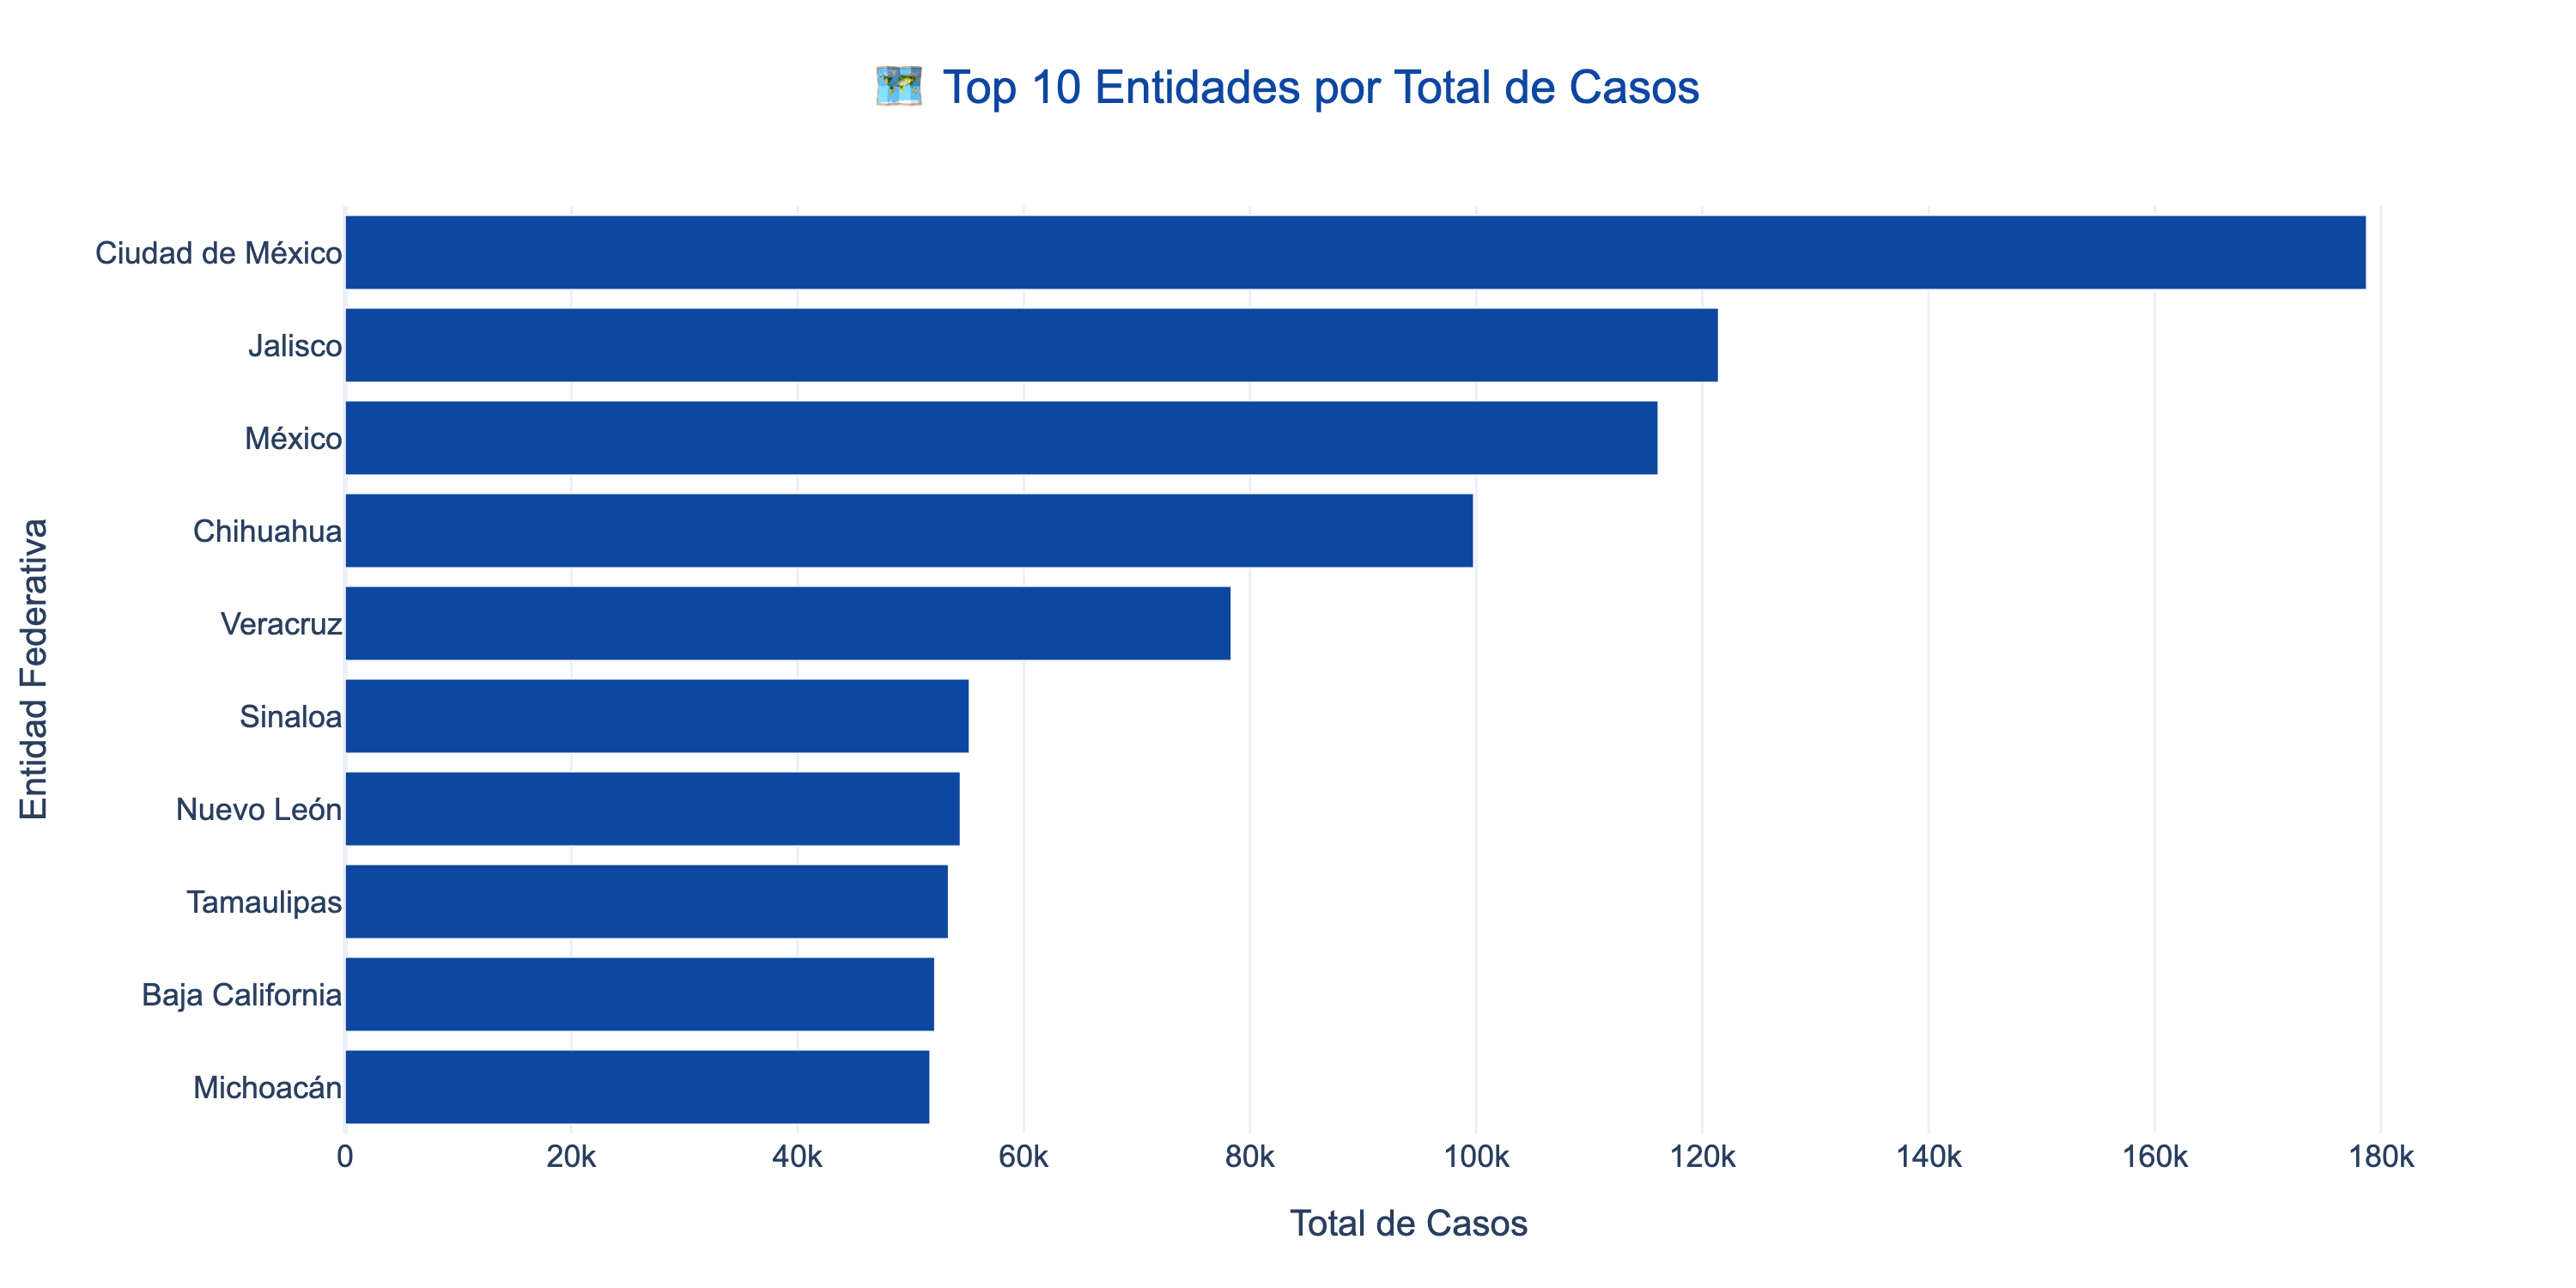

In [27]:
"""
Top 10 entidades por número total de casos.
"""
casos_por_entidad = df.groupby('Entidad')['Casos_semana'].sum().reset_index()
casos_por_entidad.columns = ['Entidad', 'Total_Casos']
casos_por_entidad = casos_por_entidad.sort_values('Total_Casos', ascending=True)

# Top 10
top_10_entidades = casos_por_entidad.tail(10)

fig = create_bar_chart(
    top_10_entidades,
    'Entidad',
    'Total_Casos',
    '🗺️ Top 10 Entidades por Total de Casos',
    orientation='h'
)

fig.update_layout(
    yaxis_title='Entidad Federativa',
    xaxis_title='Total de Casos',
    height=500
)
fig.show(config=PLOT_CONFIG)

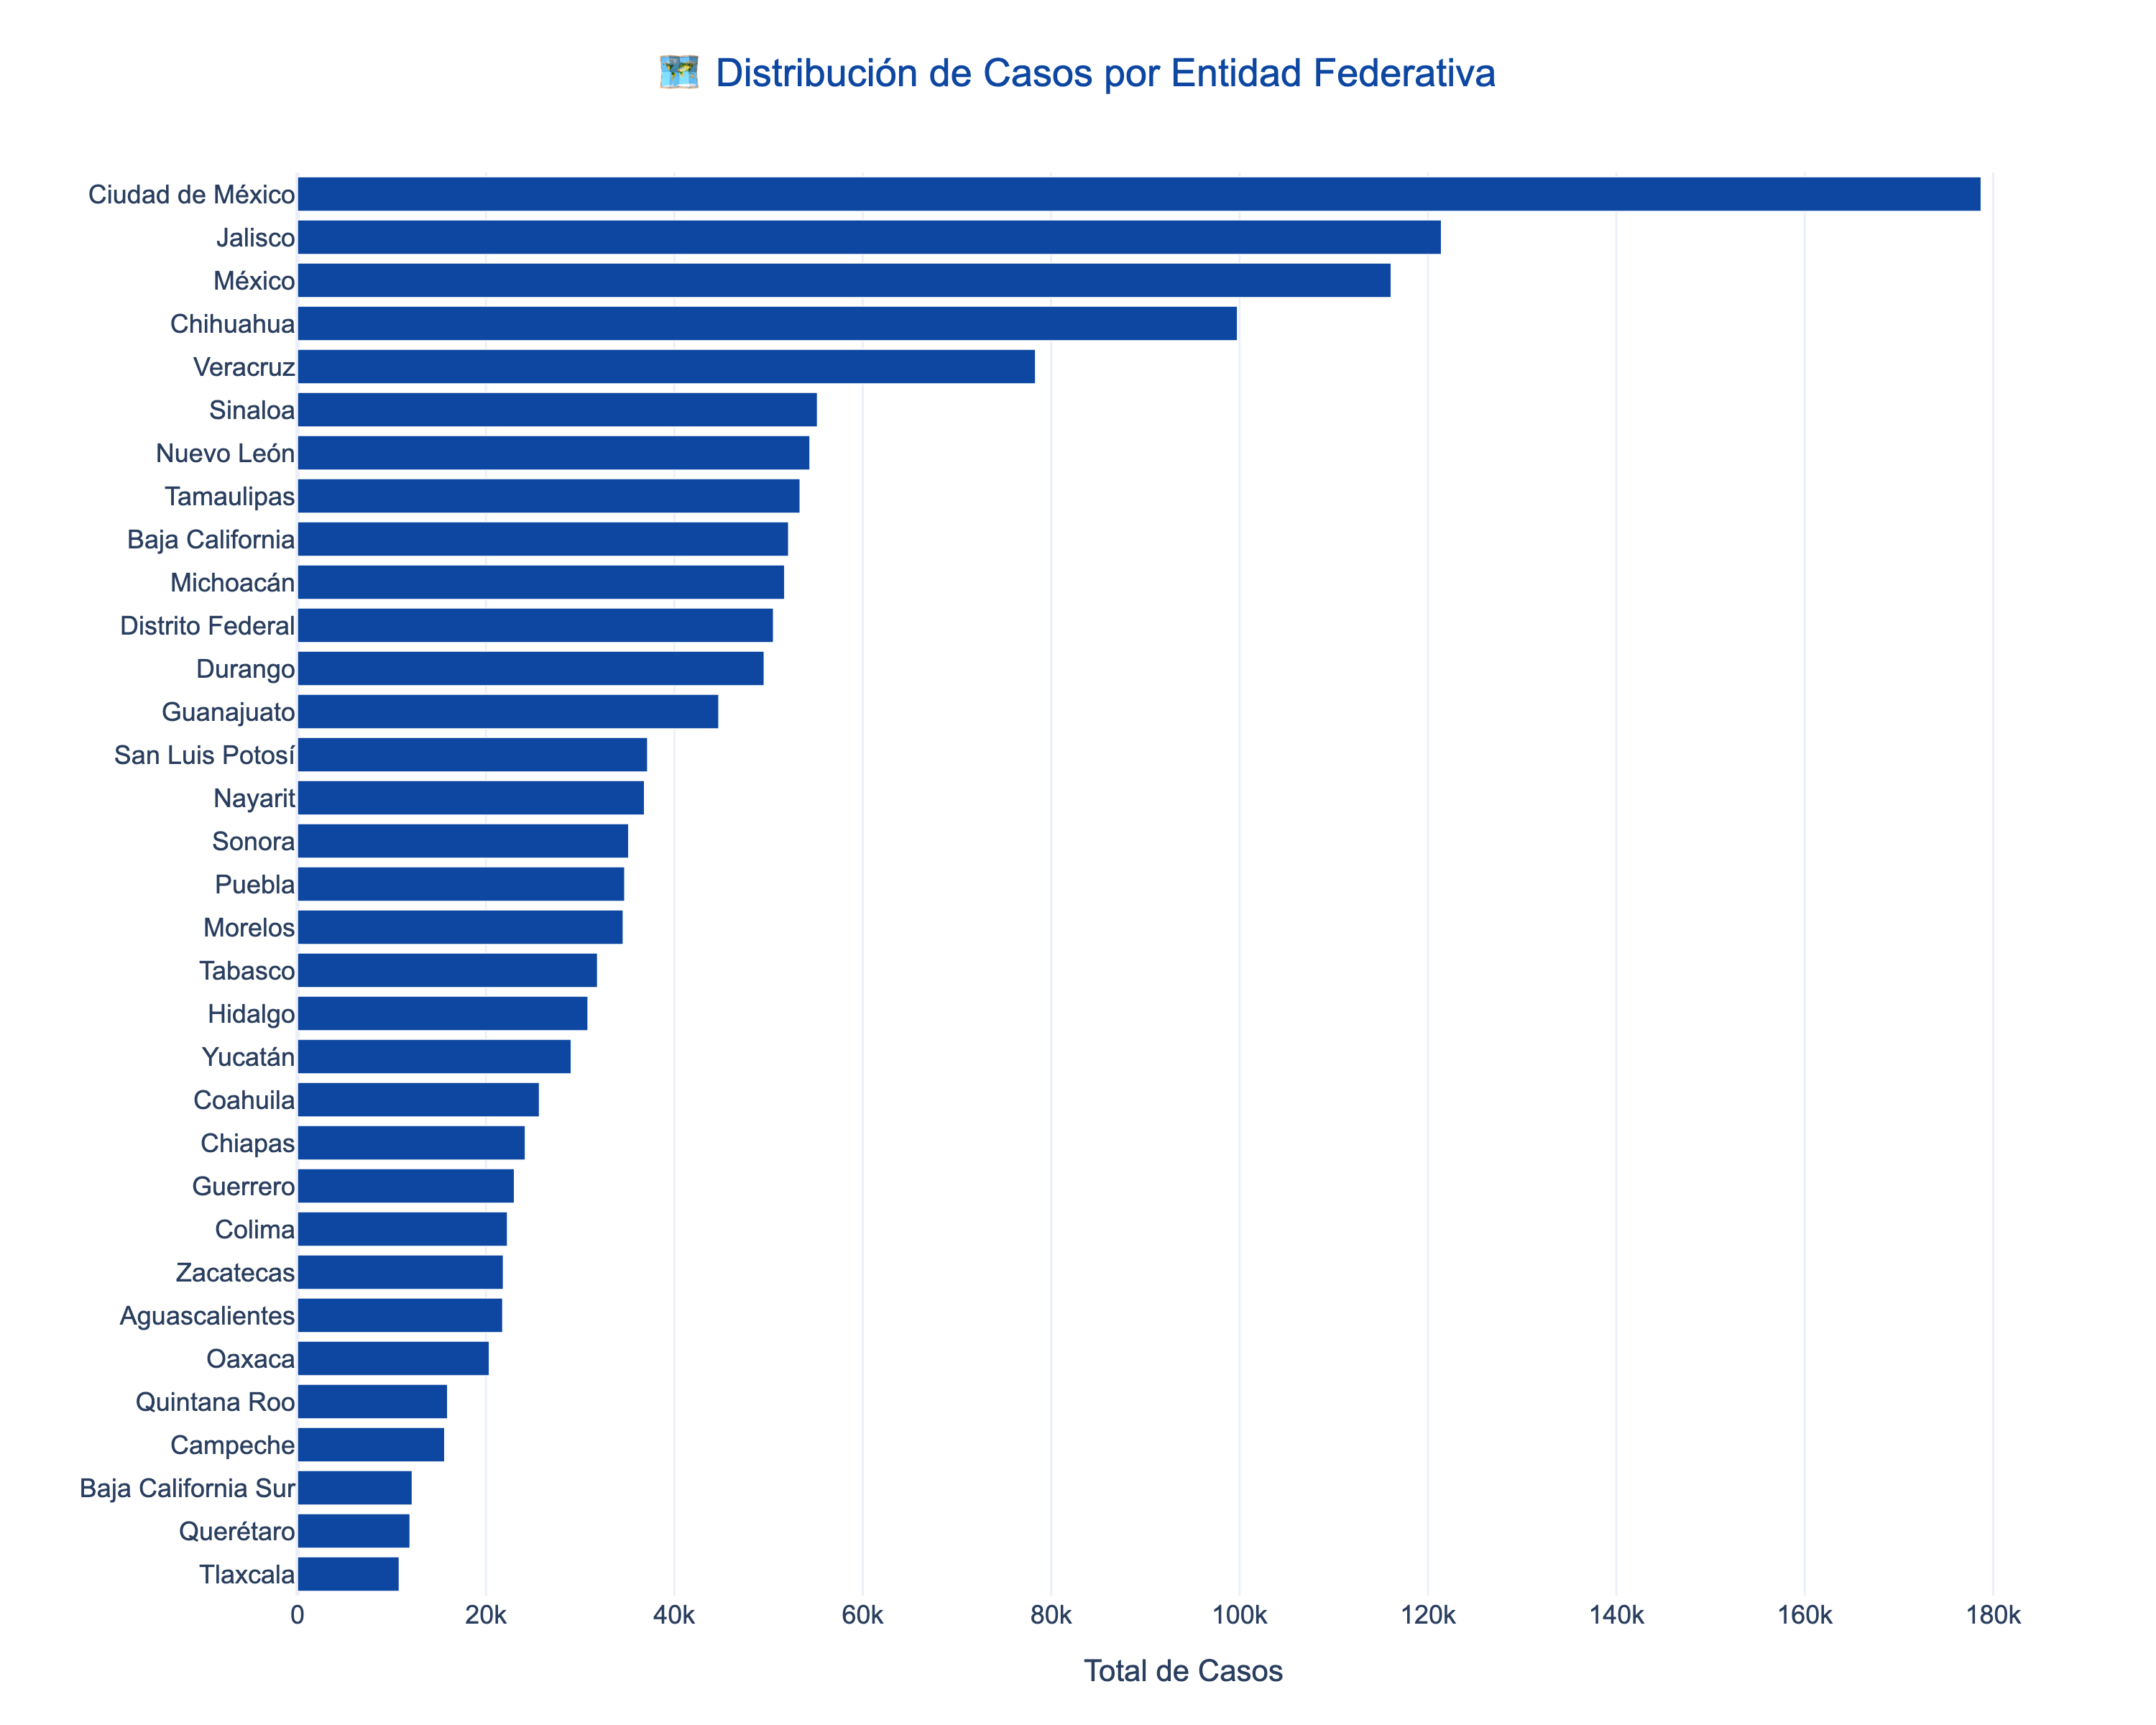

In [28]:
"""
Distribución completa por entidad (todas las 32).
"""
fig = create_bar_chart(
    casos_por_entidad,
    'Entidad',
    'Total_Casos',
    '🗺️ Distribución de Casos por Entidad Federativa',
    orientation='h'
)

fig.update_layout(
    yaxis_title='',
    xaxis_title='Total de Casos',
    height=800
)
fig.show(config=PLOT_CONFIG)

---
## 6. 🔗 Análisis Bivariante y Multivariante

### 6.1 Matriz de Correlación

In [29]:
"""
Matriz de correlación entre variables numéricas.
"""
correlation_matrix = df[NUMERIC_COLS].corr()

print("\n📊 Matriz de Correlación:")
display(correlation_matrix.round(3))


📊 Matriz de Correlación:


Casos_semana  Acumulado_hombres  Acumulado_mujeres  \
Casos_semana                     1.00               0.79               0.80   
Acumulado_hombres                0.79               1.00               0.99   
Acumulado_mujeres                0.80               0.99               1.00   
Acumulado_anio_anterior          0.77               0.97               0.97   

                         Acumulado_anio_anterior  
Casos_semana                                0.77  
Acumulado_hombres                           0.97  
Acumulado_mujeres                           0.97  
Acumulado_anio_anterior                     1.00

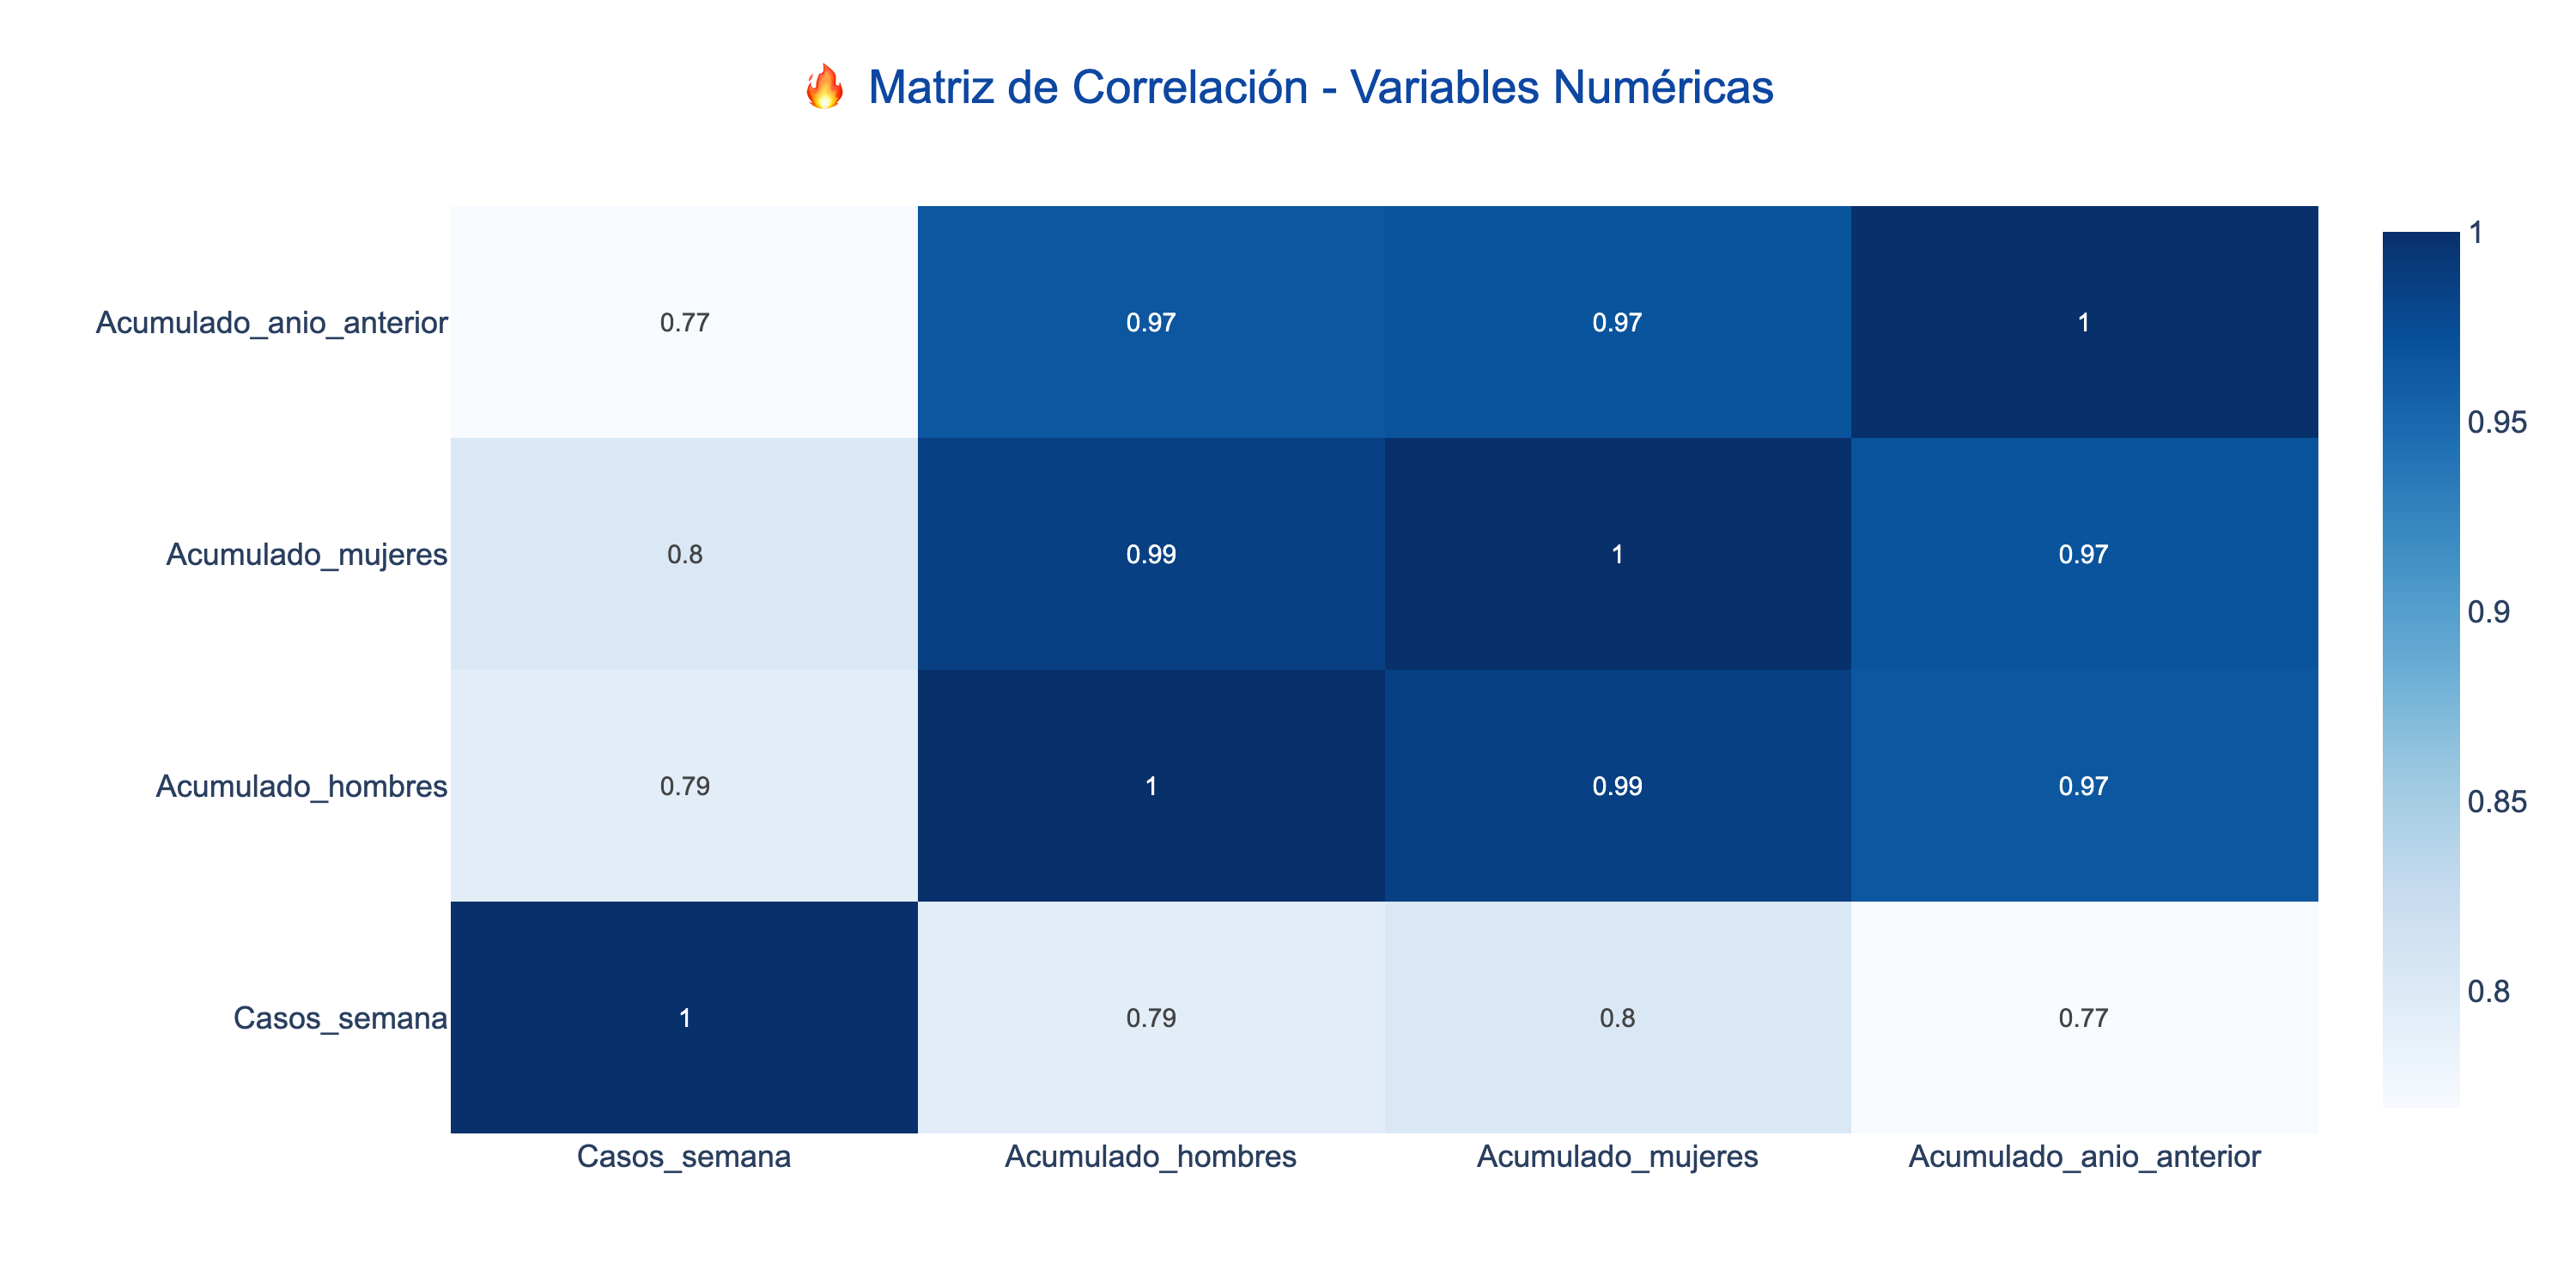

In [30]:
"""
Heatmap de correlación interactivo.
"""
fig = create_heatmap(
    correlation_matrix,
    '🔥 Matriz de Correlación - Variables Numéricas'
)

fig.show(config=PLOT_CONFIG)

### 6.2 Análisis por Sexo

In [31]:
"""
Comparación de casos acumulados por sexo y padecimiento.
"""
# Agregar por padecimiento
sexo_por_padecimiento = df.groupby('Padecimiento').agg({
    'Acumulado_hombres': 'sum',
    'Acumulado_mujeres': 'sum'
}).reset_index()

# Transformar a formato largo para visualización
sexo_long = pd.melt(
    sexo_por_padecimiento,
    id_vars=['Padecimiento'],
    value_vars=['Acumulado_hombres', 'Acumulado_mujeres'],
    var_name='Sexo',
    value_name='Total_Casos'
)

sexo_long['Sexo'] = sexo_long['Sexo'].map({
    'Acumulado_hombres': 'Hombres',
    'Acumulado_mujeres': 'Mujeres'
})

print("\n📊 Casos Acumulados por Sexo y Padecimiento:")
display(sexo_por_padecimiento)


📊 Casos Acumulados por Sexo y Padecimiento:


Padecimiento  Acumulado_hombres  Acumulado_mujeres
0    Alzheimer             313543             466741
1    Depresión            9811125           28058936
2    Parkinson            1265615            1141186

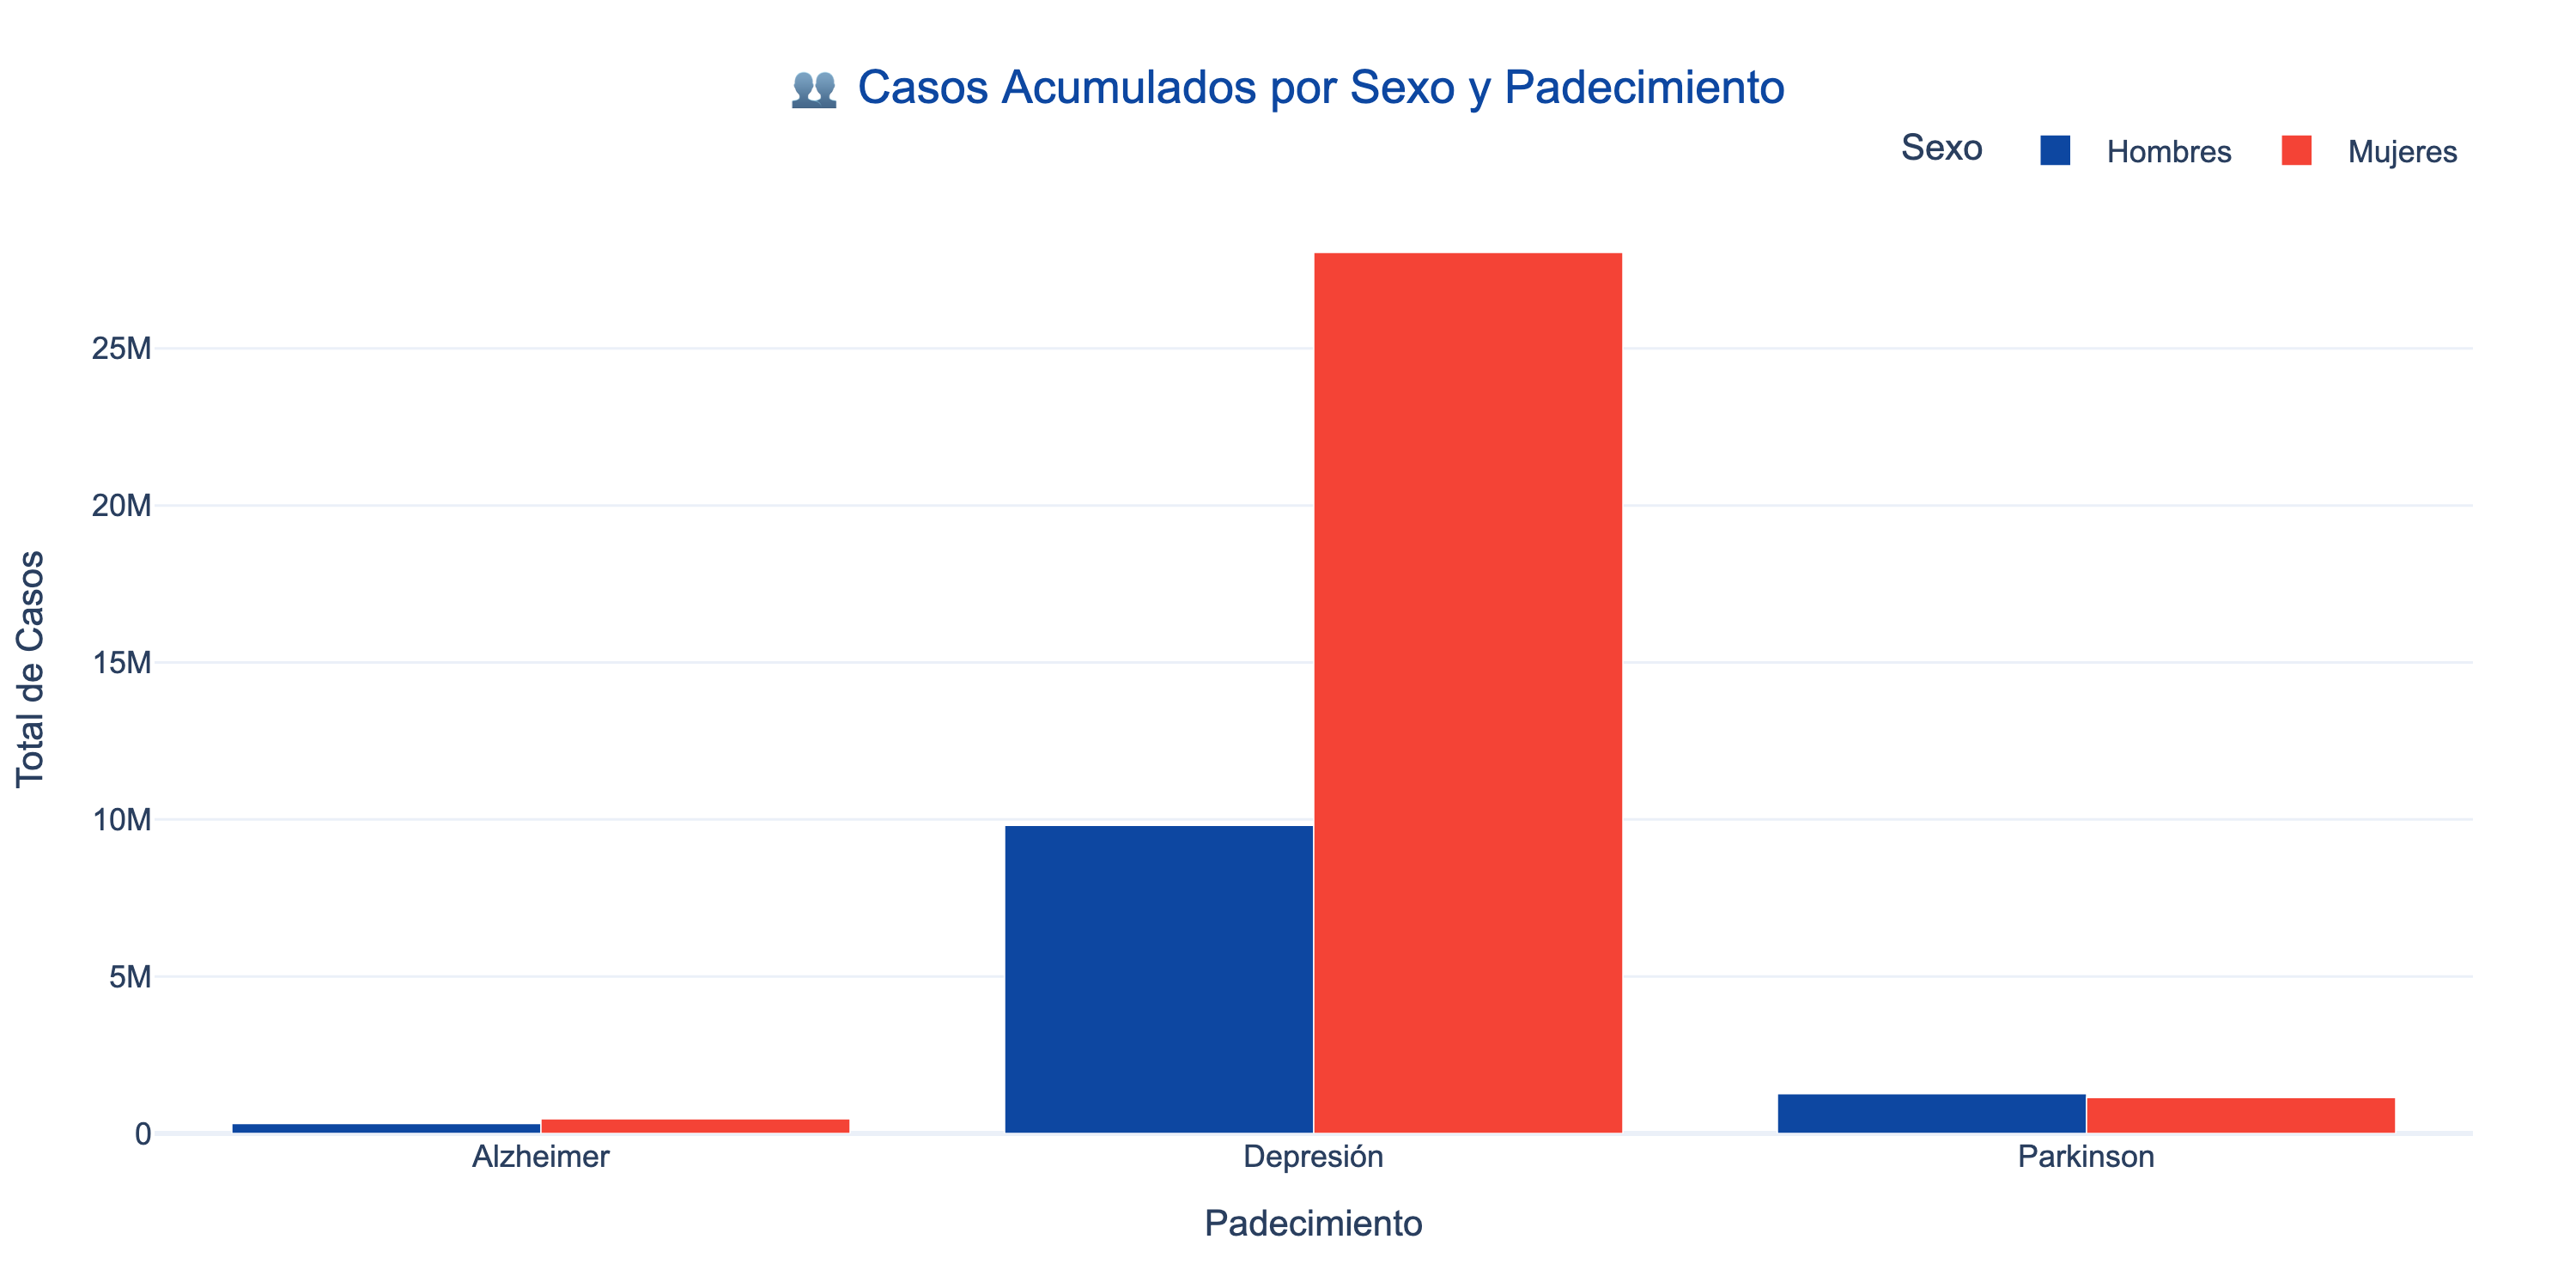

In [32]:
"""
Gráfico de barras agrupadas por sexo y padecimiento.
"""
fig = px.bar(
    sexo_long,
    x='Padecimiento',
    y='Total_Casos',
    color='Sexo',
    barmode='group',
    color_discrete_map={'Hombres': COLORS['primary'], 'Mujeres': COLORS['danger']}
)

fig = style_plotly_figure(fig, '👥 Casos Acumulados por Sexo y Padecimiento')
fig.update_layout(
    xaxis_title='Padecimiento',
    yaxis_title='Total de Casos'
)
fig.show(config=PLOT_CONFIG)

In [33]:
"""
Ratio Hombres/Mujeres por padecimiento.
"""
sexo_por_padecimiento['Ratio_H_M'] = (
    sexo_por_padecimiento['Acumulado_hombres'] / 
    sexo_por_padecimiento['Acumulado_mujeres']
).round(2)

sexo_por_padecimiento['Pct_Hombres'] = (
    sexo_por_padecimiento['Acumulado_hombres'] / 
    (sexo_por_padecimiento['Acumulado_hombres'] + sexo_por_padecimiento['Acumulado_mujeres']) * 100
).round(1)

sexo_por_padecimiento['Pct_Mujeres'] = (100 - sexo_por_padecimiento['Pct_Hombres']).round(1)

print("\n📊 Ratio y Porcentajes por Sexo:")
display(sexo_por_padecimiento)


📊 Ratio y Porcentajes por Sexo:


Padecimiento  Acumulado_hombres  Acumulado_mujeres  Ratio_H_M  Pct_Hombres  \
0    Alzheimer             313543             466741       0.67        40.20   
1    Depresión            9811125           28058936       0.35        25.90   
2    Parkinson            1265615            1141186       1.11        52.60   

   Pct_Mujeres  
0        59.80  
1        74.10  
2        47.40

### 6.3 Casos por Entidad y Padecimiento

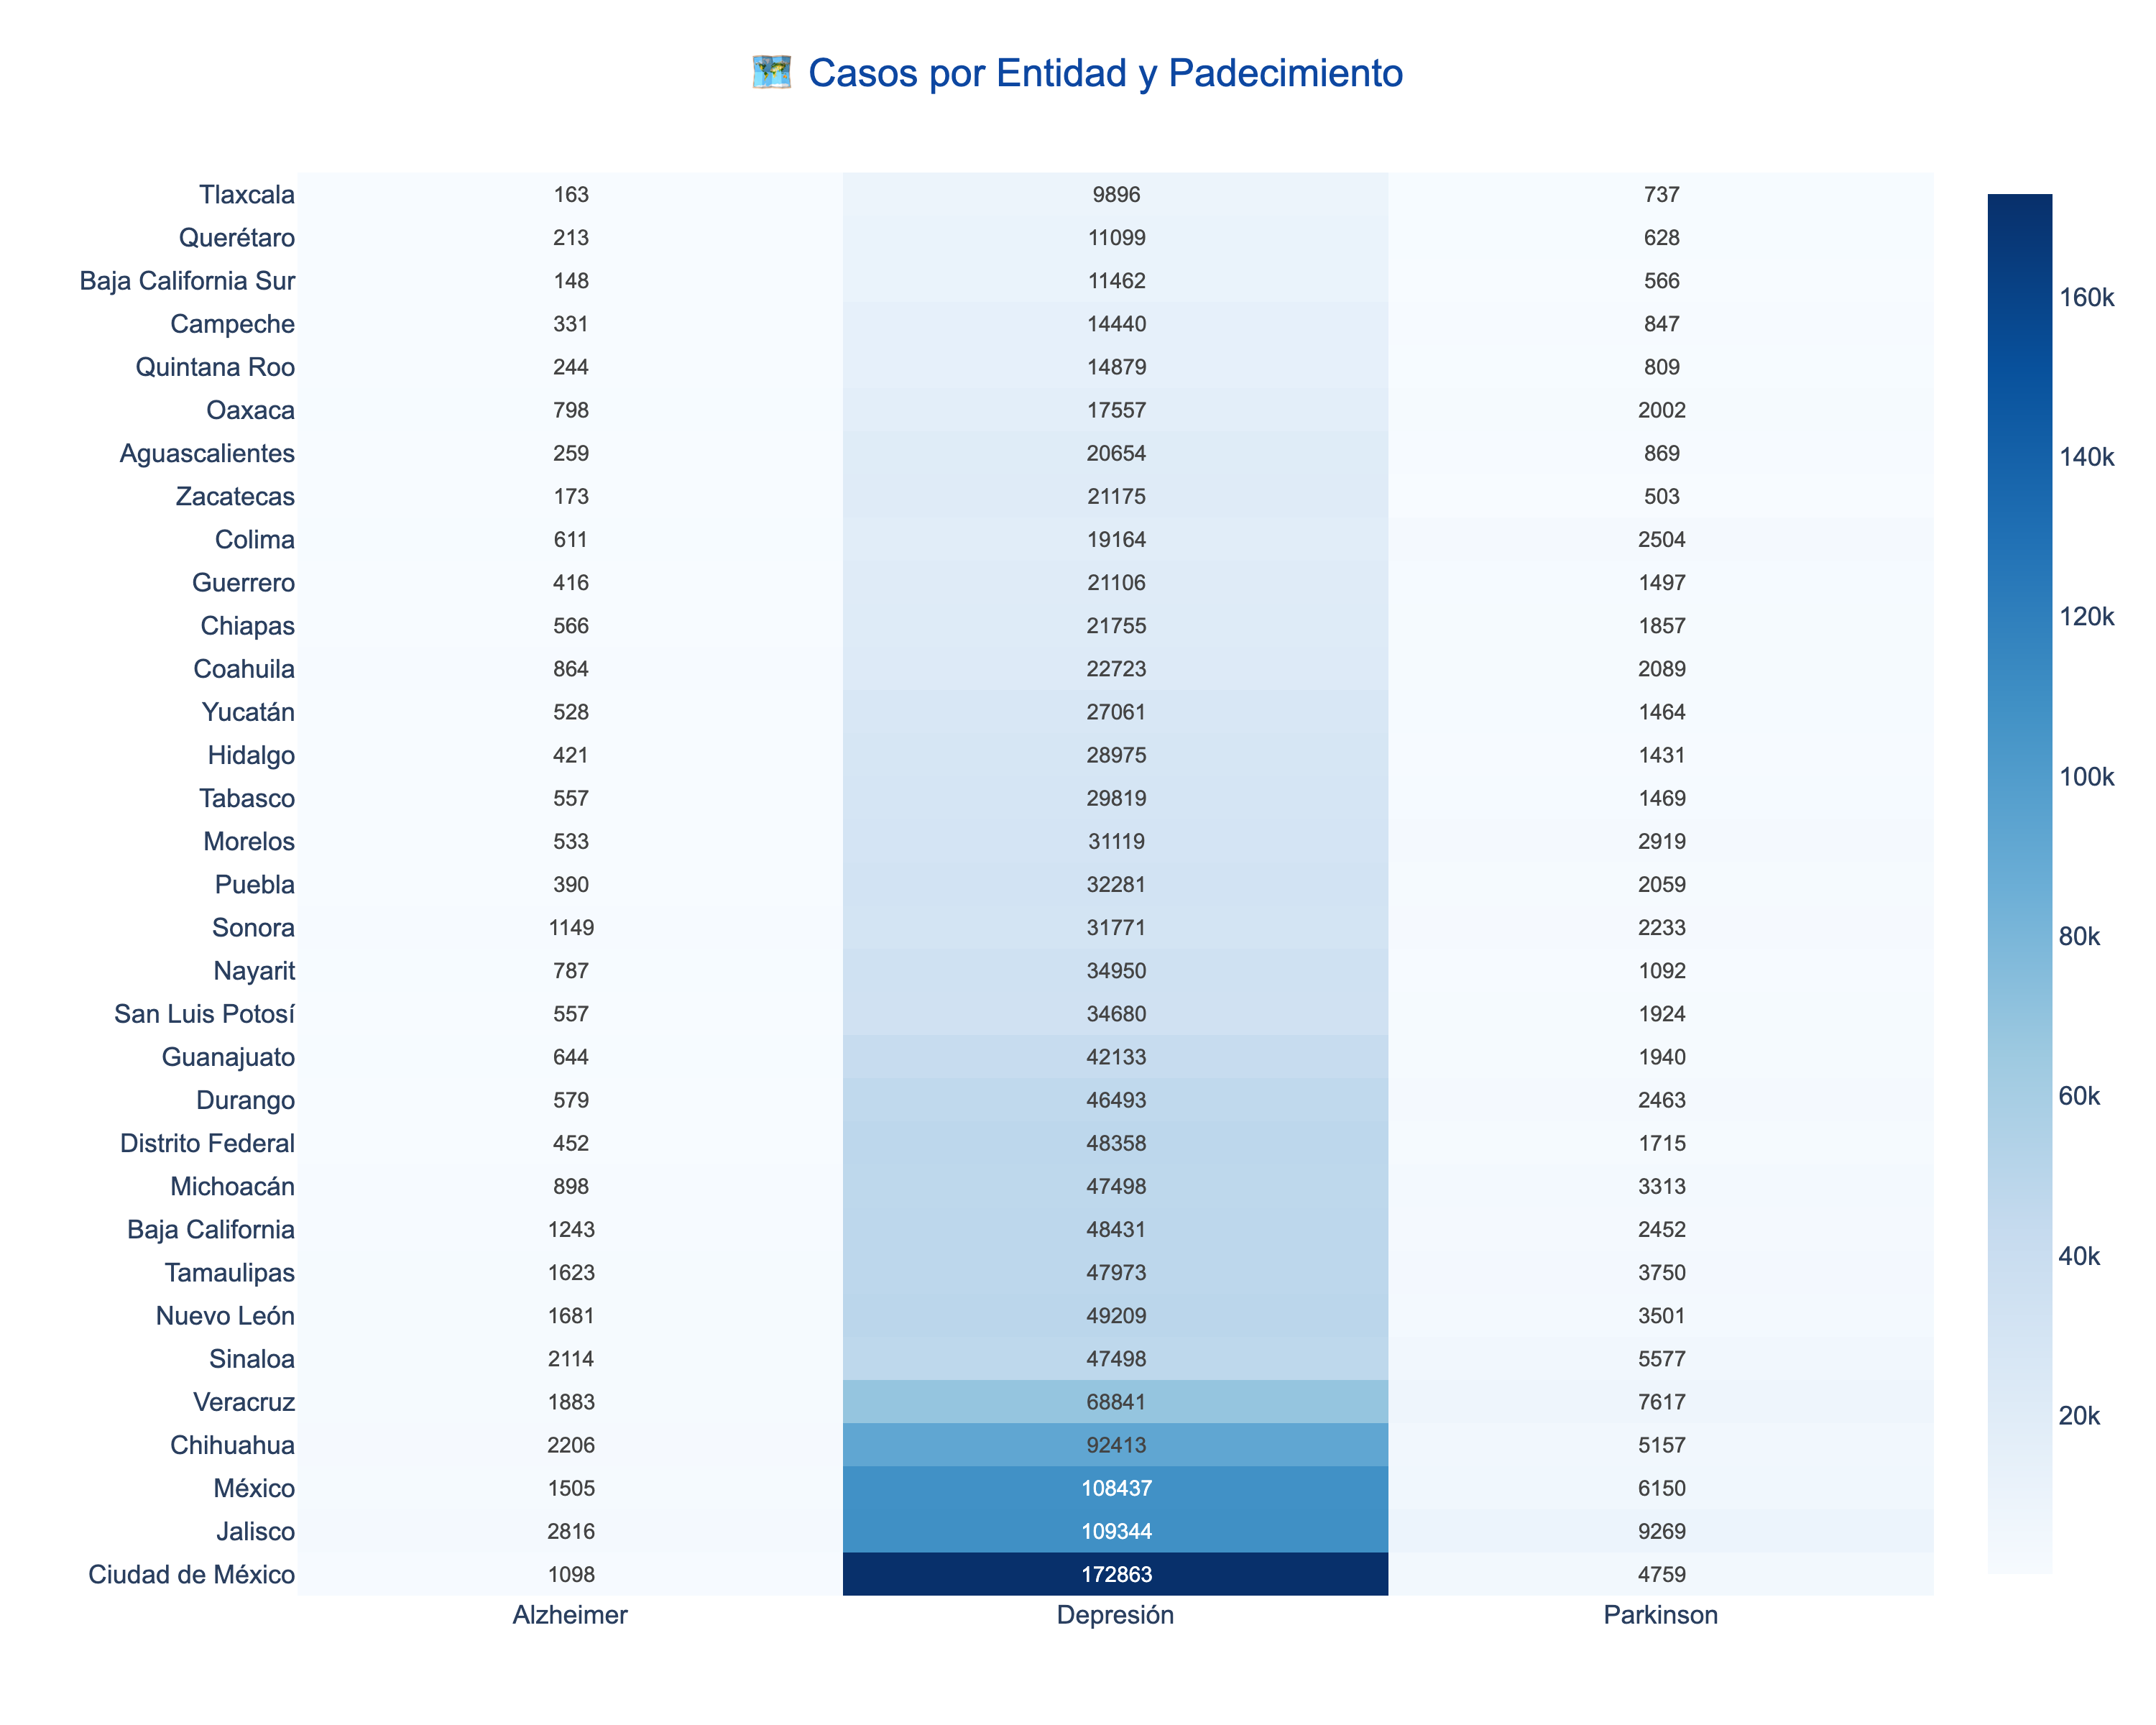

In [34]:
"""
Heatmap de casos por entidad y padecimiento.
"""
pivot_entidad_padecimiento = df.pivot_table(
    values='Casos_semana',
    index='Entidad',
    columns='Padecimiento',
    aggfunc='sum'
)

# Ordenar por total de casos
pivot_entidad_padecimiento['Total'] = pivot_entidad_padecimiento.sum(axis=1)
pivot_entidad_padecimiento = pivot_entidad_padecimiento.sort_values('Total', ascending=False)
pivot_entidad_padecimiento = pivot_entidad_padecimiento.drop('Total', axis=1)

fig = create_heatmap(
    pivot_entidad_padecimiento,
    '🗺️ Casos por Entidad y Padecimiento'
)

fig.update_layout(height=800)
fig.show(config=PLOT_CONFIG)

### 6.4 Comparación Año Actual vs Año Anterior

In [35]:
"""
Análisis de variación respecto al año anterior.
"""
# Filtrar datos del último año disponible
ultimo_anio = df['Anio'].max()
df_ultimo_anio = df[df['Anio'] == ultimo_anio].copy()

# Calcular diferencia
df_ultimo_anio['Diferencia'] = (
    df_ultimo_anio['Acumulado_hombres'] + df_ultimo_anio['Acumulado_mujeres'] - 
    df_ultimo_anio['Acumulado_anio_anterior']
)

df_ultimo_anio['Cambio_Pct'] = (
    (df_ultimo_anio['Diferencia'] / df_ultimo_anio['Acumulado_anio_anterior'].replace(0, np.nan)) * 100
)

# Resumen por padecimiento
variacion_resumen = df_ultimo_anio.groupby('Padecimiento').agg({
    'Diferencia': 'sum',
    'Cambio_Pct': 'mean'
}).round(2).reset_index()

print(f"\n📊 Variación Respecto al Año Anterior ({ultimo_anio - 1} vs {ultimo_anio}):")
display(variacion_resumen)


📊 Variación Respecto al Año Anterior (2025 vs 2026):


Padecimiento  Diferencia  Cambio_Pct
0    Alzheimer      -36.00       -6.65
1    Depresión     1886.00       37.14
2    Parkinson     -143.00       27.75

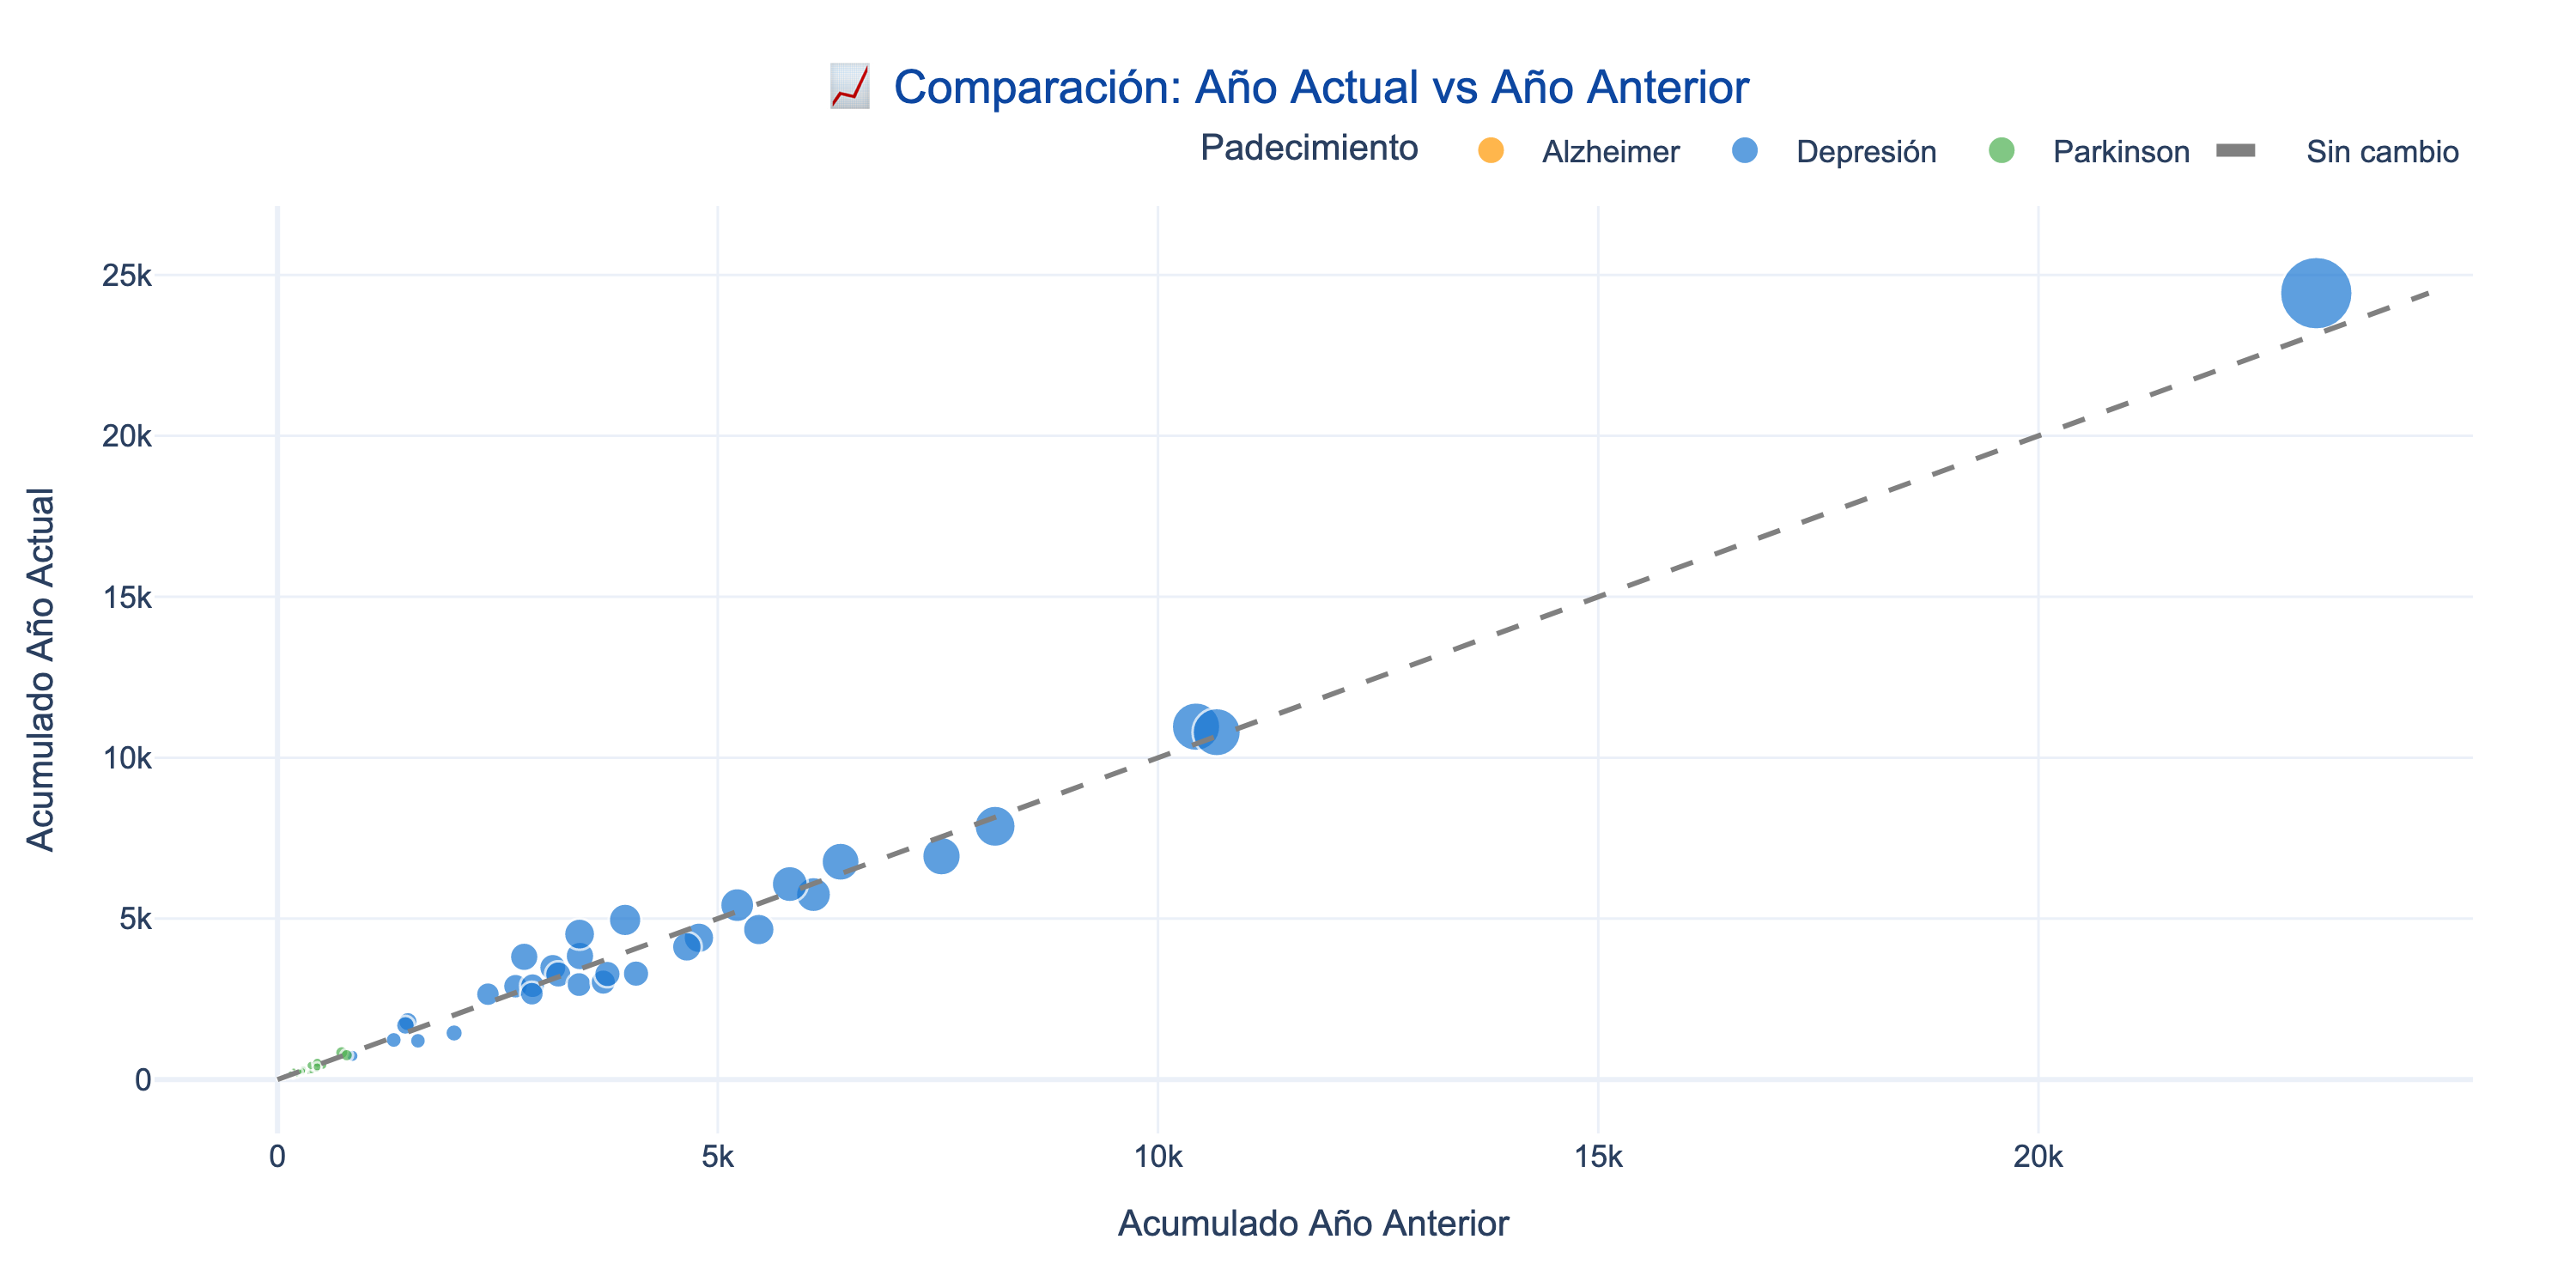

In [36]:
"""
Scatter plot: Acumulado actual vs año anterior.
"""
df_scatter = df_ultimo_anio.groupby(['Entidad', 'Padecimiento']).agg({
    'Acumulado_hombres': 'max',
    'Acumulado_mujeres': 'max',
    'Acumulado_anio_anterior': 'max'
}).reset_index()

df_scatter['Total_actual'] = df_scatter['Acumulado_hombres'] + df_scatter['Acumulado_mujeres']

fig = px.scatter(
    df_scatter,
    x='Acumulado_anio_anterior',
    y='Total_actual',
    color='Padecimiento',
    size='Total_actual',
    hover_data=['Entidad'],
    color_discrete_map=DISEASE_COLORS
)

# Línea de referencia (sin cambio)
max_val = max(df_scatter['Total_actual'].max(), df_scatter['Acumulado_anio_anterior'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    name='Sin cambio',
    line=dict(dash='dash', color='gray')
))

fig = style_plotly_figure(fig, '📈 Comparación: Año Actual vs Año Anterior')
fig.update_layout(
    xaxis_title='Acumulado Año Anterior',
    yaxis_title='Acumulado Año Actual'
)
fig.show(config=PLOT_CONFIG)

---
## 7. ⏰ Análisis Temporal (Series de Tiempo)

### 7.1 Tendencias Anuales

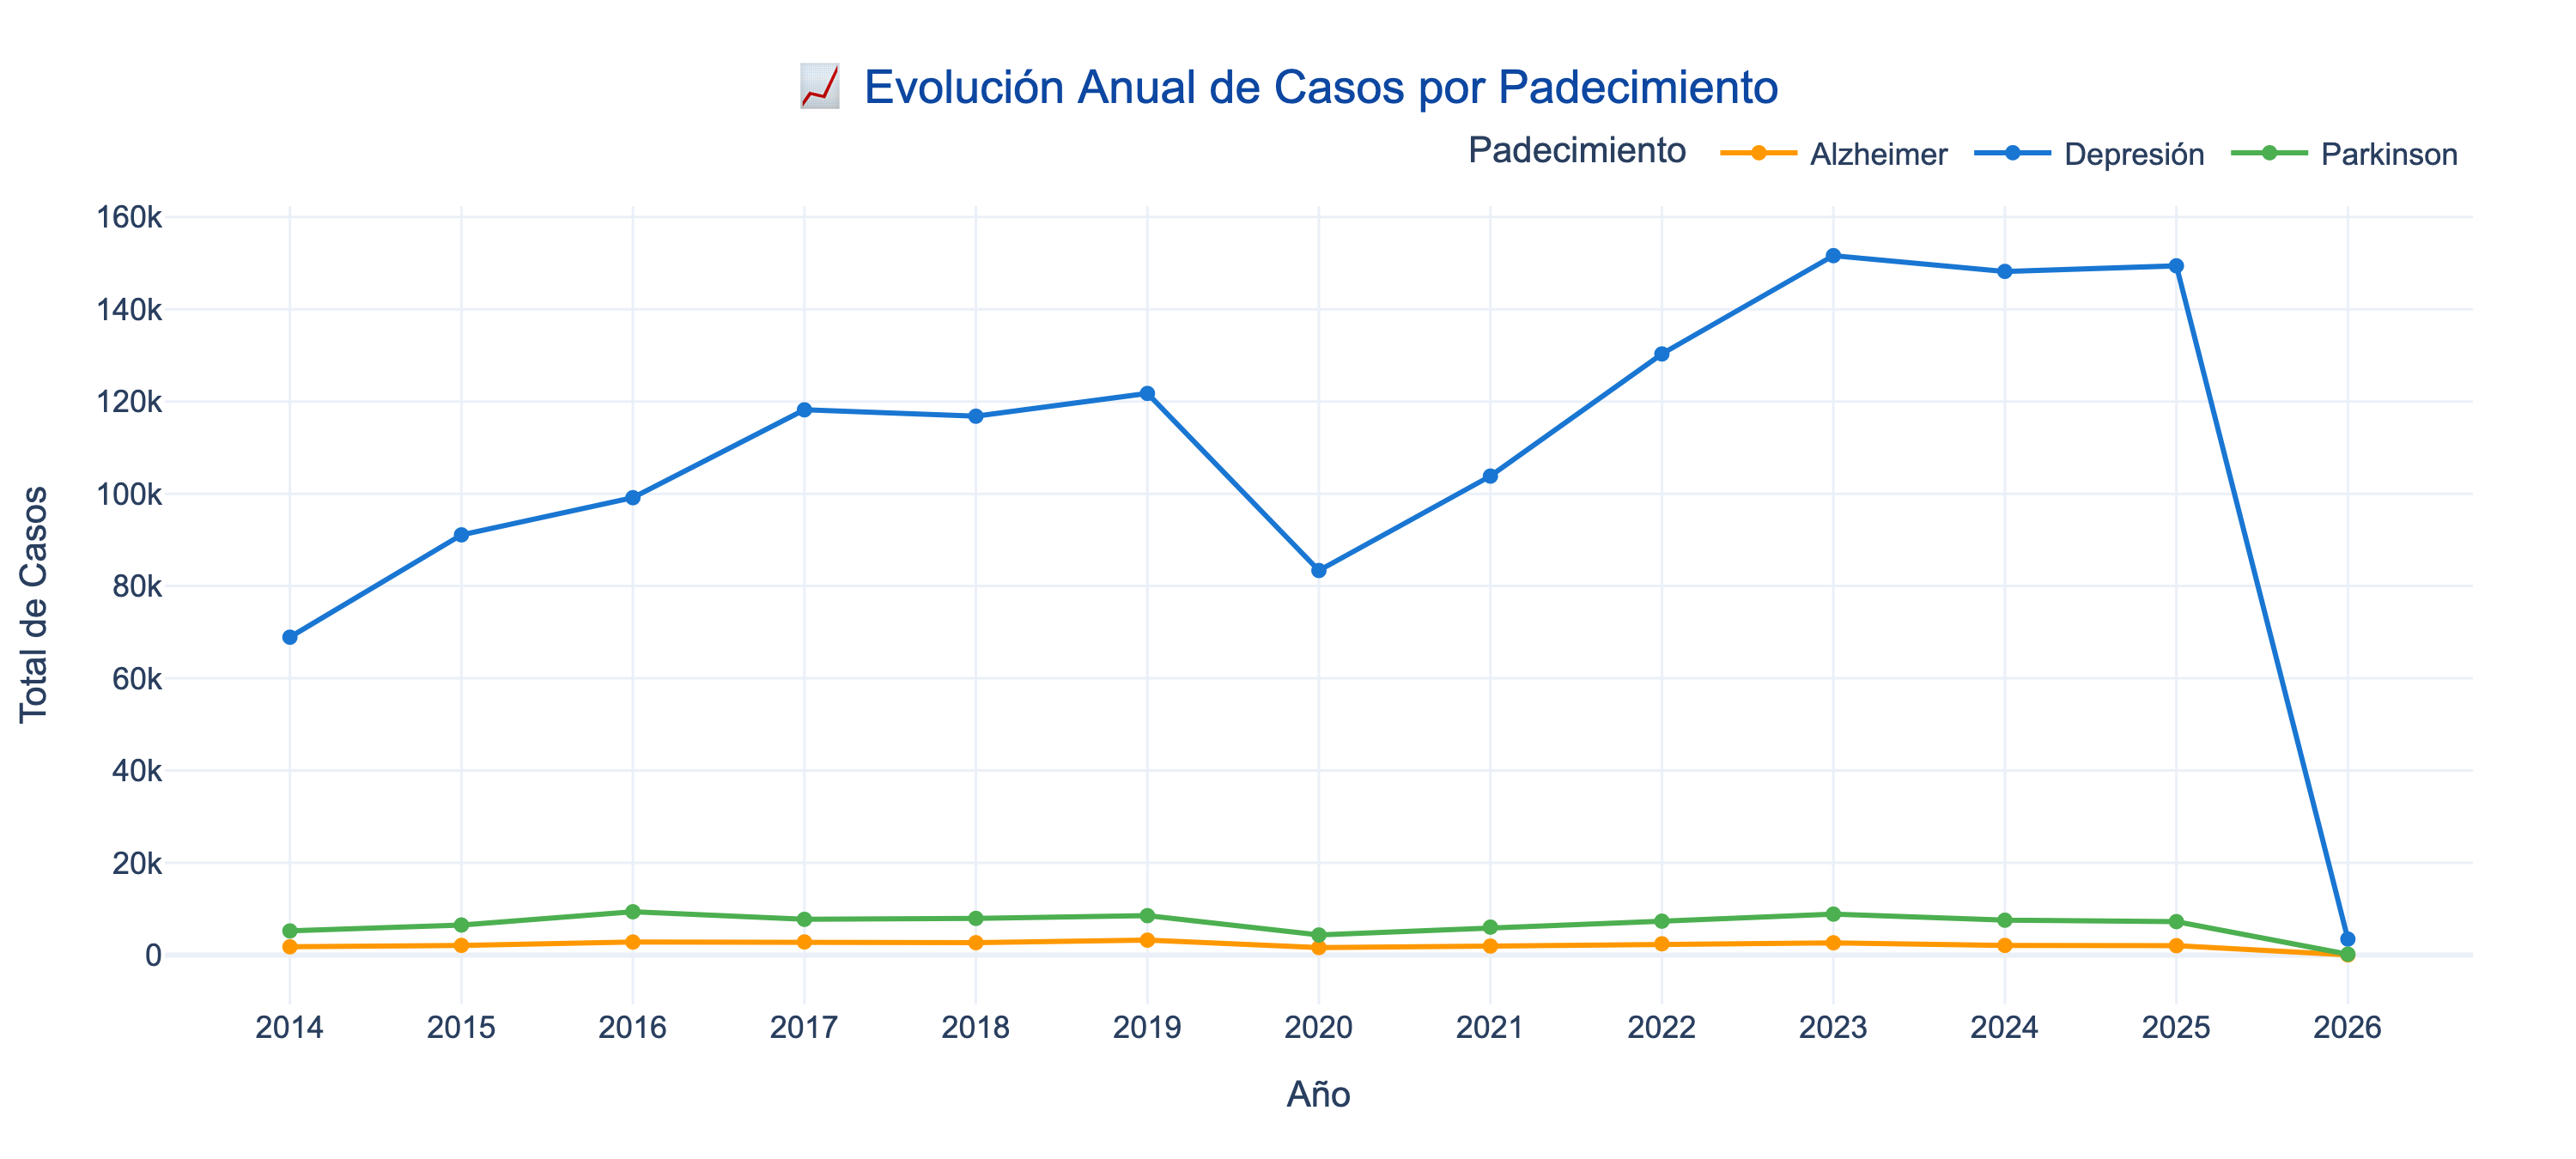

In [37]:
"""
Evolución temporal de casos por padecimiento.
"""
tendencia_anual = df.groupby(['Anio', 'Padecimiento'])['Casos_semana'].sum().reset_index()
tendencia_anual.columns = ['Año', 'Padecimiento', 'Total_Casos']

fig = create_time_series(
    tendencia_anual,
    'Año',
    'Total_Casos',
    'Padecimiento',
    '📈 Evolución Anual de Casos por Padecimiento'
)

fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Total de Casos',
    xaxis={'type': 'category'}
)
fig.show(config=PLOT_CONFIG)

In [38]:
"""
Tasa de crecimiento anual por padecimiento.
"""
# Calcular crecimiento año a año
tendencia_pivot = tendencia_anual.pivot(
    index='Año',
    columns='Padecimiento',
    values='Total_Casos'
)

crecimiento = tendencia_pivot.pct_change() * 100

print("\n📊 Tasa de Crecimiento Anual (%):")
display(crecimiento.round(2))


📊 Tasa de Crecimiento Anual (%):


Padecimiento  Alzheimer  Depresión  Parkinson
Año                                          
2014                NaN        NaN        NaN
2015              16.74      32.18      24.51
2016              34.33       8.85      44.01
2017               0.78      19.21     -17.54
2018              -5.40      -1.17       2.70
2019              20.10       4.23       7.52
2020             -49.21     -31.52     -49.00
2021              19.09      24.55      39.01
2022              25.11      25.50      21.24
2023               9.22      16.35      20.82
2024             -21.59      -2.26     -14.85
2025              -2.72       0.82      -4.06
2026             -97.50     -97.67     -97.23

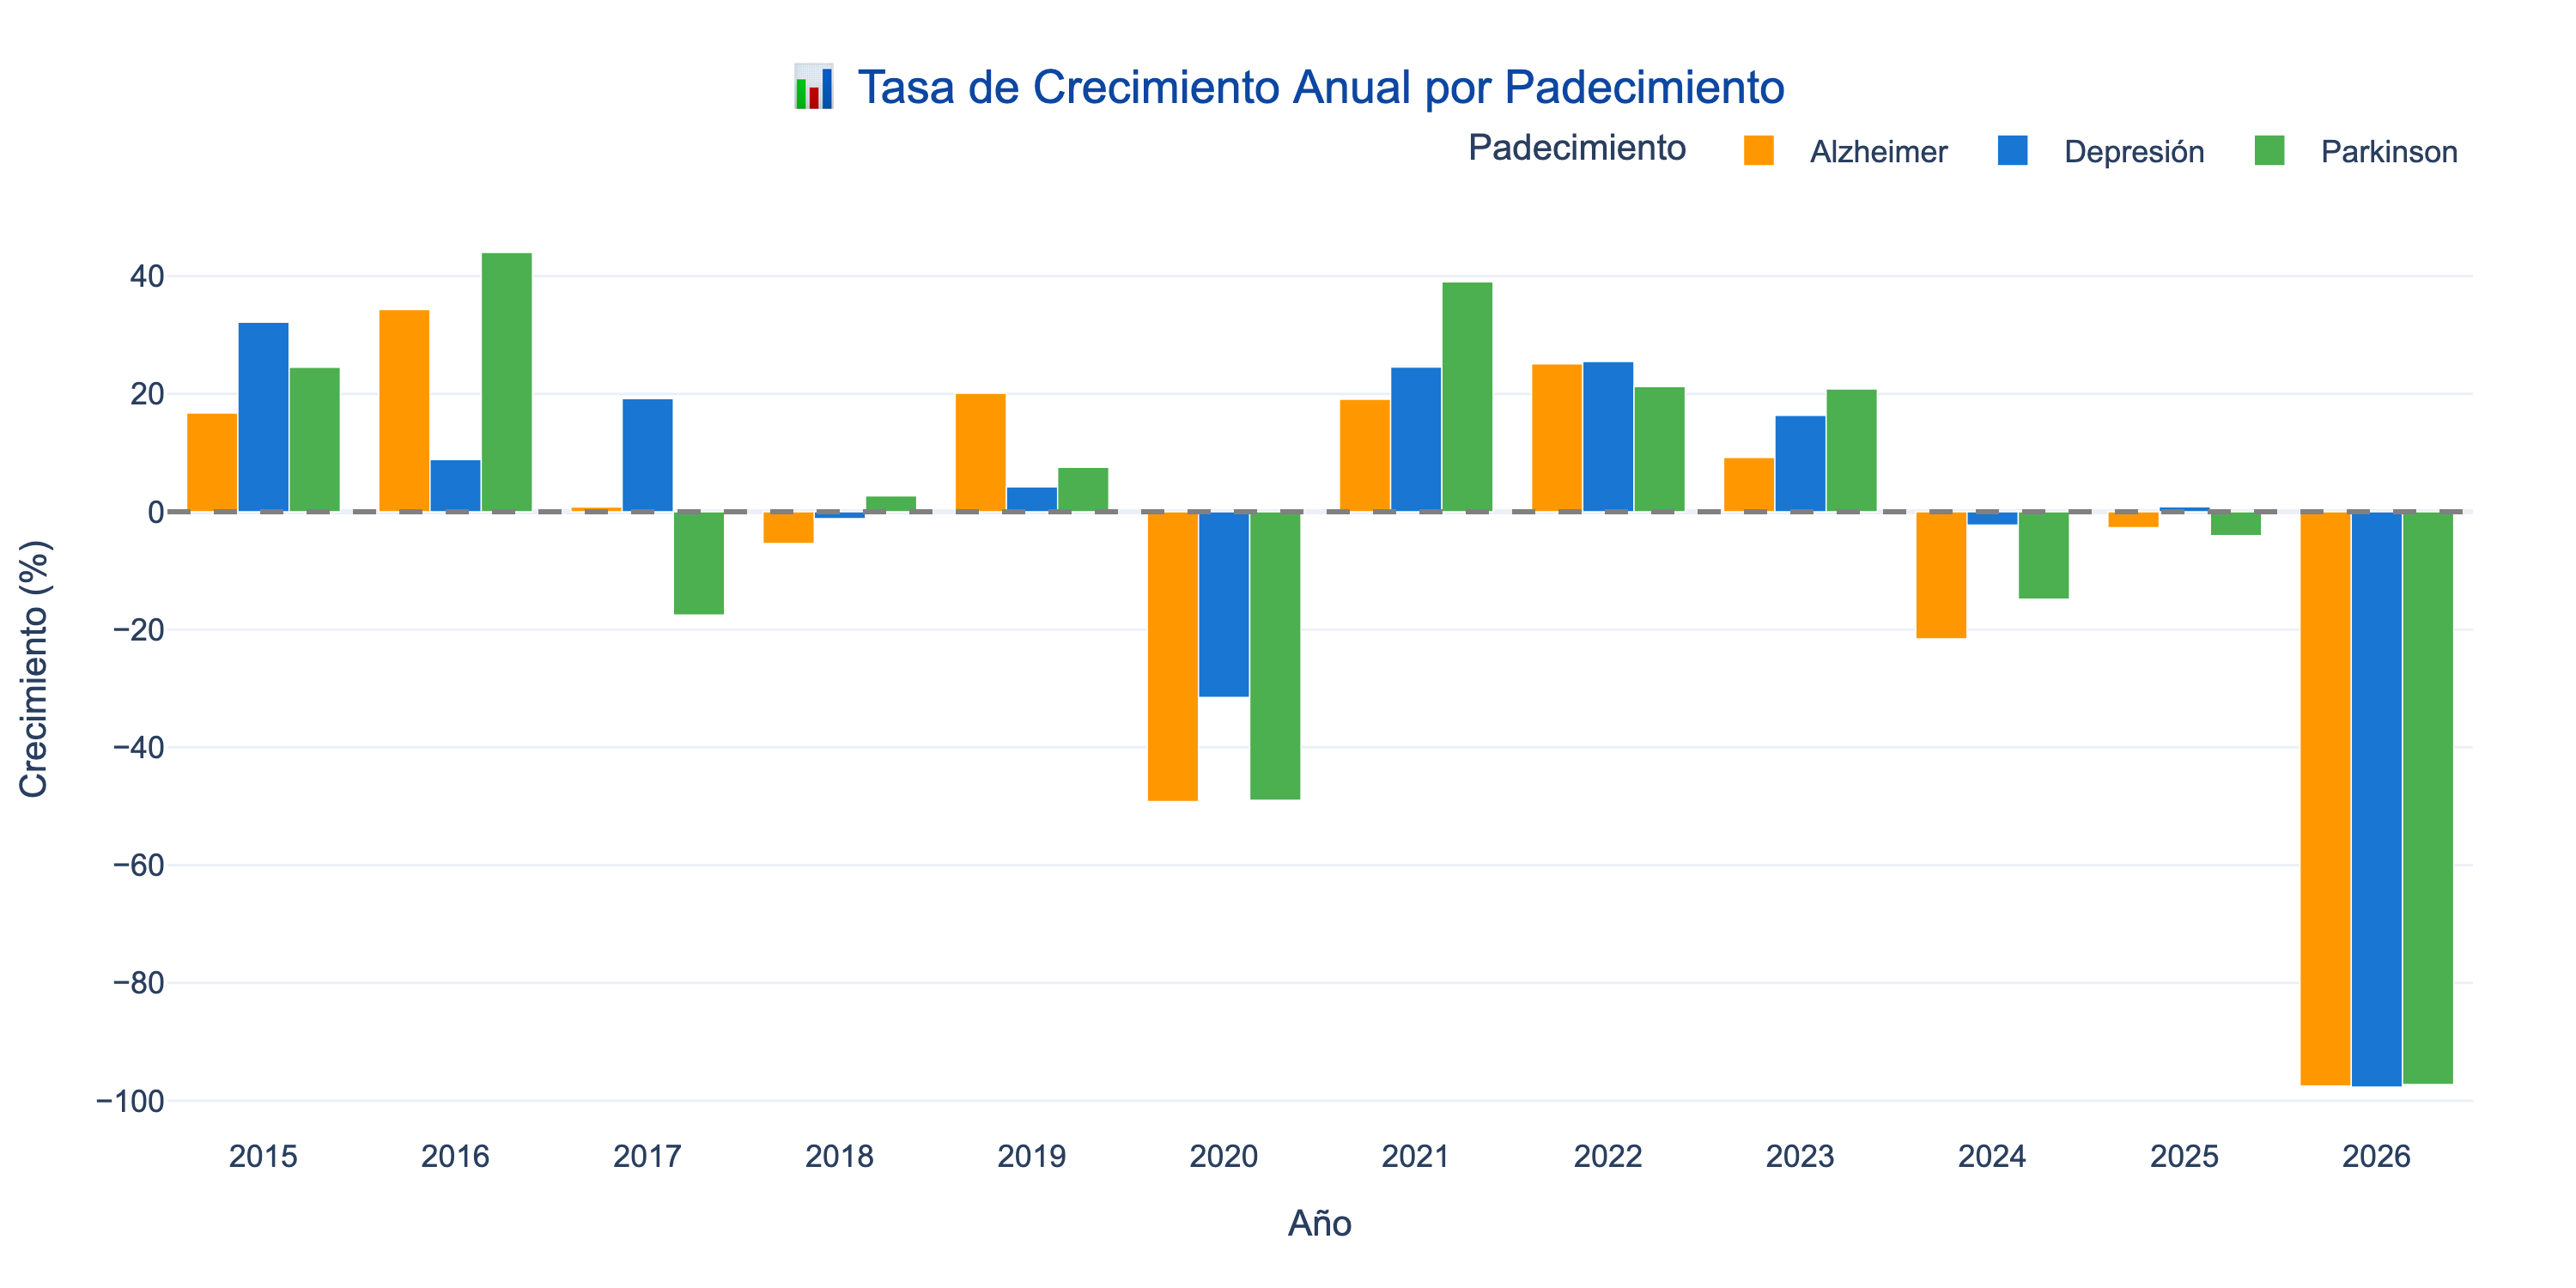

In [39]:
"""
Gráfico de tasa de crecimiento.
"""
crecimiento_long = crecimiento.reset_index().melt(
    id_vars='Año',
    var_name='Padecimiento',
    value_name='Crecimiento_Pct'
)

fig = px.bar(
    crecimiento_long.dropna(),
    x='Año',
    y='Crecimiento_Pct',
    color='Padecimiento',
    barmode='group',
    color_discrete_map=DISEASE_COLORS
)

# Línea de referencia en 0
fig.add_hline(y=0, line_dash='dash', line_color='gray')

fig = style_plotly_figure(fig, '📊 Tasa de Crecimiento Anual por Padecimiento')
fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Crecimiento (%)',
    xaxis={'type': 'category'}
)
fig.show(config=PLOT_CONFIG)

### 7.2 Patrones de Estacionalidad

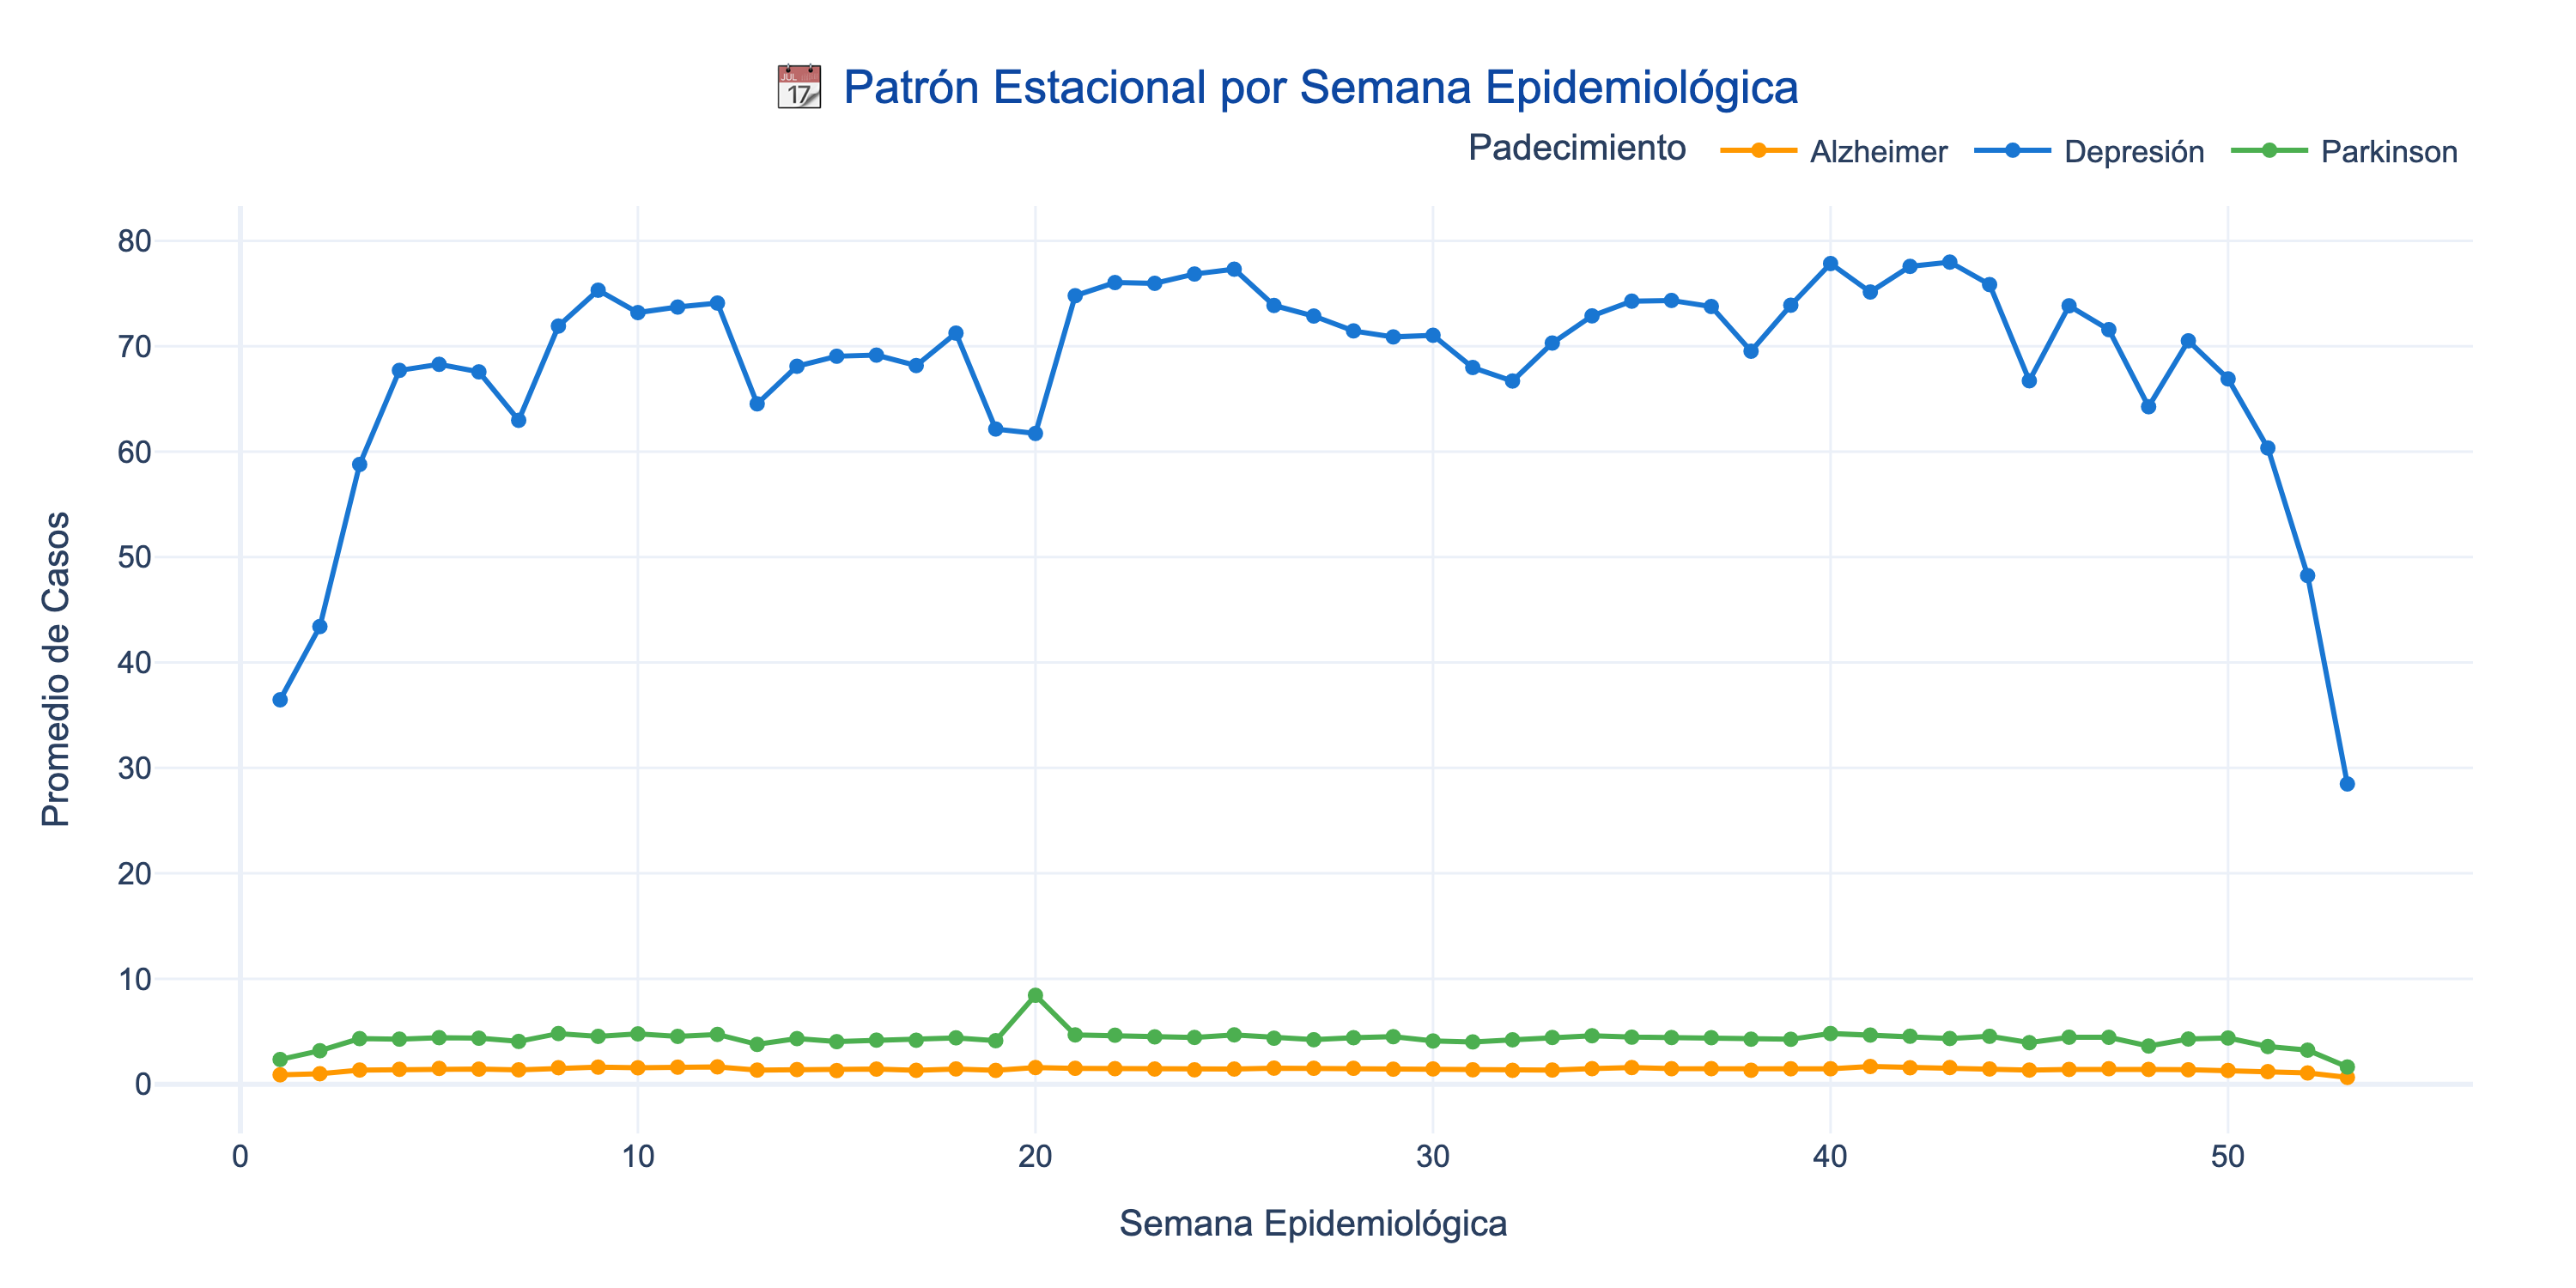

In [40]:
"""
Análisis de estacionalidad por semana epidemiológica.
"""
estacionalidad = df.groupby(['Semana', 'Padecimiento'])['Casos_semana'].mean().reset_index()
estacionalidad.columns = ['Semana', 'Padecimiento', 'Promedio_Casos']

fig = px.line(
    estacionalidad,
    x='Semana',
    y='Promedio_Casos',
    color='Padecimiento',
    color_discrete_map=DISEASE_COLORS,
    markers=True
)

fig = style_plotly_figure(fig, '📆 Patrón Estacional por Semana Epidemiológica')
fig.update_layout(
    xaxis_title='Semana Epidemiológica',
    yaxis_title='Promedio de Casos'
)
fig.show(config=PLOT_CONFIG)

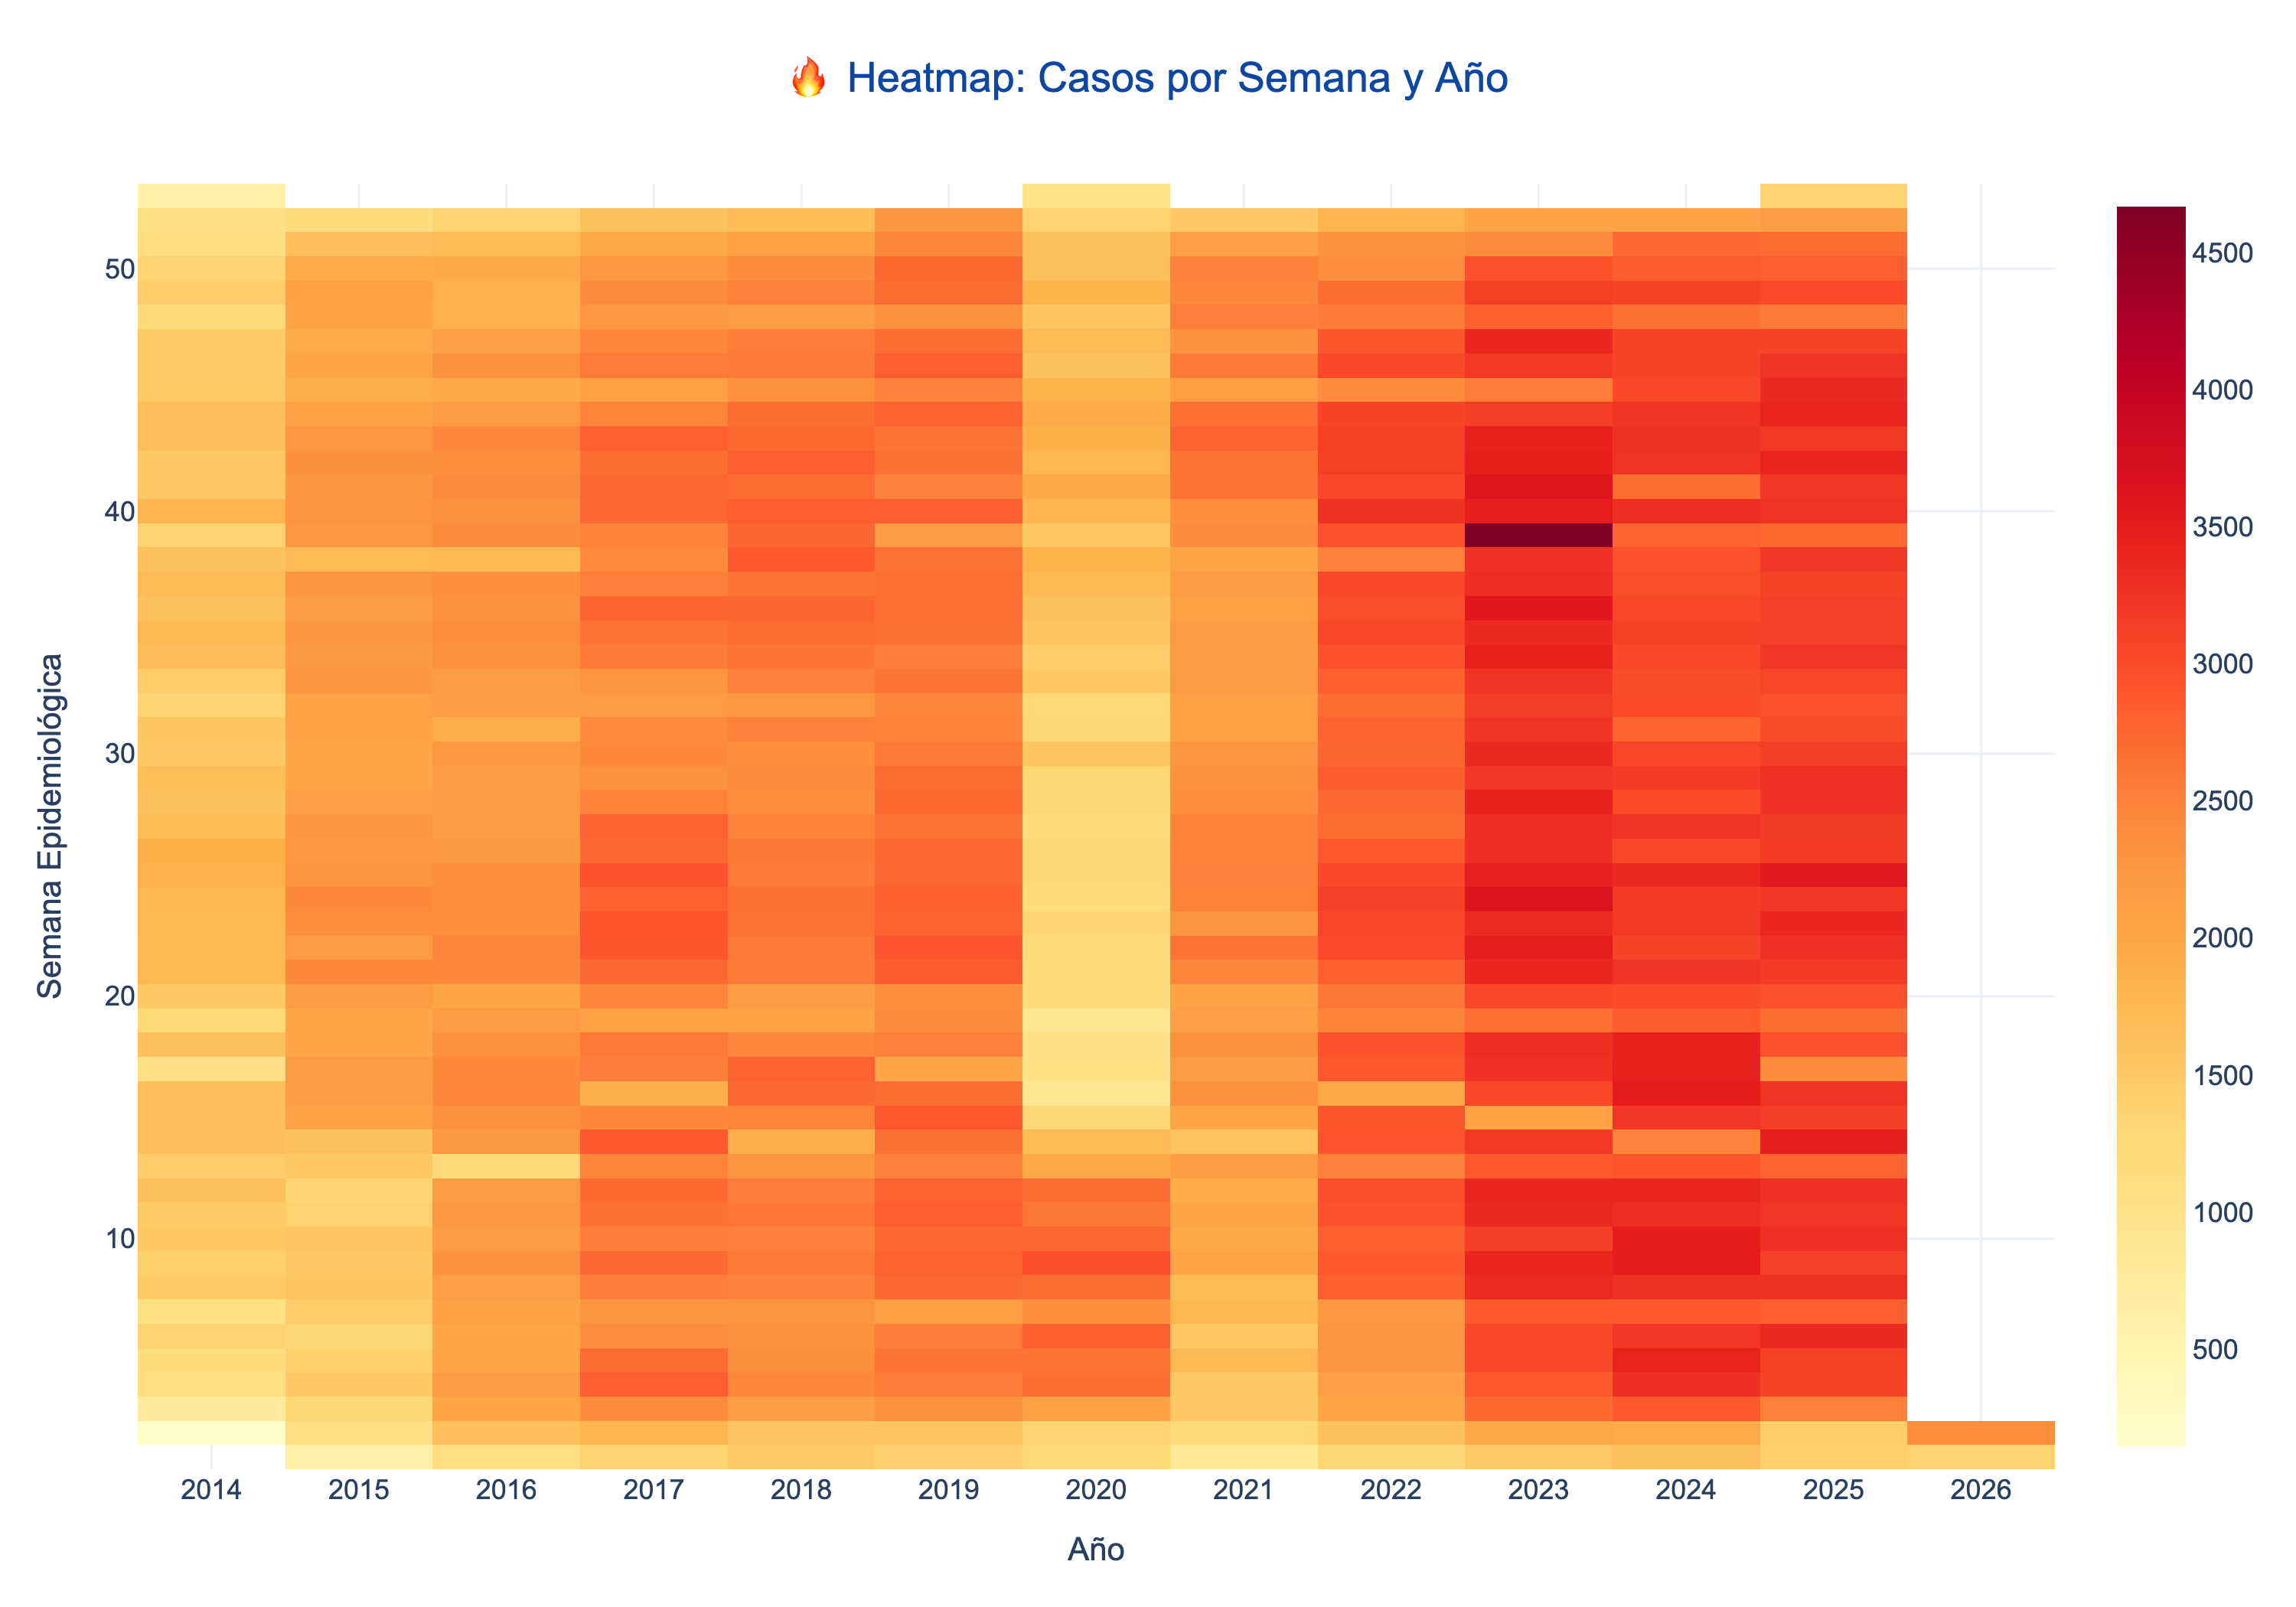

In [41]:
"""
Heatmap de estacionalidad: Semana vs Año.
"""
# Crear pivot table
heatmap_data = df.pivot_table(
    values='Casos_semana',
    index='Semana',
    columns='Anio',
    aggfunc='sum'
)

fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns.astype(str),
    y=heatmap_data.index,
    colorscale='YlOrRd',
    hoverongaps=False
))

fig = style_plotly_figure(fig, '🔥 Heatmap: Casos por Semana y Año', height=700)
fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Semana Epidemiológica'
)
fig.show(config=PLOT_CONFIG)

### 7.3 Detección de Cambios Estructurales

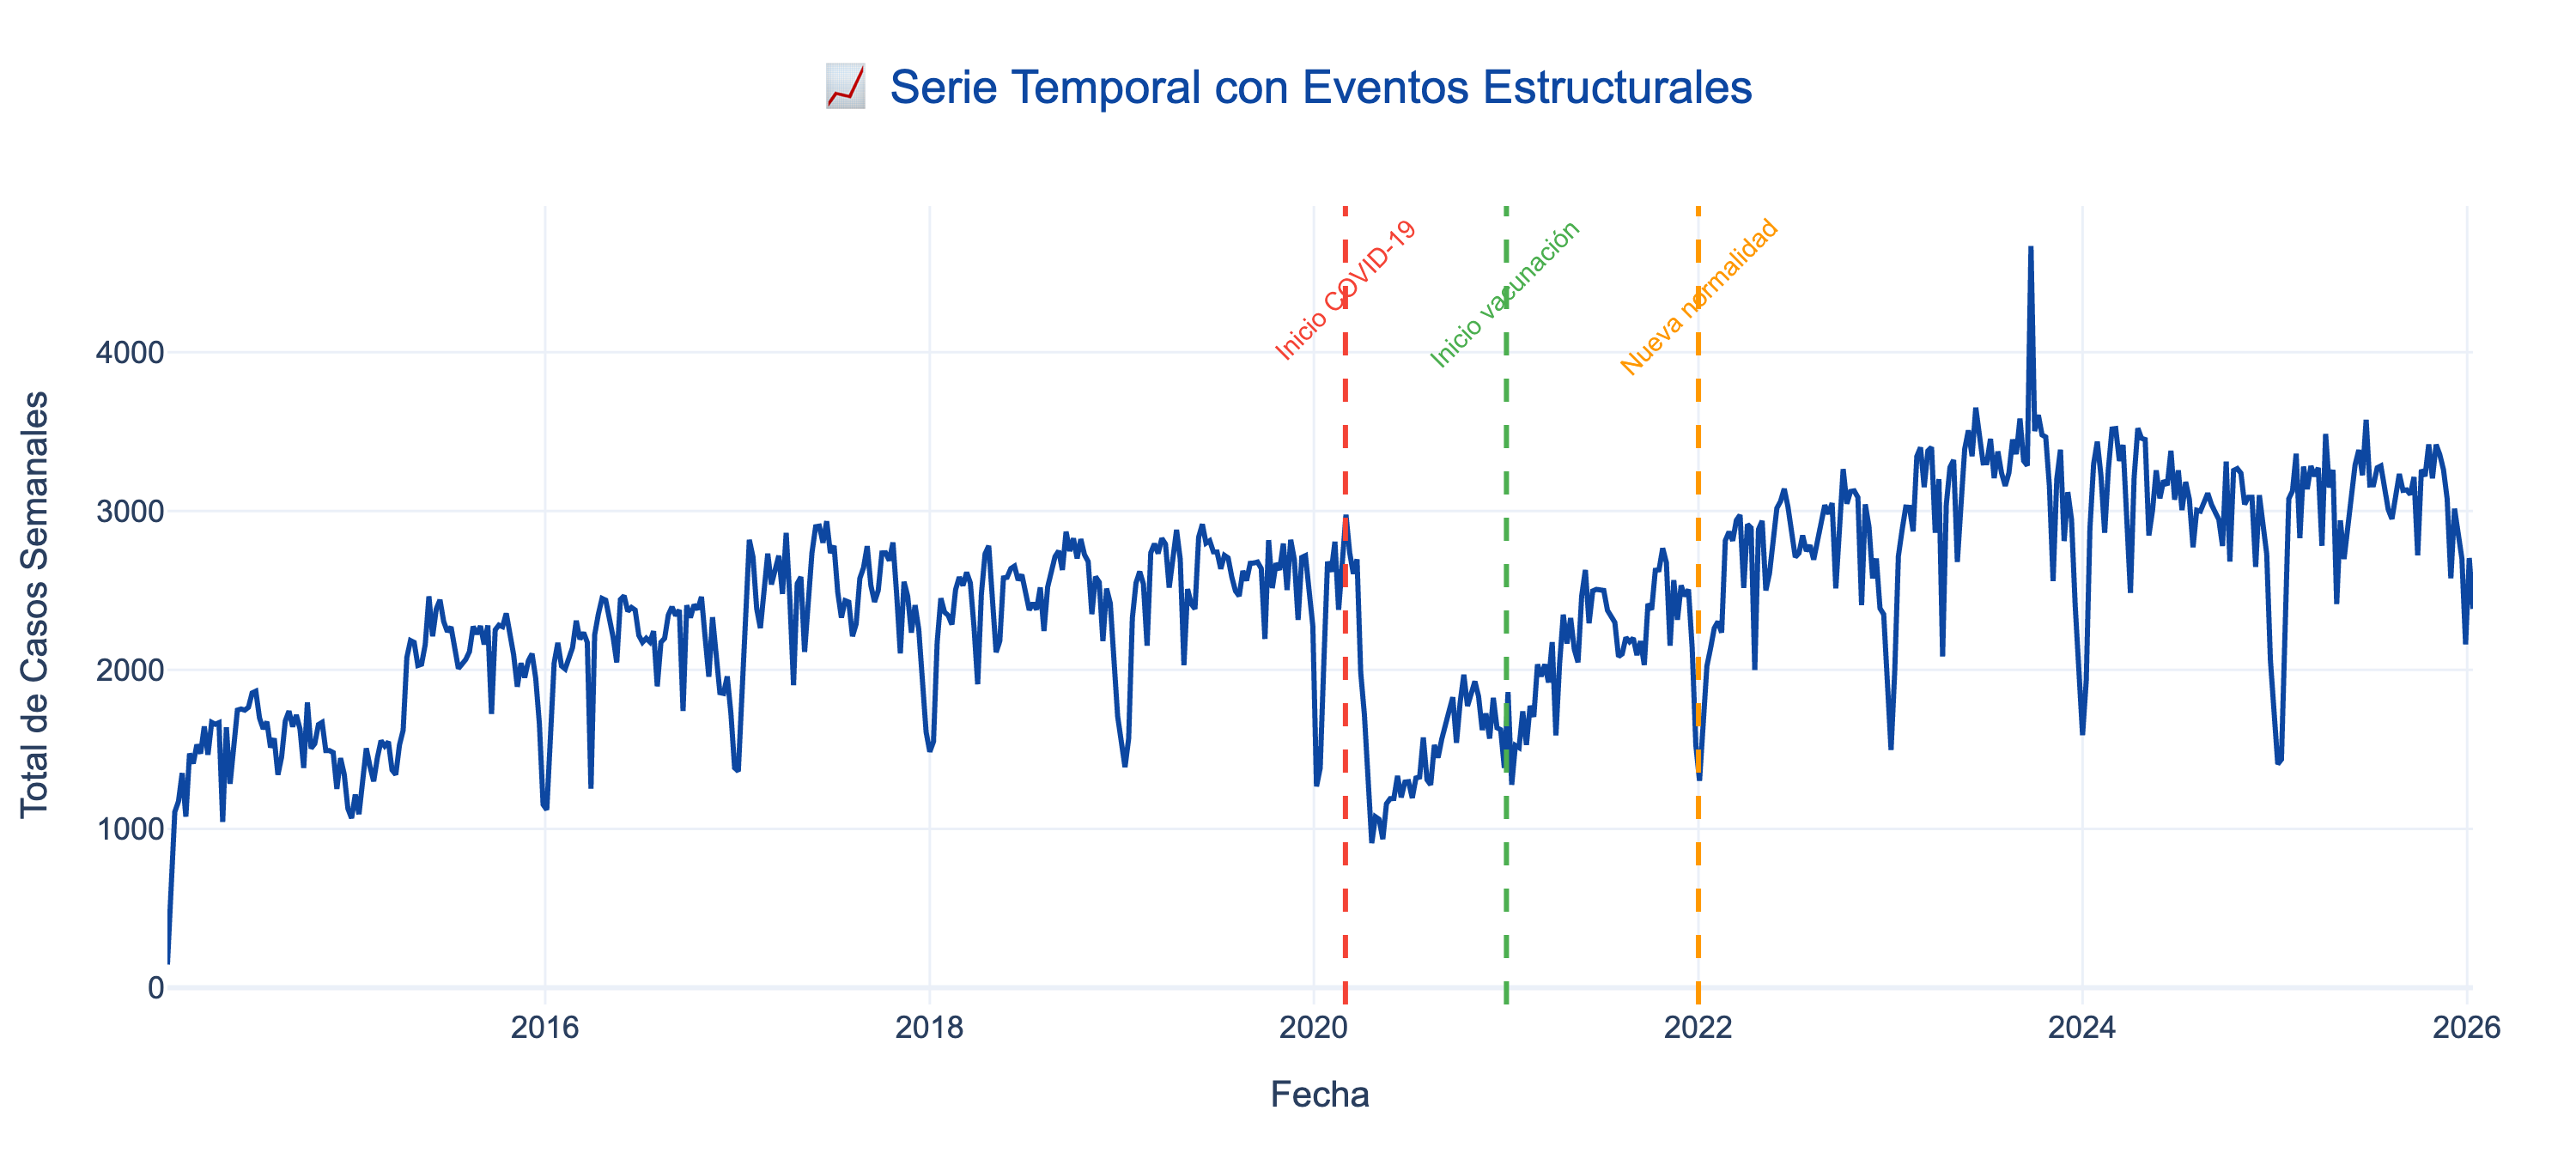

In [42]:
"""
Análisis de cambios estructurales (impacto COVID-19 y otros eventos).
"""
# Crear serie temporal completa
df_temporal = df.copy()
df_temporal['Fecha'] = pd.to_datetime(
    df_temporal['Anio'].astype(str) + '-W' + df_temporal['Semana'].astype(str) + '-1',
    format='%Y-W%W-%w'
)

serie_completa = df_temporal.groupby('Fecha')['Casos_semana'].sum().reset_index()

# Visualizar con anotaciones de eventos importantes
fig = px.line(
    serie_completa,
    x='Fecha',
    y='Casos_semana'
)

fig.update_traces(line_color=COLORS['primary'])

# Agregar líneas verticales para eventos importantes
eventos = [
    ('2020-03-01', 'Inicio COVID-19', COLORS['danger']),
    ('2021-01-01', 'Inicio vacunación', COLORS['success']),
    ('2022-01-01', 'Nueva normalidad', COLORS['warning'])
]

for fecha, evento, color in eventos:
    fecha_dt = pd.to_datetime(fecha)
    if fecha_dt >= serie_completa['Fecha'].min():
        fig.add_shape(
            type="line",
            x0=fecha, x1=fecha,
            y0=0, y1=1,
            yref="paper",
            line=dict(color=color, width=2, dash="dash")
        )
        fig.add_annotation(
            x=fecha,
            y=1,
            yref="paper",
            text=evento,
            showarrow=False,
            textangle=-45,
            font=dict(color=color, size=10)
        )

fig = style_plotly_figure(fig, '📈 Serie Temporal con Eventos Estructurales', height=450)
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Total de Casos Semanales'
)
fig.show(config=PLOT_CONFIG)

In [43]:
"""
Comparación de períodos: Pre-COVID vs COVID vs Post-COVID.
"""
# Definir períodos
df_temporal['Periodo'] = pd.cut(
    df_temporal['Anio'],
    bins=[2011, 2019, 2021, 2030],
    labels=['Pre-COVID (2012-2019)', 'COVID (2020-2021)', 'Post-COVID (2022+)']
)

# Estadísticas por período
stats_periodo = df_temporal.groupby('Periodo').agg({
    'Casos_semana': ['sum', 'mean', 'std', 'max']
}).round(2)

print("\n📊 Estadísticas por Período:")
display(stats_periodo)


📊 Estadísticas por Período:


Casos_semana                    
                               sum  mean   std     max
Periodo                                               
Pre-COVID (2012-2019)    676848.00 22.60 47.61  474.00
COVID (2020-2021)        201232.00 19.96 42.75  507.00
Post-COVID (2022+)       623589.00 30.79 63.01 1311.00

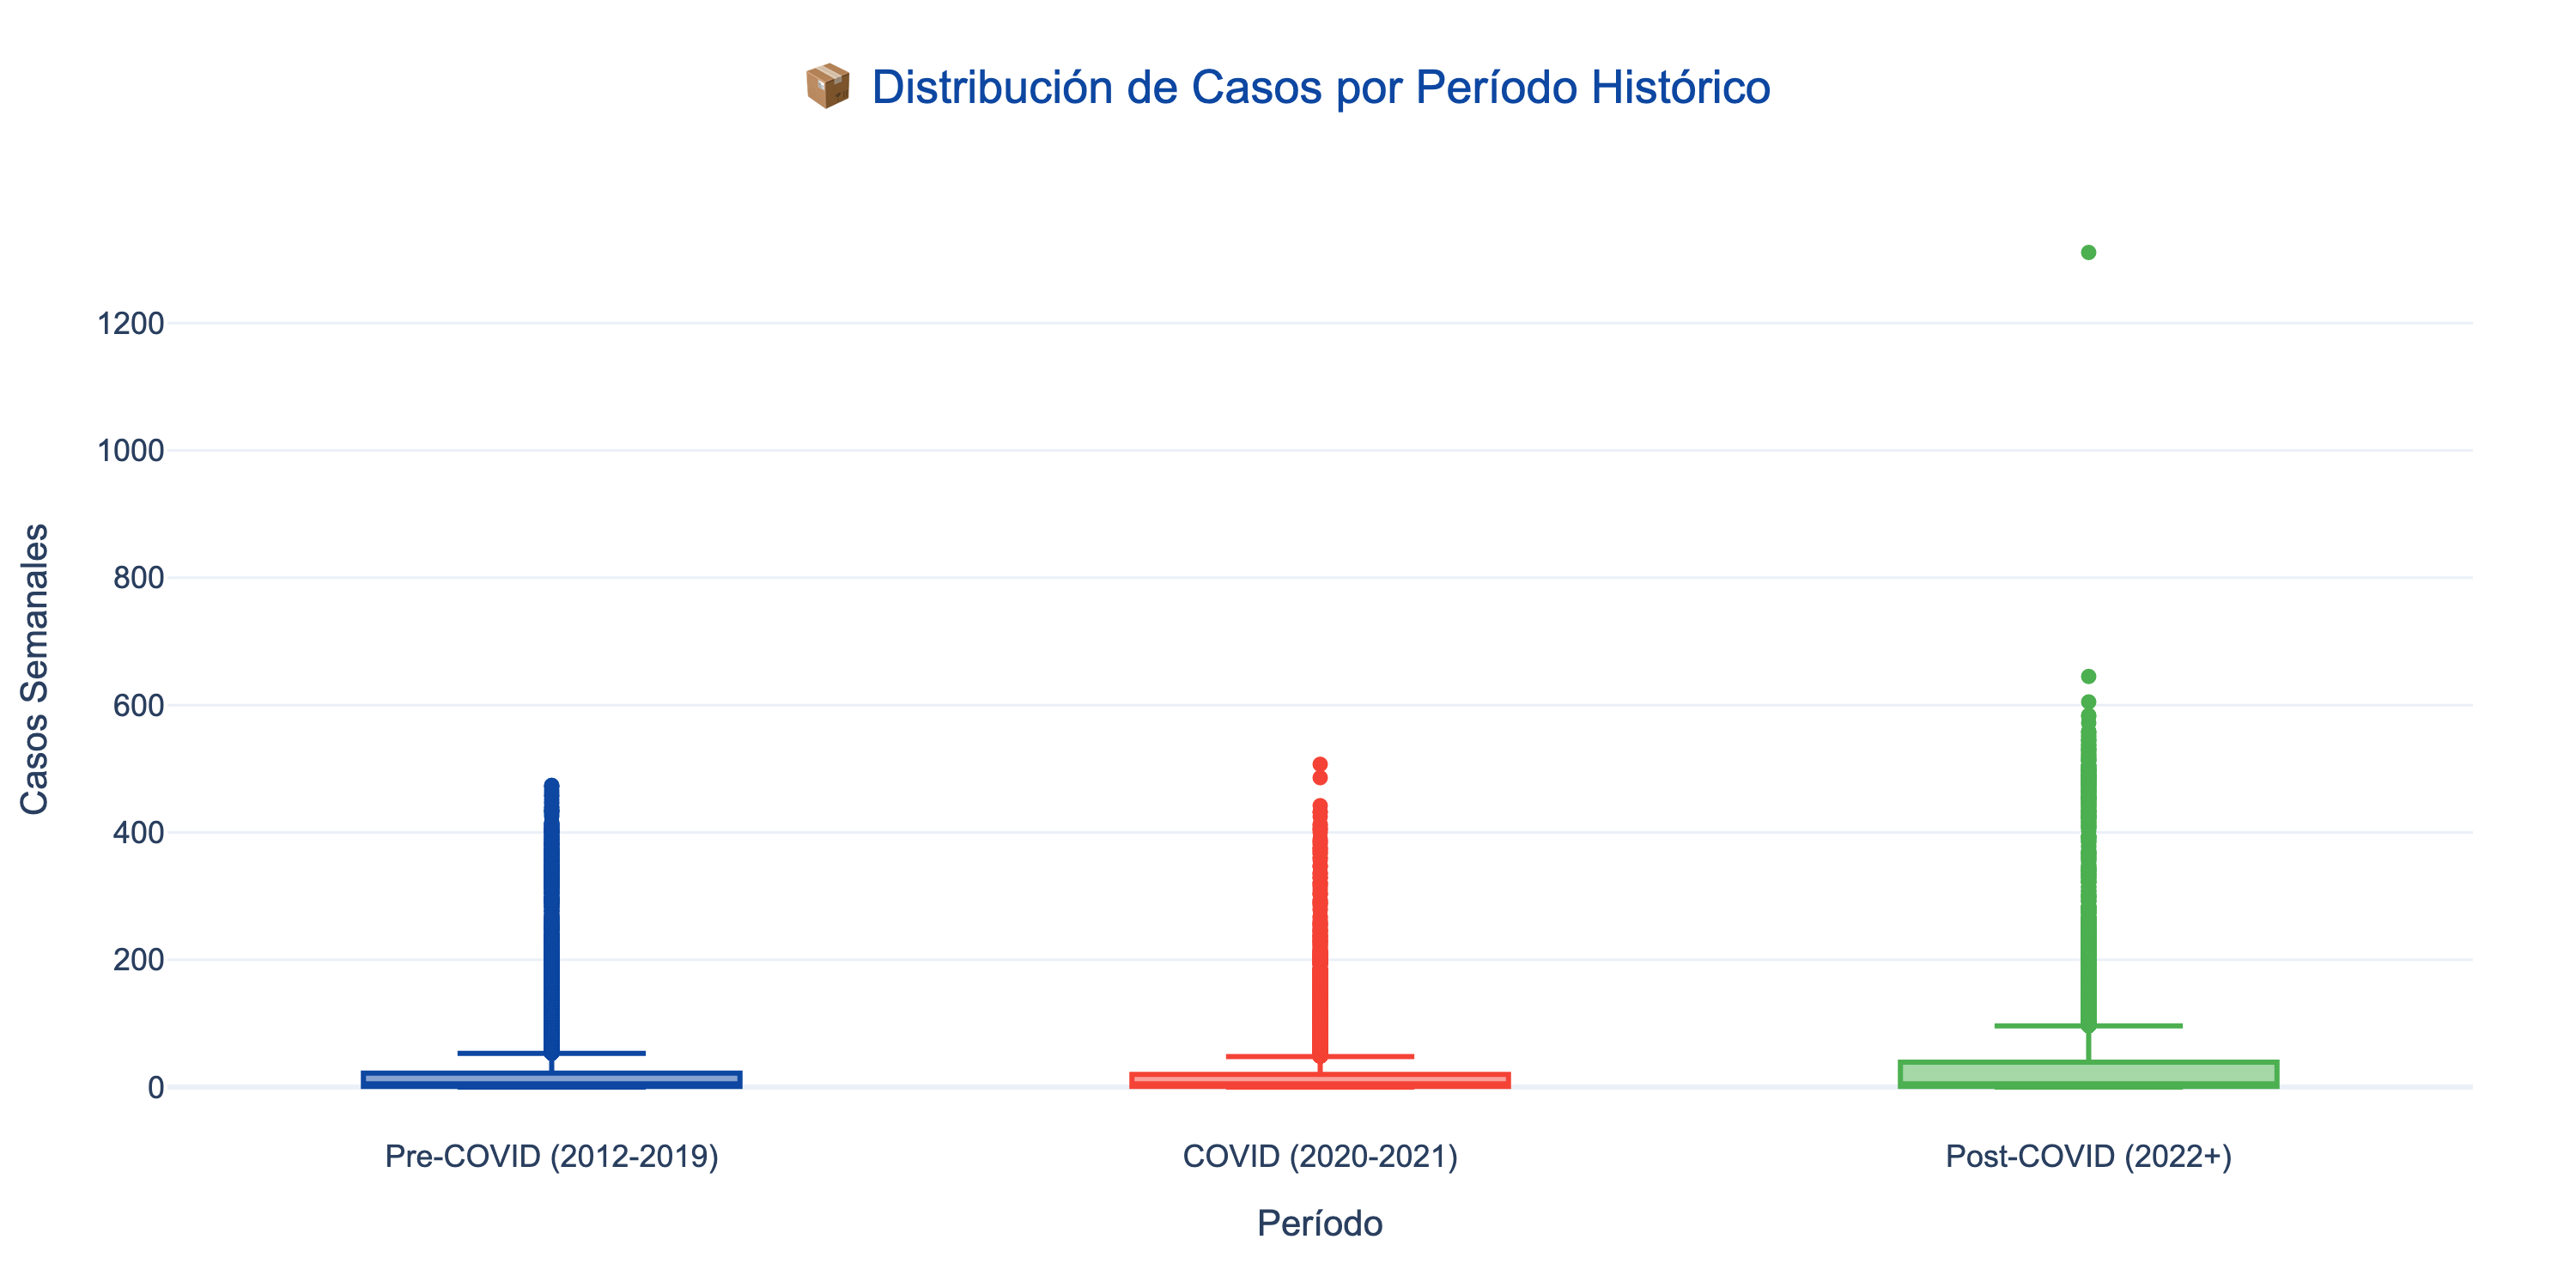

In [44]:
"""
Boxplot comparativo por período.
"""
fig = px.box(
    df_temporal.dropna(subset=['Periodo']),
    x='Periodo',
    y='Casos_semana',
    color='Periodo',
    color_discrete_sequence=[COLORS['primary'], COLORS['danger'], COLORS['success']]
)

fig = style_plotly_figure(fig, '📦 Distribución de Casos por Período Histórico')
fig.update_layout(
    xaxis_title='Período',
    yaxis_title='Casos Semanales',
    showlegend=False
)
fig.show(config=PLOT_CONFIG)

---
## 8. 🗺️ Análisis Geográfico

### 8.1 Disparidades Regionales

In [45]:
"""
Análisis de disparidades regionales por padecimiento.
"""
# Calcular estadísticas por entidad
stats_entidad = df.groupby('Entidad').agg({
    'Casos_semana': ['sum', 'mean', 'std', 'max']
}).round(2)

stats_entidad.columns = ['Total_Casos', 'Promedio_Semanal', 'Desv_Est', 'Max_Semanal']
stats_entidad = stats_entidad.sort_values('Total_Casos', ascending=False)

print("\n📊 Estadísticas por Entidad Federativa (Top 10):")
display(stats_entidad.head(10))


📊 Estadísticas por Entidad Federativa (Top 10):


Total_Casos  Promedio_Semanal  Desv_Est  Max_Semanal
Entidad                                                               
Ciudad de México    178720.00            128.67    183.35       645.00
Jalisco             121429.00             64.45     83.64       367.00
México              116092.00             61.62     90.91      1311.00
Chihuahua            99776.00             52.96     72.68       345.00
Veracruz             78341.00             41.58     52.90       195.00
Sinaloa              55189.00             29.29     35.79       150.00
Nuevo León           54391.00             28.87     39.39       182.00
Tamaulipas           53346.00             28.32     37.36       239.00
Baja California      52126.00             27.67     39.03       156.00
Michoacán            51709.00             27.45     38.75       210.00

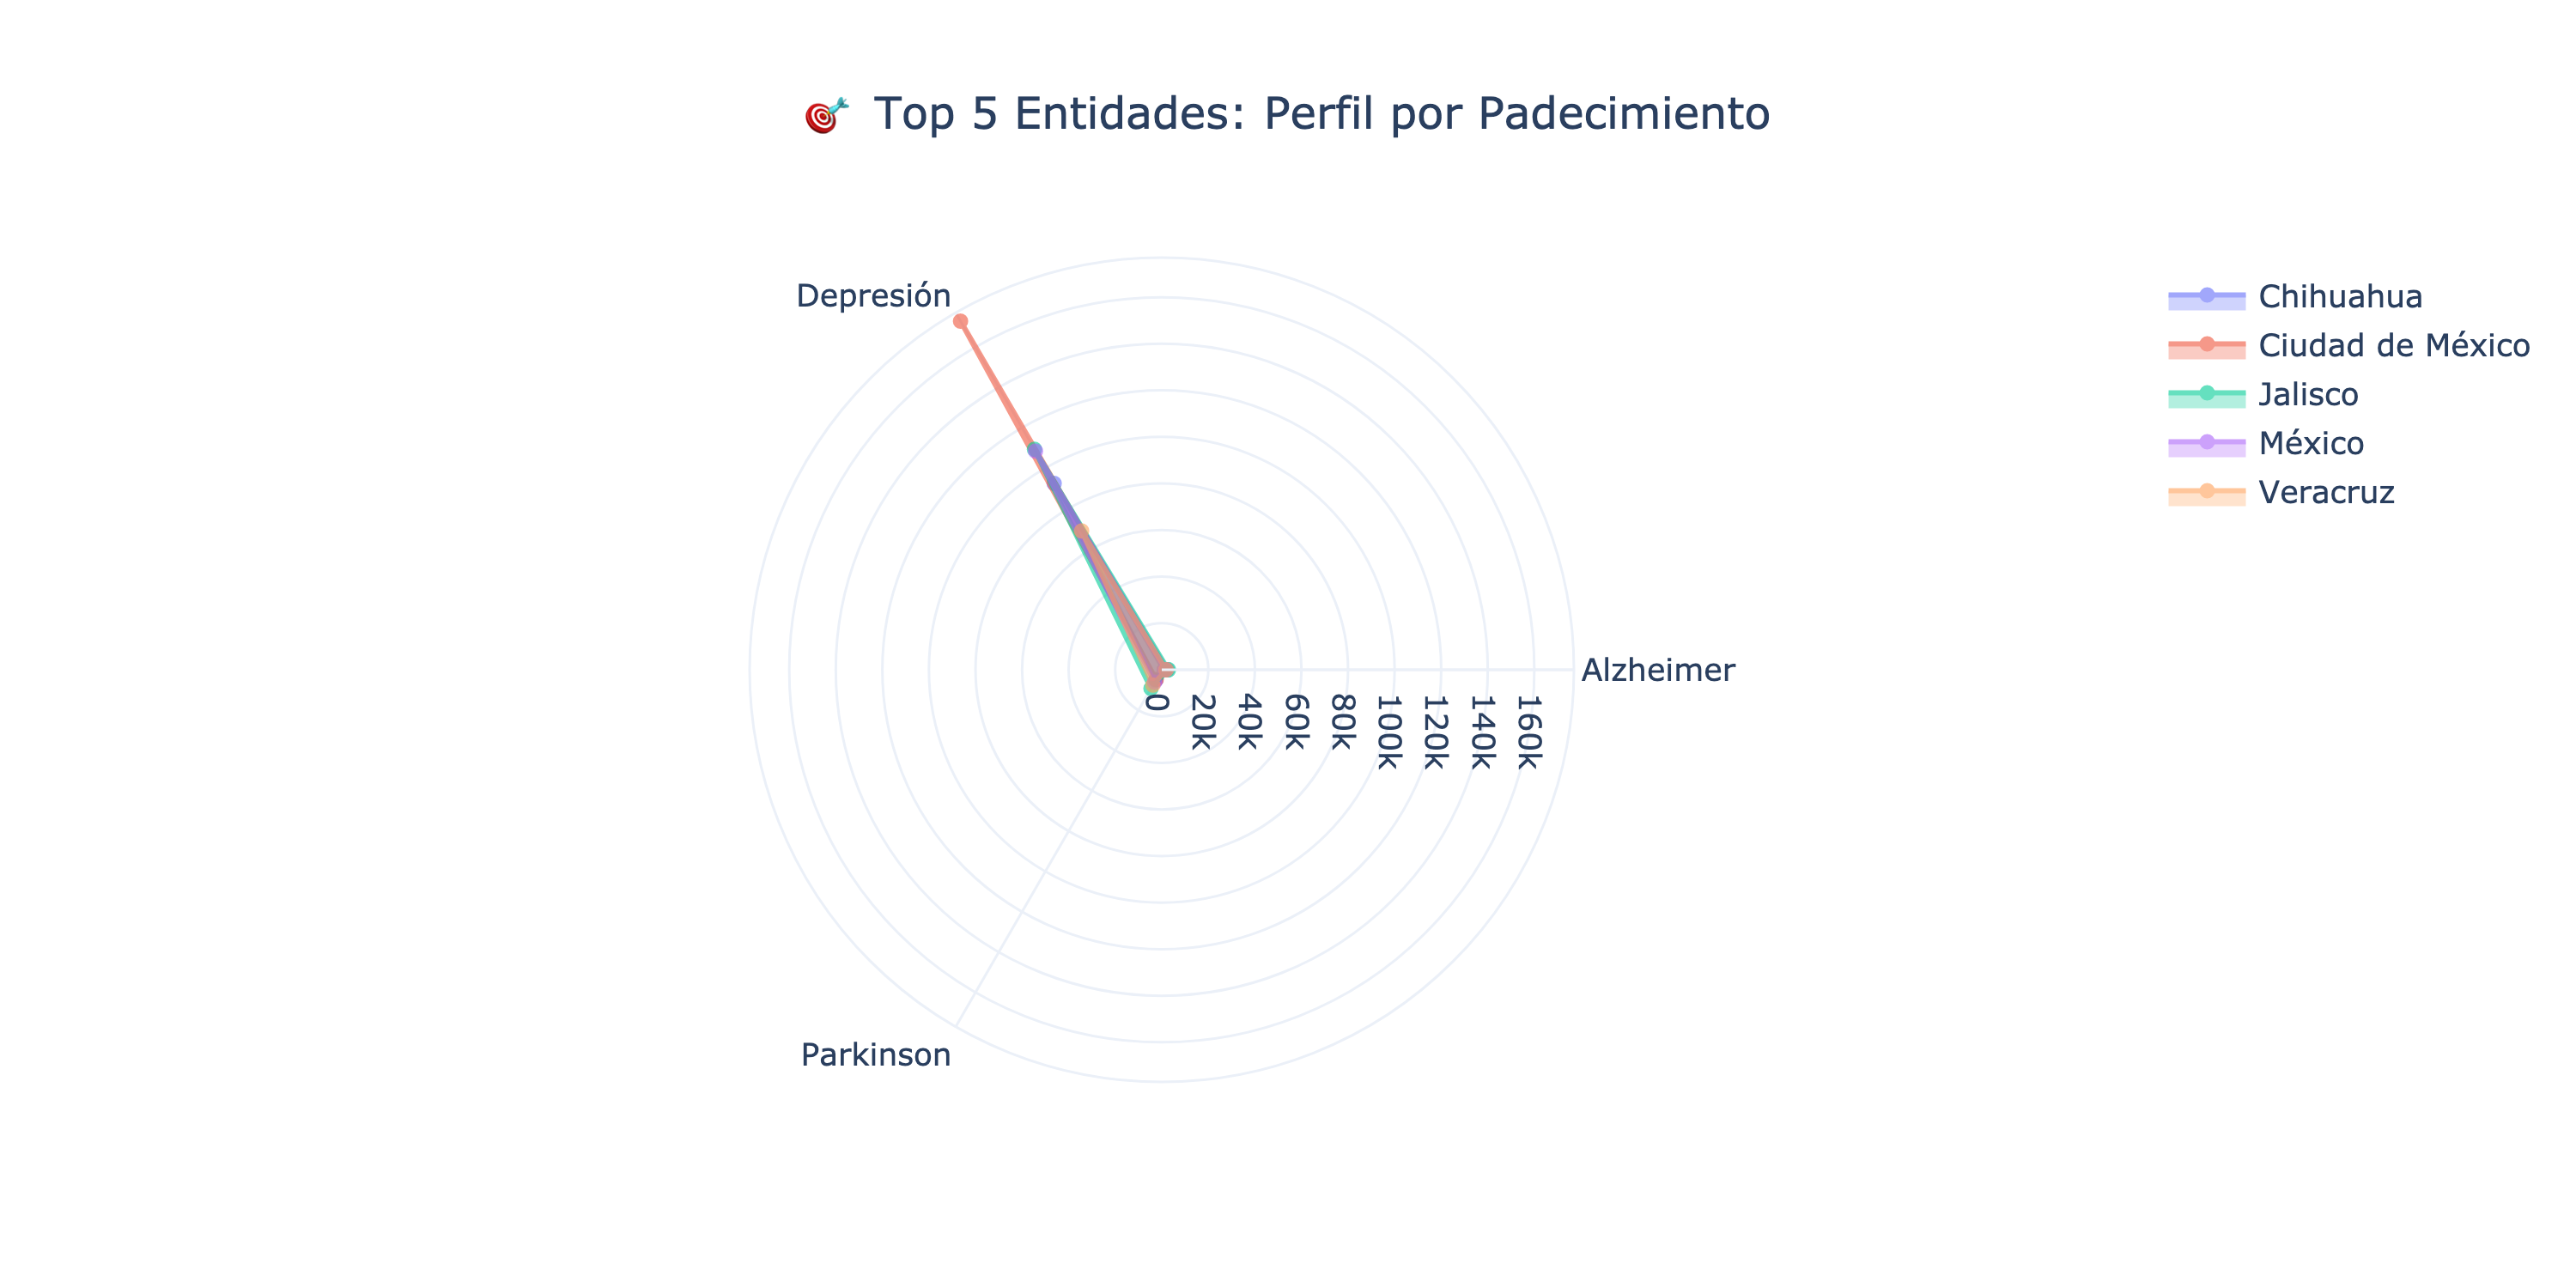

In [46]:
"""
Gráfico de radar: Top 5 entidades por casos.
"""
top_5_entidades = stats_entidad.head(5).reset_index()

# Datos para cada padecimiento por entidad
radar_data = df[df['Entidad'].isin(top_5_entidades['Entidad'])].groupby(
    ['Entidad', 'Padecimiento']
)['Casos_semana'].sum().unstack().fillna(0)

fig = go.Figure()

for entidad in radar_data.index:
    fig.add_trace(go.Scatterpolar(
        r=radar_data.loc[entidad].values.tolist() + [radar_data.loc[entidad].values[0]],
        theta=radar_data.columns.tolist() + [radar_data.columns[0]],
        name=entidad,
        fill='toself',
        opacity=0.6
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True)
    ),
    title={
        'text': '🎯 Top 5 Entidades: Perfil por Padecimiento',
        'x': 0.5,
        'xanchor': 'center'
    },
    height=500,
    template=PLOTLY_TEMPLATE
)

fig.show(config=PLOT_CONFIG)

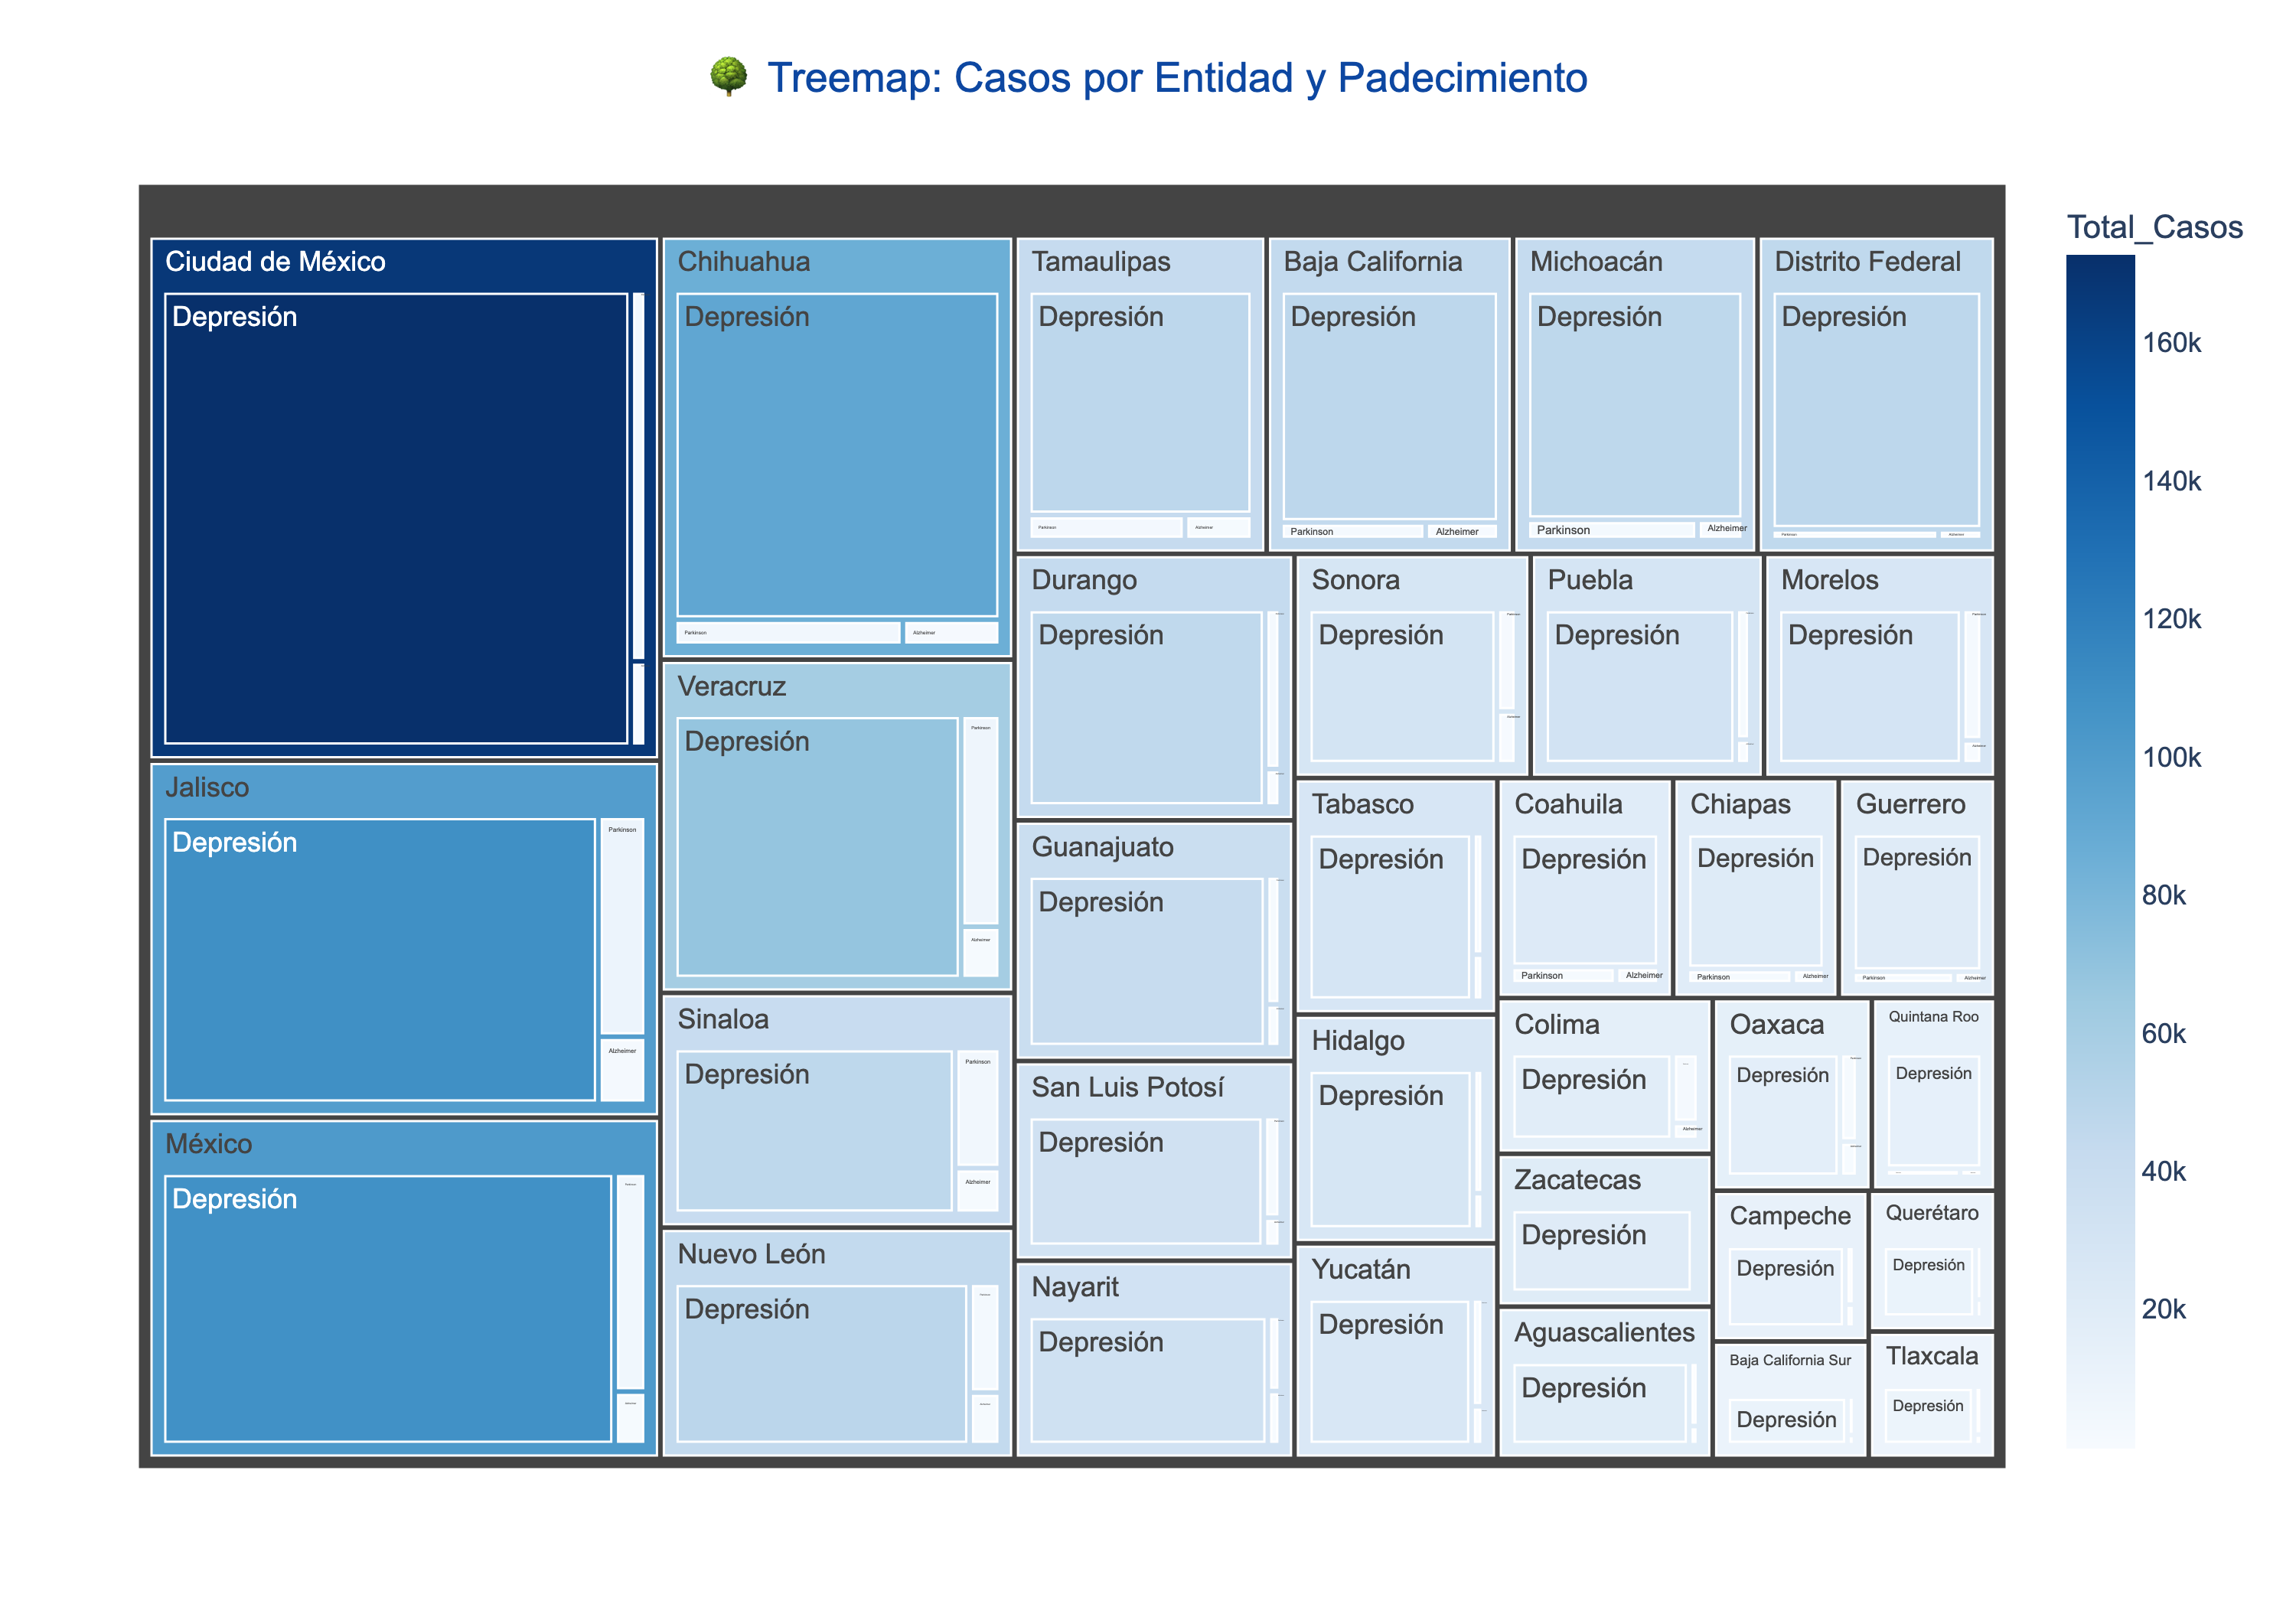

In [47]:
"""
Treemap de casos por entidad y padecimiento.
"""
treemap_data = df.groupby(['Entidad', 'Padecimiento'])['Casos_semana'].sum().reset_index()
treemap_data.columns = ['Entidad', 'Padecimiento', 'Total_Casos']

fig = px.treemap(
    treemap_data,
    path=['Entidad', 'Padecimiento'],
    values='Total_Casos',
    color='Total_Casos',
    color_continuous_scale='Blues'
)

fig = style_plotly_figure(fig, '🌳 Treemap: Casos por Entidad y Padecimiento', height=700)
fig.show(config=PLOT_CONFIG)

### 8.2 Evolución Geográfica en el Tiempo

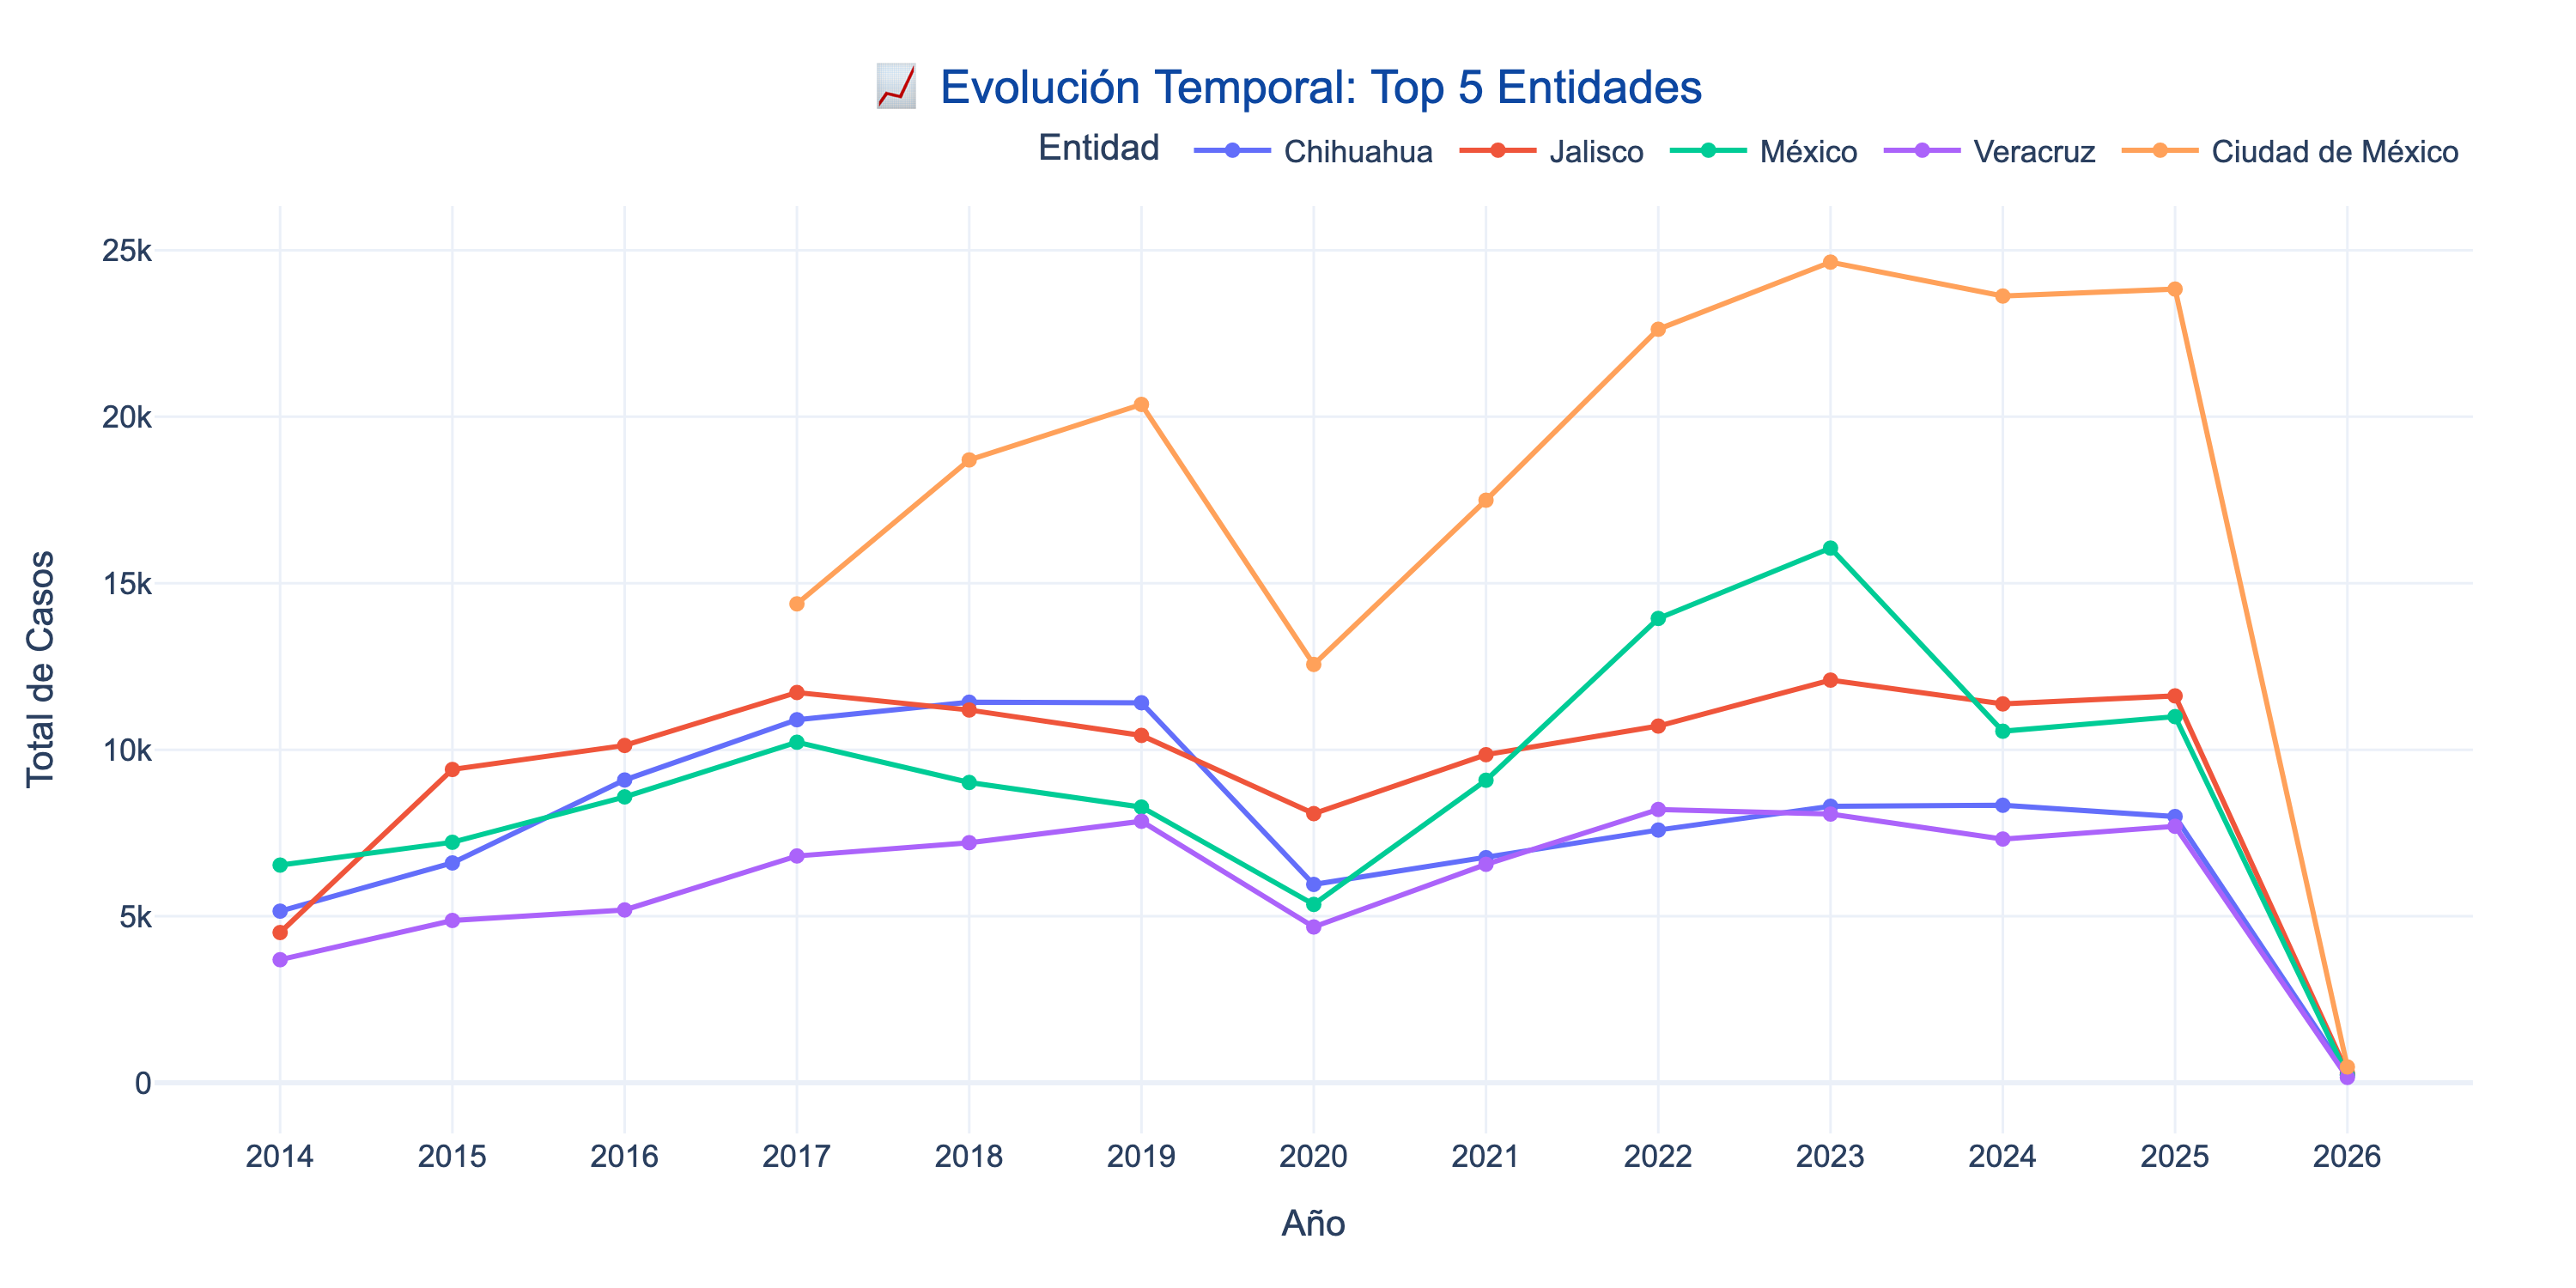

In [48]:
"""
Evolución temporal de Top 5 entidades.
"""
top_5_nombres = stats_entidad.head(5).index.tolist()

evolucion_top5 = df[df['Entidad'].isin(top_5_nombres)].groupby(
    ['Anio', 'Entidad']
)['Casos_semana'].sum().reset_index()

fig = px.line(
    evolucion_top5,
    x='Anio',
    y='Casos_semana',
    color='Entidad',
    markers=True
)

fig = style_plotly_figure(fig, '📈 Evolución Temporal: Top 5 Entidades')
fig.update_layout(
    xaxis_title='Año',
    yaxis_title='Total de Casos',
    xaxis={'type': 'category'}
)
fig.show(config=PLOT_CONFIG)

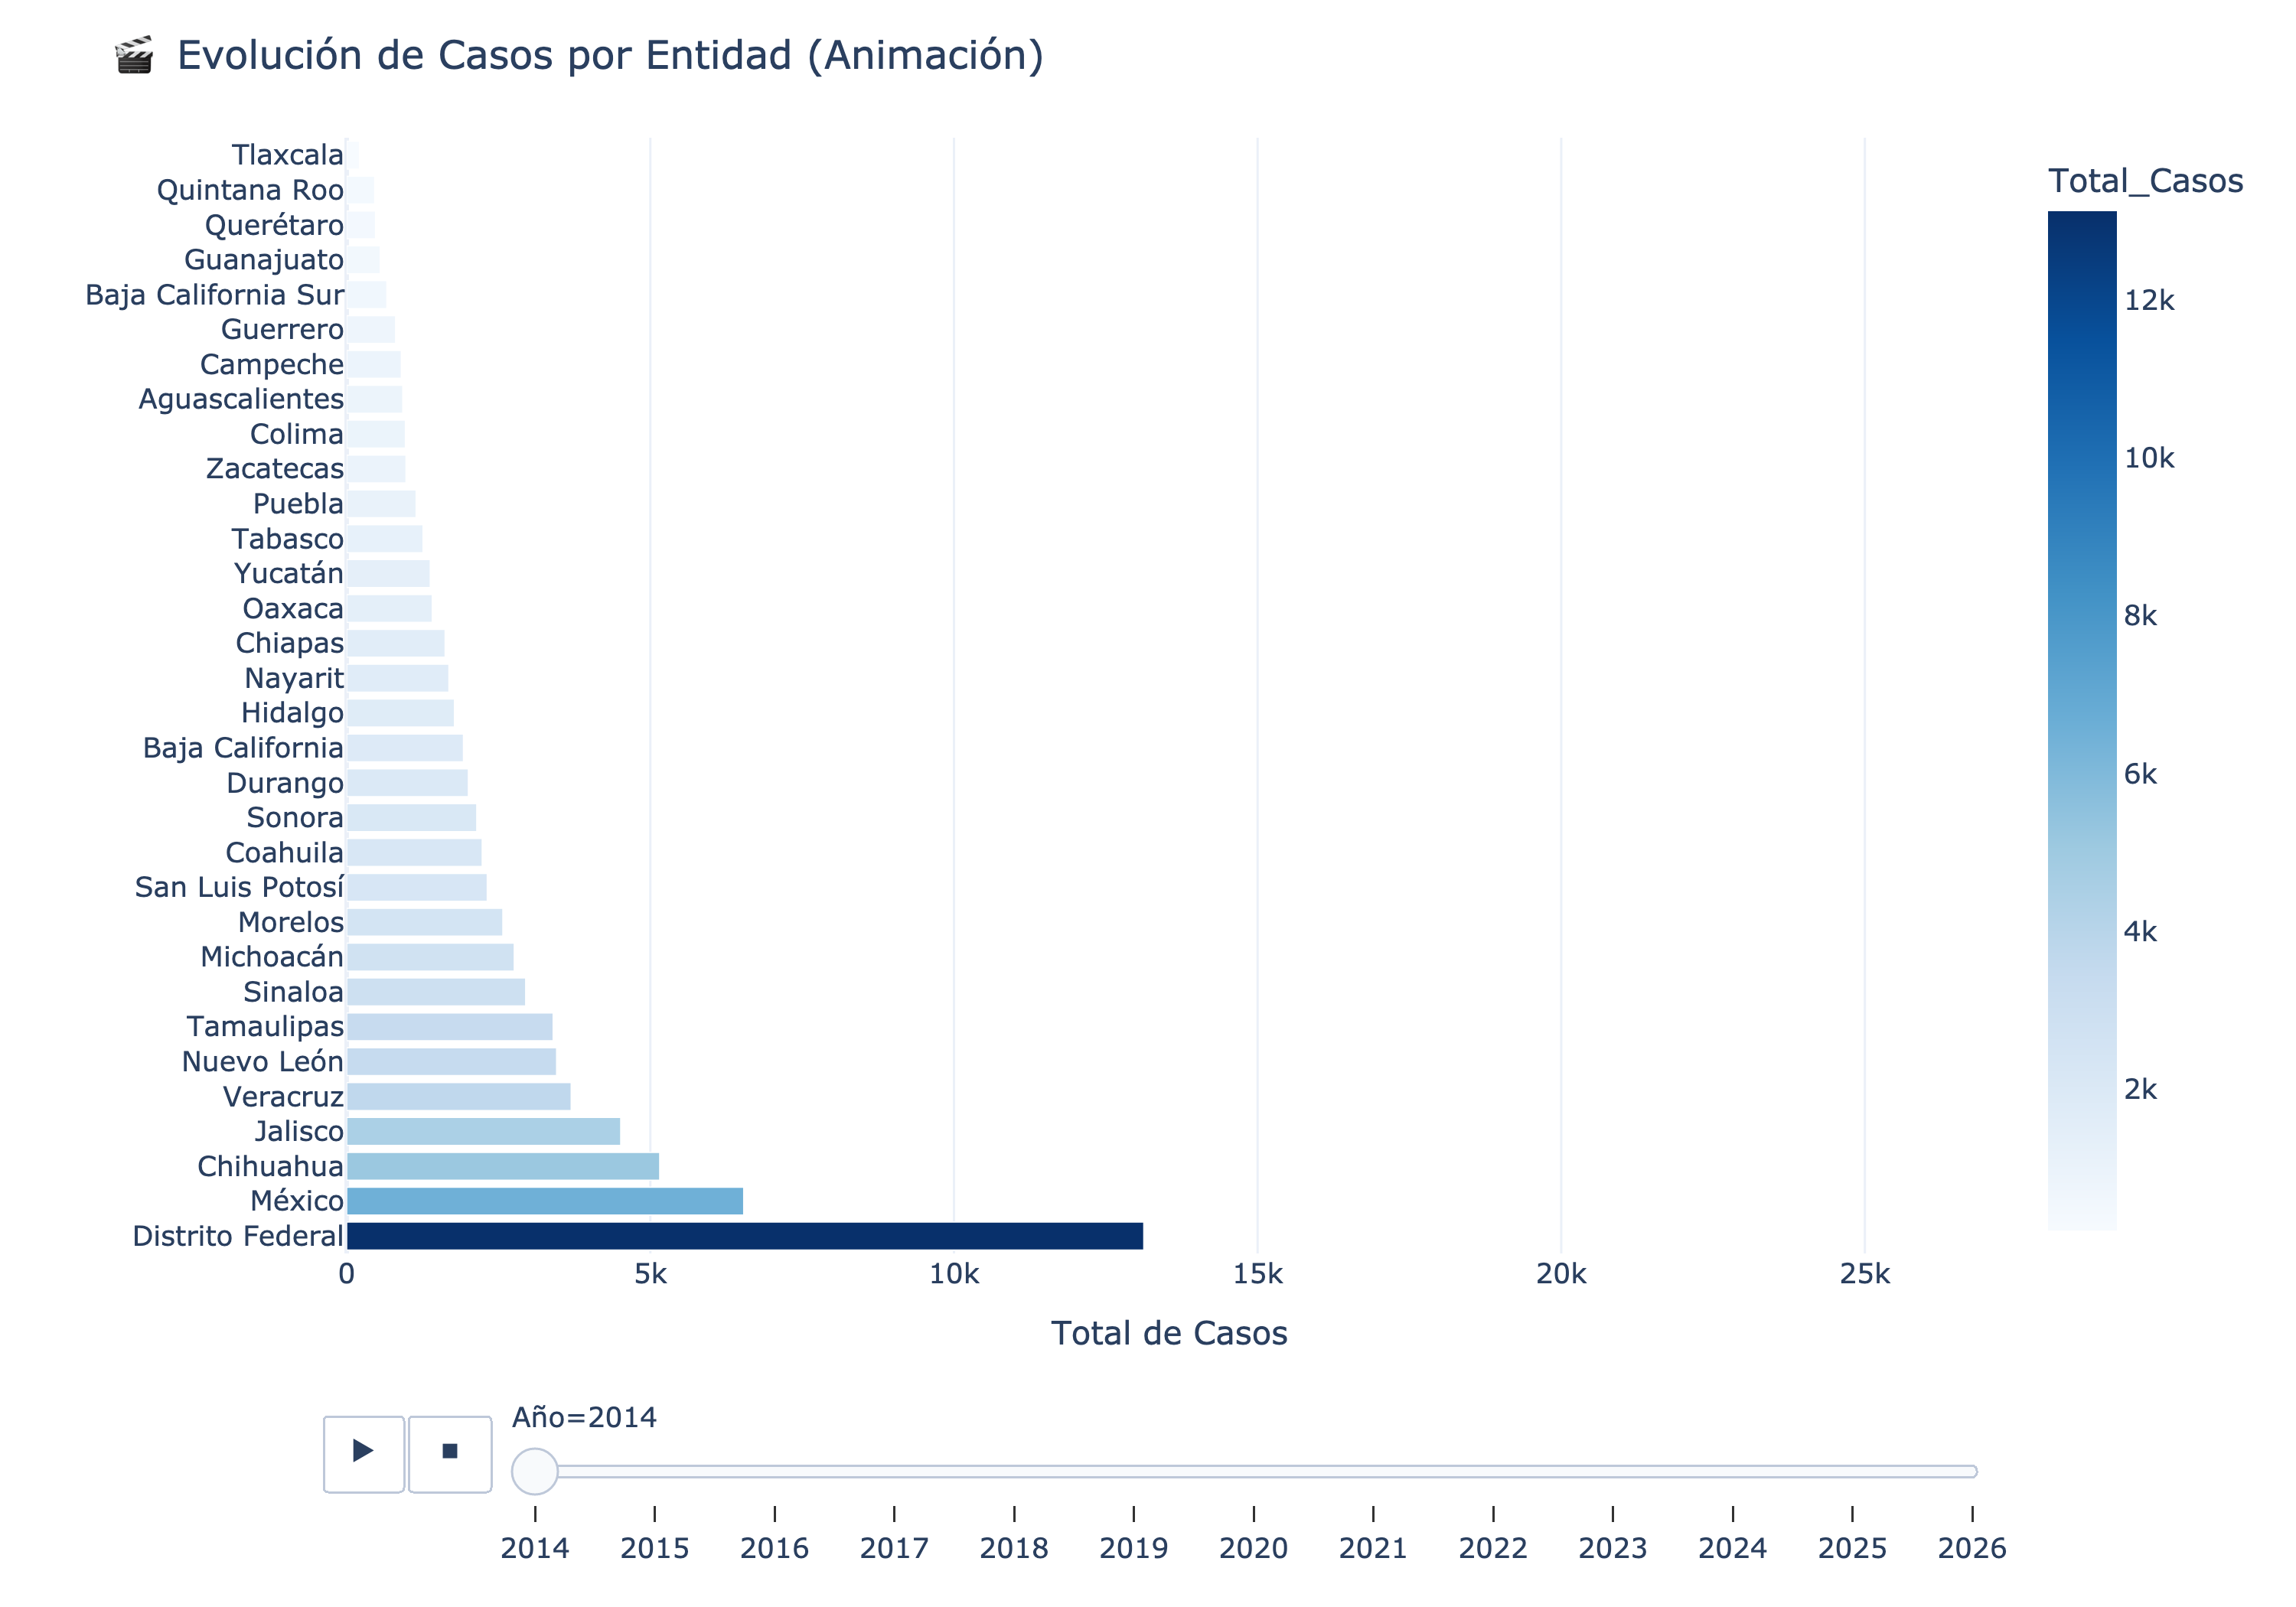

In [49]:
"""
Animación de evolución geográfica por año.
"""
evolucion_geo = df.groupby(['Anio', 'Entidad'])['Casos_semana'].sum().reset_index()
evolucion_geo.columns = ['Año', 'Entidad', 'Total_Casos']

fig = px.bar(
    evolucion_geo.sort_values(['Año', 'Total_Casos'], ascending=[True, False]),
    x='Total_Casos',
    y='Entidad',
    orientation='h',
    animation_frame='Año',
    color='Total_Casos',
    color_continuous_scale='Blues',
    range_x=[0, evolucion_geo['Total_Casos'].max() * 1.1]
)

fig.update_layout(
    title='🎬 Evolución de Casos por Entidad (Animación)',
    xaxis_title='Total de Casos',
    yaxis_title='',
    height=700,
    template=PLOTLY_TEMPLATE
)

fig.show(config=PLOT_CONFIG)

---
## 9. ⚖️ Balance de Clases

In [50]:
"""
Análisis de balance de clases (Padecimiento).
"""
print("\n📊 Balance de Clases - Variable 'Padecimiento':")
print("=" * 60)

# Conteo de registros por padecimiento
balance_registros = df['Padecimiento'].value_counts()
balance_pct = (balance_registros / len(df) * 100).round(2)

balance_df = pd.DataFrame({
    'Padecimiento': balance_registros.index,
    'N_Registros': balance_registros.values,
    'Porcentaje': balance_pct.values
})

print("\n📌 Distribución de registros:")
display(balance_df)

# Ratio de desbalance
max_class = balance_registros.max()
min_class = balance_registros.min()
ratio = max_class / min_class

print(f"\n📊 Ratio de desbalance (máximo/mínimo): {ratio:.2f}:1")

if ratio > 3:
    print("⚠️ Existe un desbalance significativo en las clases.")
    print("   Considerar técnicas de: SMOTE, undersampling, class weights, o stratified sampling.")
else:
    print("✅ El balance de clases es aceptable para modelado directo.")


📊 Balance de Clases - Variable 'Padecimiento':

📌 Distribución de registros:


Padecimiento  N_Registros  Porcentaje
0    Depresión        20096       33.33
1    Parkinson        20096       33.33
2    Alzheimer        20096       33.33


📊 Ratio de desbalance (máximo/mínimo): 1.00:1
✅ El balance de clases es aceptable para modelado directo.


In [51]:
"""
Balance de clases considerando suma de casos (no solo registros).
"""
balance_casos = df.groupby('Padecimiento')['Casos_semana'].sum()
balance_casos_pct = (balance_casos / balance_casos.sum() * 100).round(2)

balance_casos_df = pd.DataFrame({
    'Padecimiento': balance_casos.index,
    'Total_Casos': balance_casos.values,
    'Porcentaje': balance_casos_pct.values
})

print("\n📌 Distribución por total de casos:")
display(balance_casos_df)

# Ratio por casos
ratio_casos = balance_casos.max() / balance_casos.min()
print(f"\n📊 Ratio de desbalance por casos: {ratio_casos:.2f}:1")


📌 Distribución por total de casos:


Padecimiento  Total_Casos  Porcentaje
0    Alzheimer     28450.00        1.89
1    Depresión   1386057.00       92.30
2    Parkinson     87162.00        5.80


📊 Ratio de desbalance por casos: 48.72:1


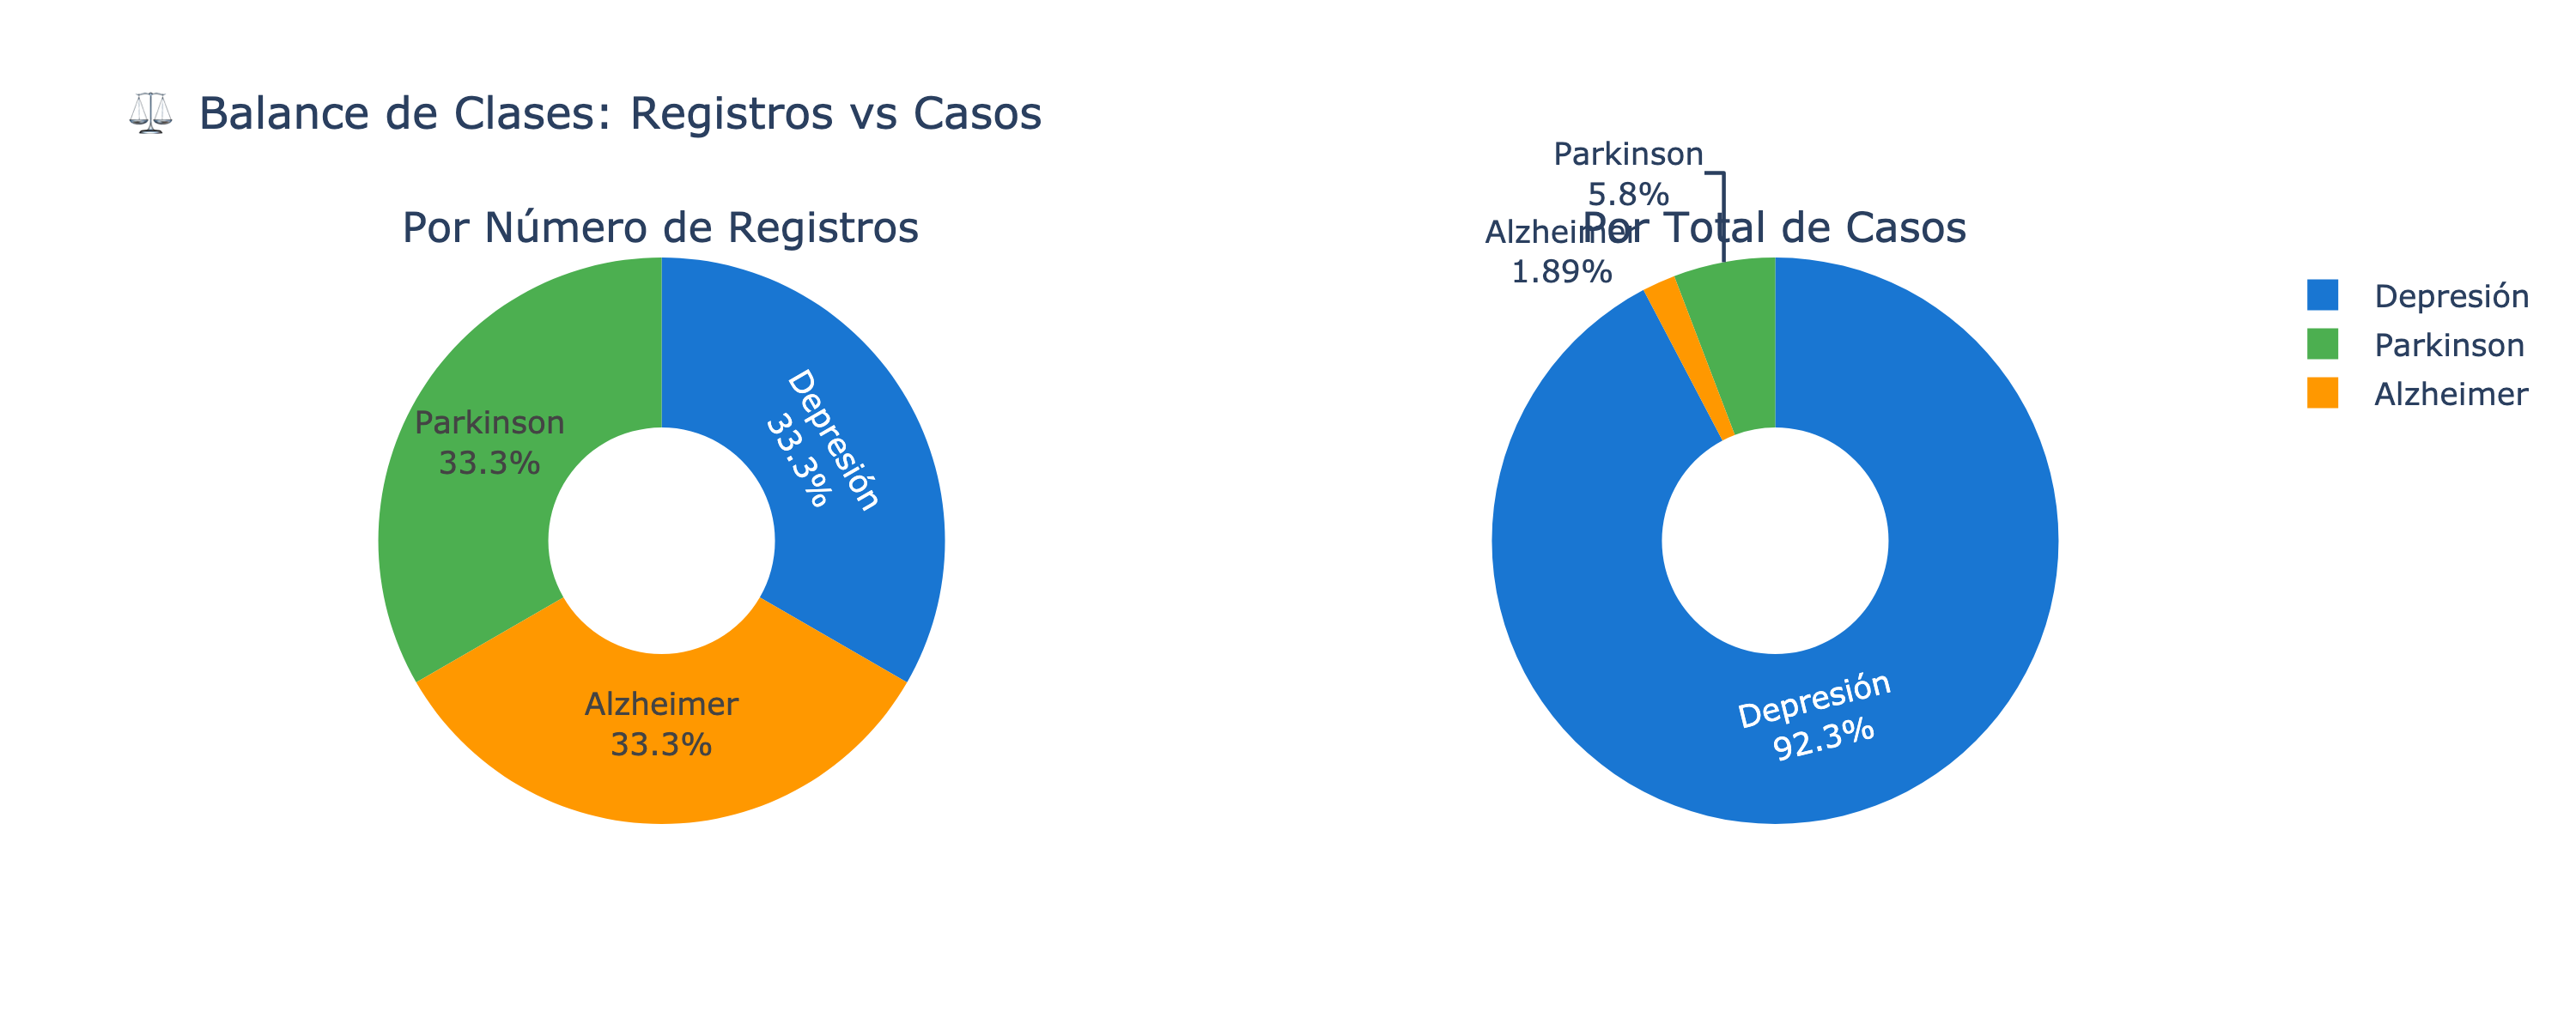

In [52]:
"""
Visualización de balance de clases.
"""
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Por Número de Registros', 'Por Total de Casos'],
    specs=[[{'type': 'pie'}, {'type': 'pie'}]]
)

# Pie chart por registros
fig.add_trace(
    go.Pie(
        labels=balance_df['Padecimiento'],
        values=balance_df['N_Registros'],
        marker_colors=[DISEASE_COLORS[p] for p in balance_df['Padecimiento']],
        hole=0.4,
        textinfo='percent+label'
    ),
    row=1, col=1
)

# Pie chart por casos
fig.add_trace(
    go.Pie(
        labels=balance_casos_df['Padecimiento'],
        values=balance_casos_df['Total_Casos'],
        marker_colors=[DISEASE_COLORS[p] for p in balance_casos_df['Padecimiento']],
        hole=0.4,
        textinfo='percent+label'
    ),
    row=1, col=2
)

fig.update_layout(
    title='⚖️ Balance de Clases: Registros vs Casos',
    height=400,
    template=PLOTLY_TEMPLATE
)

fig.show(config=PLOT_CONFIG)

---
## 10. 🔧 Preprocesamiento Propuesto

### 10.1 Manejo de Valores Faltantes

In [53]:
"""
Estrategia de manejo de valores faltantes.
"""
print("\n🔧 Estrategia de Manejo de Valores Faltantes:")
print("=" * 60)

missing_summary = get_missing_summary(df)
cols_con_faltantes = missing_summary[missing_summary['Nulos'] > 0]

if len(cols_con_faltantes) == 0:
    print("\n✅ No hay valores faltantes. No se requiere imputación.")
else:
    print("\n📌 Estrategias recomendadas por columna:")
    for _, row in cols_con_faltantes.iterrows():
        col = row['Columna']
        pct = row['Pct_Nulos']
        
        if pct < 5:
            estrategia = "Imputación con mediana (numérico) o moda (categórico)"
        elif pct < 20:
            estrategia = "Imputación con KNN o modelo predictivo"
        else:
            estrategia = "Considerar eliminación de columna o creación de indicador de ausencia"
        
        print(f"   • {col} ({pct:.2f}% faltantes): {estrategia}")


🔧 Estrategia de Manejo de Valores Faltantes:

📌 Estrategias recomendadas por columna:
   • Acumulado_anio_anterior (8.44% faltantes): Imputación con KNN o modelo predictivo
   • Casos_semana (0.00% faltantes): Imputación con mediana (numérico) o moda (categórico)


### 10.2 Tratamiento de Outliers

In [54]:
"""
Estrategia de tratamiento de outliers.
"""
print("\n🔧 Estrategia de Tratamiento de Outliers:")
print("=" * 60)

print("""
📌 Consideraciones:

1. Los outliers en datos epidemiológicos pueden representar:
   - Brotes reales de enfermedades (información valiosa)
   - Errores de registro o captura
   - Eventos especiales (campañas de detección, cambios de criterios)

2. Estrategia recomendada:
   ✅ MANTENER outliers para análisis exploratorio y detección de patrones
   ✅ WINSORIZAR (cap al percentil 95/99) para modelos sensibles a outliers
   ✅ Usar modelos robustos (ej. regresión robusta, Random Forest)
   ❌ NO eliminar sin justificación epidemiológica

3. Para Prophet (modelo de forecasting):
   - Prophet es robusto a outliers gracias a su modelado de tendencias
   - Se puede usar el parámetro 'outlier_influence' para ajustar sensibilidad
""")


🔧 Estrategia de Tratamiento de Outliers:

📌 Consideraciones:

1. Los outliers en datos epidemiológicos pueden representar:
   - Brotes reales de enfermedades (información valiosa)
   - Errores de registro o captura
   - Eventos especiales (campañas de detección, cambios de criterios)

2. Estrategia recomendada:
   ✅ MANTENER outliers para análisis exploratorio y detección de patrones
   ✅ WINSORIZAR (cap al percentil 95/99) para modelos sensibles a outliers
   ✅ Usar modelos robustos (ej. regresión robusta, Random Forest)
   ❌ NO eliminar sin justificación epidemiológica

3. Para Prophet (modelo de forecasting):
   - Prophet es robusto a outliers gracias a su modelado de tendencias
   - Se puede usar el parámetro 'outlier_influence' para ajustar sensibilidad



In [55]:
"""
Ejemplo de winsorización.
"""
def winsorize_column(series: pd.Series, lower_pct: float = 0.01, upper_pct: float = 0.99) -> pd.Series:
    """
    Aplica winsorización a una serie numérica.
    
    Args:
        series: Serie a transformar
        lower_pct: Percentil inferior
        upper_pct: Percentil superior
        
    Returns:
        Serie winsorizada
    """
    lower = series.quantile(lower_pct)
    upper = series.quantile(upper_pct)
    return series.clip(lower=lower, upper=upper)

# Ejemplo con Casos_semana
df_winsorized = df.copy()
df_winsorized['Casos_semana_winsorized'] = winsorize_column(df['Casos_semana'])

print("\n📊 Comparación antes/después de winsorización:")
comparacion = pd.DataFrame({
    'Estadística': ['Max', 'P99', 'P95', 'Media', 'Mediana'],
    'Original': [
        df['Casos_semana'].max(),
        df['Casos_semana'].quantile(0.99),
        df['Casos_semana'].quantile(0.95),
        df['Casos_semana'].mean(),
        df['Casos_semana'].median()
    ],
    'Winsorizado': [
        df_winsorized['Casos_semana_winsorized'].max(),
        df_winsorized['Casos_semana_winsorized'].quantile(0.99),
        df_winsorized['Casos_semana_winsorized'].quantile(0.95),
        df_winsorized['Casos_semana_winsorized'].mean(),
        df_winsorized['Casos_semana_winsorized'].median()
    ]
})
display(comparacion)


📊 Comparación antes/después de winsorización:


Estadística  Original  Winsorizado
0         Max   1311.00       258.00
1         P99    258.00       258.00
2         P95    113.00       113.00
3       Media     24.91        23.73
4     Mediana      4.00         4.00

### 10.3 Transformaciones de Variables


🔧 Evaluación de Transformación Logarítmica:

📊 Sesgo original: 4.551
📊 Sesgo log-transformado: 0.523


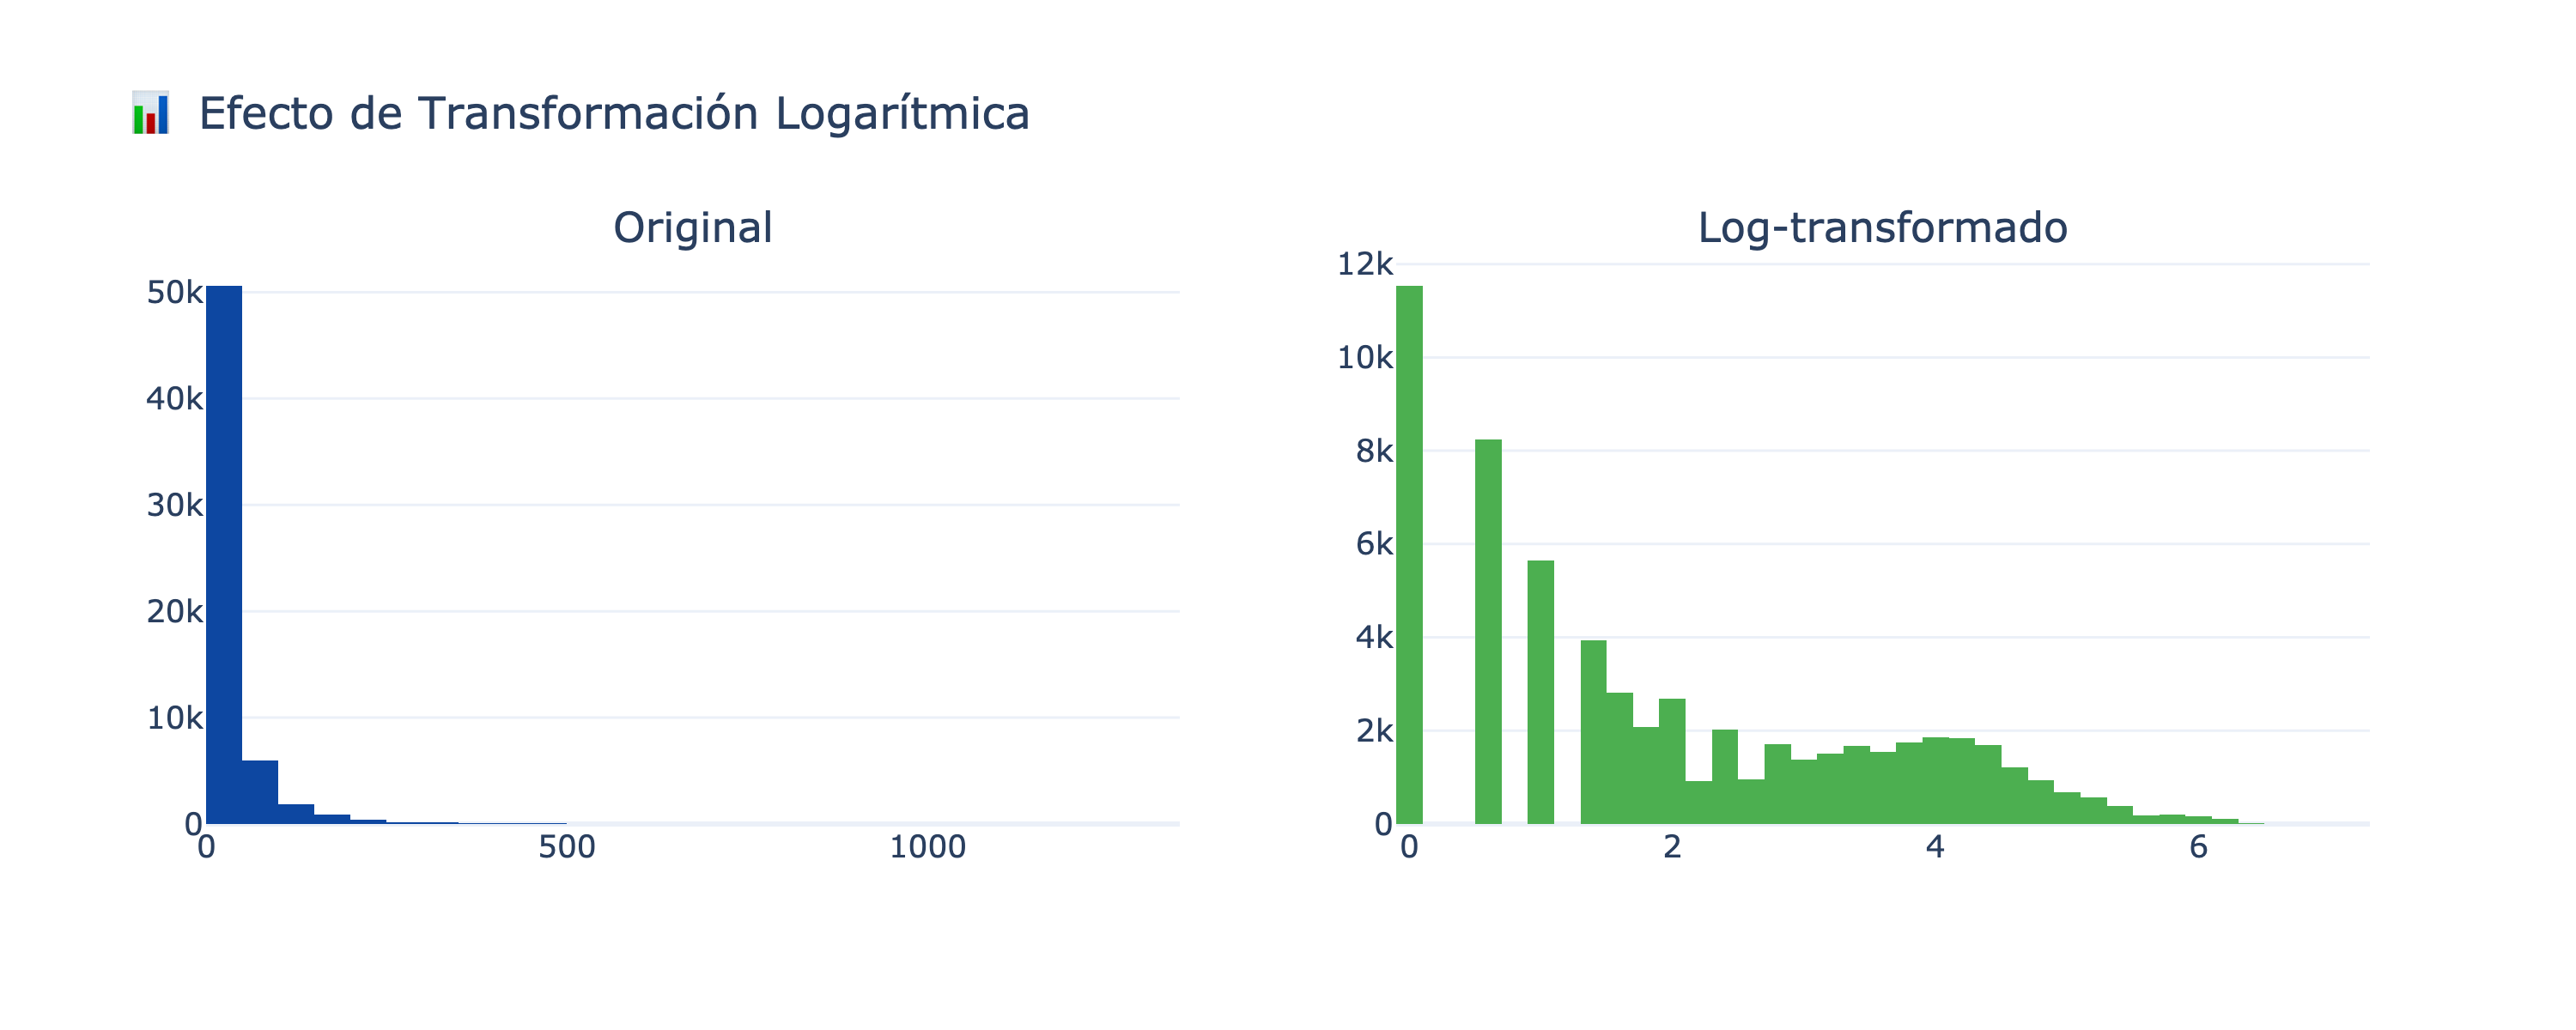

In [56]:
"""
Evaluación de transformaciones logarítmicas.
"""
print("\n🔧 Evaluación de Transformación Logarítmica:")
print("=" * 60)

# Transformación log(x+1) para manejar ceros
df_transform = df.copy()
df_transform['Casos_log'] = np.log1p(df['Casos_semana'])

# Comparar sesgo
print(f"\n📊 Sesgo original: {df['Casos_semana'].skew():.3f}")
print(f"📊 Sesgo log-transformado: {df_transform['Casos_log'].skew():.3f}")

# Visualizar comparación
fig = make_subplots(rows=1, cols=2, subplot_titles=['Original', 'Log-transformado'])

fig.add_trace(
    go.Histogram(x=df['Casos_semana'], nbinsx=50, marker_color=COLORS['primary']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_transform['Casos_log'], nbinsx=50, marker_color=COLORS['success']),
    row=1, col=2
)

fig.update_layout(
    title='📊 Efecto de Transformación Logarítmica',
    height=400,
    showlegend=False,
    template=PLOTLY_TEMPLATE
)

fig.show(config=PLOT_CONFIG)

### 10.4 Feature Engineering Propuesto

In [57]:
"""
Propuesta de Feature Engineering para el modelado.
"""
print("\n🔧 Feature Engineering Propuesto:")
print("=" * 60)

print("""
📌 Features temporales:
   • Mes del año (1-12)
   • Trimestre (1-4)
   • Indicador de fin de año (semanas 49-52)
   • Indicador de temporada de influenza (Oct-Mar)
   • Días festivos y vacaciones escolares

📌 Features de tendencia:
   • Media móvil de 4 semanas
   • Media móvil de 12 semanas
   • Diferencia con semana anterior (lag-1)
   • Diferencia con misma semana año anterior (lag-52)

📌 Features geográficas:
   • Región geográfica (Norte, Centro, Sur, etc.)
   • Población de la entidad
   • Densidad poblacional
   • Nivel de urbanización

📌 Features epidemiológicas:
   • Ratio hombres/mujeres
   • Índice de cambio vs año anterior
   • Acumulado del año hasta la semana actual
   • Tendencia (creciente/decreciente/estable)
   
📌 Features categóricas codificadas:
   • One-hot encoding para Padecimiento
   • Target encoding para Entidad (correlación con variable objetivo)
""")


🔧 Feature Engineering Propuesto:

📌 Features temporales:
   • Mes del año (1-12)
   • Trimestre (1-4)
   • Indicador de fin de año (semanas 49-52)
   • Indicador de temporada de influenza (Oct-Mar)
   • Días festivos y vacaciones escolares

📌 Features de tendencia:
   • Media móvil de 4 semanas
   • Media móvil de 12 semanas
   • Diferencia con semana anterior (lag-1)
   • Diferencia con misma semana año anterior (lag-52)

📌 Features geográficas:
   • Región geográfica (Norte, Centro, Sur, etc.)
   • Población de la entidad
   • Densidad poblacional
   • Nivel de urbanización

📌 Features epidemiológicas:
   • Ratio hombres/mujeres
   • Índice de cambio vs año anterior
   • Acumulado del año hasta la semana actual
   • Tendencia (creciente/decreciente/estable)

📌 Features categóricas codificadas:
   • One-hot encoding para Padecimiento
   • Target encoding para Entidad (correlación con variable objetivo)



In [58]:
"""
Ejemplo de implementación de algunas features.
"""
def create_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea features temporales a partir de las columnas Anio y Semana.
    
    Args:
        df: DataFrame original
        
    Returns:
        DataFrame con nuevas features
    """
    df_feat = df.copy()
    
    # Convertir semana a int
    df_feat['Semana_num'] = df_feat['Semana'].astype(int)
    
    # Mes aproximado (cada 4 semanas)
    df_feat['Mes_aprox'] = ((df_feat['Semana_num'] - 1) // 4) + 1
    
    # Trimestre
    df_feat['Trimestre'] = ((df_feat['Semana_num'] - 1) // 13) + 1
    
    # Indicador de fin de año
    df_feat['Es_fin_anio'] = (df_feat['Semana_num'] >= 49).astype(int)
    
    # Temporada de influenza (aproximadamente semanas 40-52 y 1-15)
    df_feat['Temporada_influenza'] = (
        (df_feat['Semana_num'] >= 40) | (df_feat['Semana_num'] <= 15)
    ).astype(int)
    
    # Ratio hombres/mujeres
    df_feat['Ratio_H_M'] = (
        df_feat['Acumulado_hombres'] / 
        df_feat['Acumulado_mujeres'].replace(0, np.nan)
    ).fillna(1)
    
    return df_feat

# Aplicar features
df_features = create_temporal_features(df)

print("\n📊 Nuevas features creadas:")
nuevas_cols = ['Semana_num', 'Mes_aprox', 'Trimestre', 'Es_fin_anio', 'Temporada_influenza', 'Ratio_H_M']
display(df_features[nuevas_cols].head(10))


📊 Nuevas features creadas:


Semana_num  Mes_aprox  Trimestre  Es_fin_anio  Temporada_influenza  \
0           2          1          1            0                    1   
1           2          1          1            0                    1   
2           2          1          1            0                    1   
3           2          1          1            0                    1   
4           2          1          1            0                    1   
5           2          1          1            0                    1   
6           2          1          1            0                    1   
7           2          1          1            0                    1   
8           2          1          1            0                    1   
9           2          1          1            0                    1   

   Ratio_H_M  
0       1.00  
1       1.00  
2       1.00  
3       1.00  
4       1.00  
5       1.00  
6       1.00  
7       1.00  
8       1.00  
9       1.00

---
## 11. 📝 Conclusiones y Siguientes Pasos

### 11.1 Hallazgos Clave del EDA

In [59]:
"""
Resumen de hallazgos clave.
"""
print("""
═══════════════════════════════════════════════════════════════════════════════
                       📊 HALLAZGOS CLAVE DEL EDA
═══════════════════════════════════════════════════════════════════════════════

1. CALIDAD DE DATOS
   ────────────────────────────────────────────────────────────────────────────
   ✅ Dataset completo con 60,288 registros
   ✅ Cobertura temporal: 2012-2025 (13+ años)
   ✅ 32 entidades federativas representadas
   ✅ 3 padecimientos: Depresión, Parkinson, Alzheimer
   ⚠️ Verificar valores faltantes específicos según análisis
   ⚠️ Outliers presentes, principalmente en entidades con mayor población

2. DISTRIBUCIÓN DE CASOS
   ────────────────────────────────────────────────────────────────────────────
   📌 Depresión representa la mayoría de los casos (verificar % específico)
   📌 Distribución sesgada a la derecha en todas las variables numéricas
   📌 Requiere transformación logarítmica para modelado paramétrico

3. PATRONES TEMPORALES
   ────────────────────────────────────────────────────────────────────────────
   📈 Tendencia general creciente en casos reportados
   📉 Impacto visible de COVID-19 en años 2020-2021
   🔄 Estacionalidad presente en semanas epidemiológicas
   📊 Variación interanual significativa

4. PATRONES GEOGRÁFICOS
   ────────────────────────────────────────────────────────────────────────────
   🗺️ Concentración de casos en entidades de mayor población
   🗺️ Disparidades regionales significativas
   🗺️ Perfil de padecimientos varía por entidad

5. DIFERENCIAS POR SEXO
   ────────────────────────────────────────────────────────────────────────────
   👥 Diferencias notables en ratios H/M por padecimiento
   👥 Depresión: Mayor prevalencia en mujeres
   👥 Parkinson/Alzheimer: Distribución más equilibrada

═══════════════════════════════════════════════════════════════════════════════
""")


═══════════════════════════════════════════════════════════════════════════════
                       📊 HALLAZGOS CLAVE DEL EDA
═══════════════════════════════════════════════════════════════════════════════

1. CALIDAD DE DATOS
   ────────────────────────────────────────────────────────────────────────────
   ✅ Dataset completo con 60,288 registros
   ✅ Cobertura temporal: 2012-2025 (13+ años)
   ✅ 32 entidades federativas representadas
   ✅ 3 padecimientos: Depresión, Parkinson, Alzheimer
   ⚠️ Verificar valores faltantes específicos según análisis
   ⚠️ Outliers presentes, principalmente en entidades con mayor población

2. DISTRIBUCIÓN DE CASOS
   ────────────────────────────────────────────────────────────────────────────
   📌 Depresión representa la mayoría de los casos (verificar % específico)
   📌 Distribución sesgada a la derecha en todas las variables numéricas
   📌 Requiere transformación logarítmica para modelado paramétrico

3. PATRONES TEMPORALES
   ────────────────────

### 11.2 Recomendaciones para el Modelado

In [60]:
"""
Recomendaciones para la fase de modelado.
"""
print("""
═══════════════════════════════════════════════════════════════════════════════
                    🎯 RECOMENDACIONES PARA EL MODELADO
═══════════════════════════════════════════════════════════════════════════════

1. PREPROCESAMIENTO RECOMENDADO
   ────────────────────────────────────────────────────────────────────────────
   • Transformación logarítmica para variables de conteo
   • Winsorización al percentil 99 para outliers extremos
   • Creación de features temporales (lag, media móvil, estacionalidad)
   • Encoding de variables categóricas según el modelo

2. MODELO PRINCIPAL: PROPHET
   ────────────────────────────────────────────────────────────────────────────
   ✅ Ideal para series temporales con estacionalidad
   ✅ Robusto a outliers y datos faltantes
   ✅ Permite incorporar efectos de días festivos
   ✅ Genera intervalos de confianza automáticamente
   
   Configuración sugerida:
   • Estacionalidad semanal: additive
   • Estacionalidad anual: additive
   • Changepoint detection para capturar cambios estructurales
   • Regresores adicionales: indicadores de pandemia, campañas de salud

3. ESTRATEGIA DE VALIDACIÓN
   ────────────────────────────────────────────────────────────────────────────
   • Time Series Split (mínimo 3 folds)
   • Métricas: MAE, MAPE, RMSE
   • Validar por entidad y por padecimiento
   • Backtesting con datos históricos

4. CONSIDERACIONES ESPECIALES
   ────────────────────────────────────────────────────────────────────────────
   ⚠️ Modelar cada padecimiento por separado
   ⚠️ Considerar modelos jerárquicos por entidad
   ⚠️ Incluir indicador de período COVID como regresor
   ⚠️ Monitorear drift en produción

═══════════════════════════════════════════════════════════════════════════════
""")


═══════════════════════════════════════════════════════════════════════════════
                    🎯 RECOMENDACIONES PARA EL MODELADO
═══════════════════════════════════════════════════════════════════════════════

1. PREPROCESAMIENTO RECOMENDADO
   ────────────────────────────────────────────────────────────────────────────
   • Transformación logarítmica para variables de conteo
   • Winsorización al percentil 99 para outliers extremos
   • Creación de features temporales (lag, media móvil, estacionalidad)
   • Encoding de variables categóricas según el modelo

2. MODELO PRINCIPAL: PROPHET
   ────────────────────────────────────────────────────────────────────────────
   ✅ Ideal para series temporales con estacionalidad
   ✅ Robusto a outliers y datos faltantes
   ✅ Permite incorporar efectos de días festivos
   ✅ Genera intervalos de confianza automáticamente

   Configuración sugerida:
   • Estacionalidad semanal: additive
   • Estacionalidad anual: additive
   • Changepoint dete

### 11.3 Limitaciones del Dataset

In [61]:
"""
Limitaciones identificadas en los datos.
"""
print("""
═══════════════════════════════════════════════════════════════════════════════
                       ⚠️ LIMITACIONES DEL DATASET
═══════════════════════════════════════════════════════════════════════════════

1. LIMITACIONES DE COBERTURA
   ────────────────────────────────────────────────────────────────────────────
   • Solo incluye casos reportados al sistema de vigilancia
   • Posible subreporte en algunas entidades
   • No incluye casos del sector privado

2. LIMITACIONES TEMPORALES
   ────────────────────────────────────────────────────────────────────────────
   • Cambios en criterios diagnósticos a lo largo del tiempo
   • Impacto de COVID-19 en detección y reporte
   • Posibles rezagos en actualización de datos

3. LIMITACIONES DE VARIABLES
   ────────────────────────────────────────────────────────────────────────────
   • No incluye edad de los pacientes
   • No incluye severidad o subtipo de enfermedad
   • No incluye información socioeconómica
   • No incluye comorbilidades

4. LIMITACIONES METODOLÓGICAS
   ────────────────────────────────────────────────────────────────────────────
   • Datos agregados (no individuales)
   • No es posible análisis de cohortes
   • No se puede calcular incidencia real (falta denominador poblacional)

═══════════════════════════════════════════════════════════════════════════════
""")


═══════════════════════════════════════════════════════════════════════════════
                       ⚠️ LIMITACIONES DEL DATASET
═══════════════════════════════════════════════════════════════════════════════

1. LIMITACIONES DE COBERTURA
   ────────────────────────────────────────────────────────────────────────────
   • Solo incluye casos reportados al sistema de vigilancia
   • Posible subreporte en algunas entidades
   • No incluye casos del sector privado

2. LIMITACIONES TEMPORALES
   ────────────────────────────────────────────────────────────────────────────
   • Cambios en criterios diagnósticos a lo largo del tiempo
   • Impacto de COVID-19 en detección y reporte
   • Posibles rezagos en actualización de datos

3. LIMITACIONES DE VARIABLES
   ────────────────────────────────────────────────────────────────────────────
   • No incluye edad de los pacientes
   • No incluye severidad o subtipo de enfermedad
   • No incluye información socioeconómica
   • No incluye comorbilid

### 11.4 Siguientes Pasos

In [62]:
"""
Roadmap de siguientes pasos.
"""
print("""
═══════════════════════════════════════════════════════════════════════════════
                         🚀 SIGUIENTES PASOS
═══════════════════════════════════════════════════════════════════════════════

FASE 1: PREPARACIÓN DE DATOS (Semana 1-2)
────────────────────────────────────────────────────────────────────────────
□ Implementar pipeline de preprocesamiento
□ Crear features temporales y geográficas
□ Dividir datos en train/validation/test
□ Guardar datasets procesados en DVC

FASE 2: DESARROLLO DE MODELOS (Semana 3-4)
────────────────────────────────────────────────────────────────────────────
□ Implementar modelo Prophet baseline
□ Optimizar hiperparámetros
□ Entrenar modelos por padecimiento y entidad
□ Evaluar con métricas de forecasting

FASE 3: VALIDACIÓN Y REFINAMIENTO (Semana 5-6)
────────────────────────────────────────────────────────────────────────────
□ Backtesting con datos históricos
□ Análisis de errores por segmento
□ Ajustar modelos según resultados
□ Documentar decisiones y hallazgos

FASE 4: MLOps Y PRODUCCIÓN (Semana 7-8)
────────────────────────────────────────────────────────────────────────────
□ Implementar pipeline de inferencia
□ Configurar monitoreo de drift
□ Crear dashboards de visualización
□ Preparar presentación para IMSS

═══════════════════════════════════════════════════════════════════════════════
""")

logger.success("\n✅ EDA completado exitosamente")
logger.info(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

2026-01-28 10:17:21.606 | SUCCESS  | __main__:<module>:40 - 
✅ EDA completado exitosamente
2026-01-28 10:17:21.608 | INFO     | __main__:<module>:41 - 📅 Fecha de ejecución: 2026-01-28 10:17:21



═══════════════════════════════════════════════════════════════════════════════
                         🚀 SIGUIENTES PASOS
═══════════════════════════════════════════════════════════════════════════════

FASE 1: PREPARACIÓN DE DATOS (Semana 1-2)
────────────────────────────────────────────────────────────────────────────
□ Implementar pipeline de preprocesamiento
□ Crear features temporales y geográficas
□ Dividir datos en train/validation/test
□ Guardar datasets procesados en DVC

FASE 2: DESARROLLO DE MODELOS (Semana 3-4)
────────────────────────────────────────────────────────────────────────────
□ Implementar modelo Prophet baseline
□ Optimizar hiperparámetros
□ Entrenar modelos por padecimiento y entidad
□ Evaluar con métricas de forecasting

FASE 3: VALIDACIÓN Y REFINAMIENTO (Semana 5-6)
────────────────────────────────────────────────────────────────────────────
□ Backtesting con datos históricos
□ Análisis de errores por segmento
□ Ajustar modelos según resultados
□ Documenta

---

## 📚 Referencias

- **SINAVE**: Sistema Nacional de Vigilancia Epidemiológica de México
- **Prophet**: Taylor, S.J. & Letham, B. (2017). Forecasting at scale. The American Statistician.
- **Plotly**: Plotly Technologies Inc. (2015). Collaborative data science.

---

**Equipo EpiForecast-MX**  
Tecnológico de Monterrey × IMSS  
Enero 2026